# Mask RCNN inference


# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

from copy import copy
import cv2
from skimage.morphology import skeletonize

/Users/daniel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from tensorflow.models.research.object_detection.utils import label_map_util

from tensorflow.models.research.object_detection.utils import visualization_utils as vis_util

/Users/daniel/anaconda3/lib/python3.6/site-packages/tensorflow/models/research/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/daniel/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/daniel/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/daniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/daniel/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/daniel/anaconda3/lib/python3.6/s

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
# MODEL_NAME = './saved_models/fine_tuned_model_inception_512'
MODEL_NAME = './downloaded_models/mask_rcnn_inception_v2_coco_2018_01_28/fine_tuned_model_100k_masked_full_set/'
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
PATH_TO_LABELS = '/Users/daniel/Documents/UCL/Project/Code/tensorflow_Mask_RCNN/data/worm_label_map.pbtxt'
NUM_CLASSES = 1

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


## Helper code

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 4)).astype(np.uint8)[:,:,:3]

In [8]:
def split_image(image):
    image_list = []
    horiz = np.split(image, 4, axis=0)
    
    for h in horiz:
        image_list.extend(np.split(h, 4, axis=1))
    
    return np.array(image_list)

In [9]:
def reassemble_image(image_list):
    rows = []
    for x in range(4):
        rows.append(np.hstack((image_list[x*4:(x*4)+4])))
    return np.vstack((rows))

# Load images for inference

In [10]:
NUM_IMAGES = 50
# PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/cropped_data/'
# PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data/annotation-data/cropped_collated_dataset/original_cropped_data/'
# PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data_pre_exams/eval/'
# PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data/annotation-data/cropped_collated_dataset/CX11271_worms10_food1-10_Set1_Pos4_Ch4_19052017_113042/'
PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data/annotation-data/cropped_collated_dataset/NIC199_worms10_food1-10_Set7_Pos4_Ch4_19052017_153012/'
FNAMES = [f for f in os.listdir(PATH_TO_TEST_IMAGES_DIR) if not f.startswith('.')]
FNAMES = sorted(FNAMES, key=int)

# print(list(np.random.choice(len(FNAMES), size=3, replace=False)))

TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/image/image_{}.png'.format(FNAMES[i],FNAMES[i])) for i in np.random.choice(len(FNAMES), size=NUM_IMAGES, replace=False)]

# Size, in inches, of the output images.
IMAGE_SIZE = (30,30)

# Detection

In [11]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [12]:
# def tiled_inference(images, graph):
#     with graph.as_default():
#         with tf.Session() as sess:
#             # Get handles to input and output tensors
#             ops = tf.get_default_graph().get_operations()
#             all_tensor_names = {output.name for op in ops for output in op.outputs}
#             tensor_dict = {}
#             for key in ['num_detections', 'detection_boxes', 'detection_scores',
#                         'detection_classes', 'detection_masks']:
#                 tensor_name = key + ':0'
#                 if tensor_name in all_tensor_names:
#                     tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
#             if 'detection_masks' in tensor_dict:
#                 detection_boxes = tensor_dict['detection_boxes']
#                 detection_masks = tensor_dict['detection_masks']
                
# #                 ### Number of objects detected in image
#                 real_num_detection = tf.cast(tensor_dict['num_detections'], tf.int32)
                
                
#                 detection_boxes = tf.slice(detection_boxes, [0,0, 0], [-1,real_num_detection, -1])
#                 detection_masks = tf.slice(detection_masks, [0,0, 0, 0], [-1,real_num_detection, -1, -1])
                
# #                 box_and_masks = [detection_boxes, detection_masks]
# #                 detection_masks_reframed = tf.map_fn(lambda x: utils_ops.reframe_box_masks_to_image_masks(
# #                         x[0], x[1], images[0].shape[0], images[0].shape[1]),
# #                                                      box_and_masks, dtype=np.float32)
        

                                                     
#                 detection_masks_reframed = tf.cast(
#                     tf.greater(detection_masks, 0.5), tf.uint8)
            
#                 tensor_dict['detection_masks'] = detection_masks_reframed
            
#             image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
            
                
#             #Inference
#             output_dict = sess.run(tensor_dict, feed_dict={image_tensor: images})
            
#             # all outputs are float32 numpy arrays, so convert types as appropriate
#             output_dict['num_detections'] = int(output_dict['num_detections'])
#             output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.uint8)
            
            
#     return output_dict

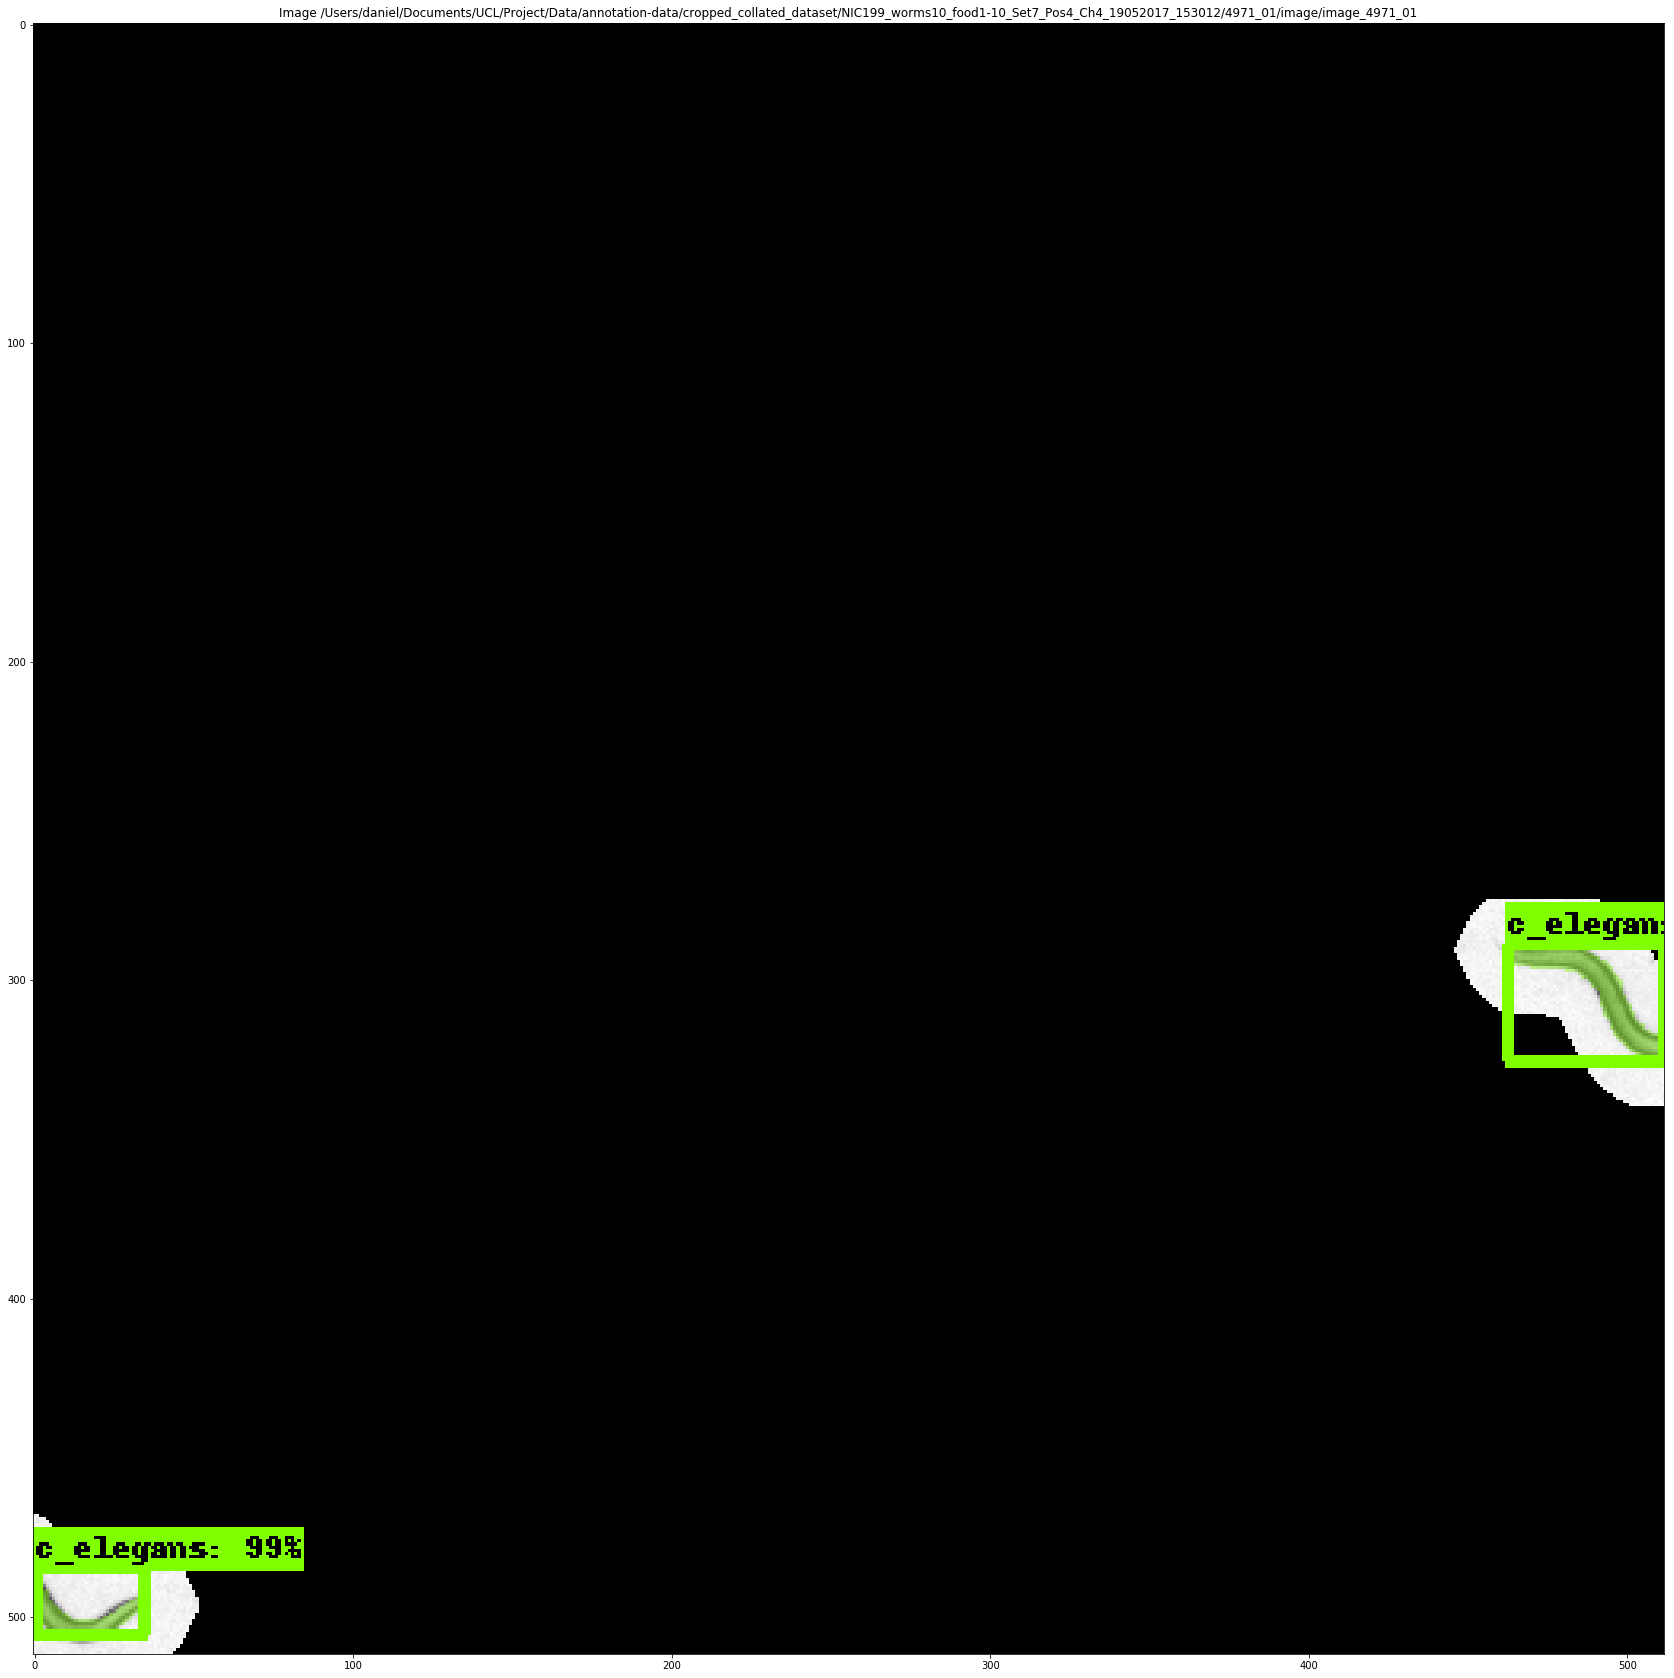

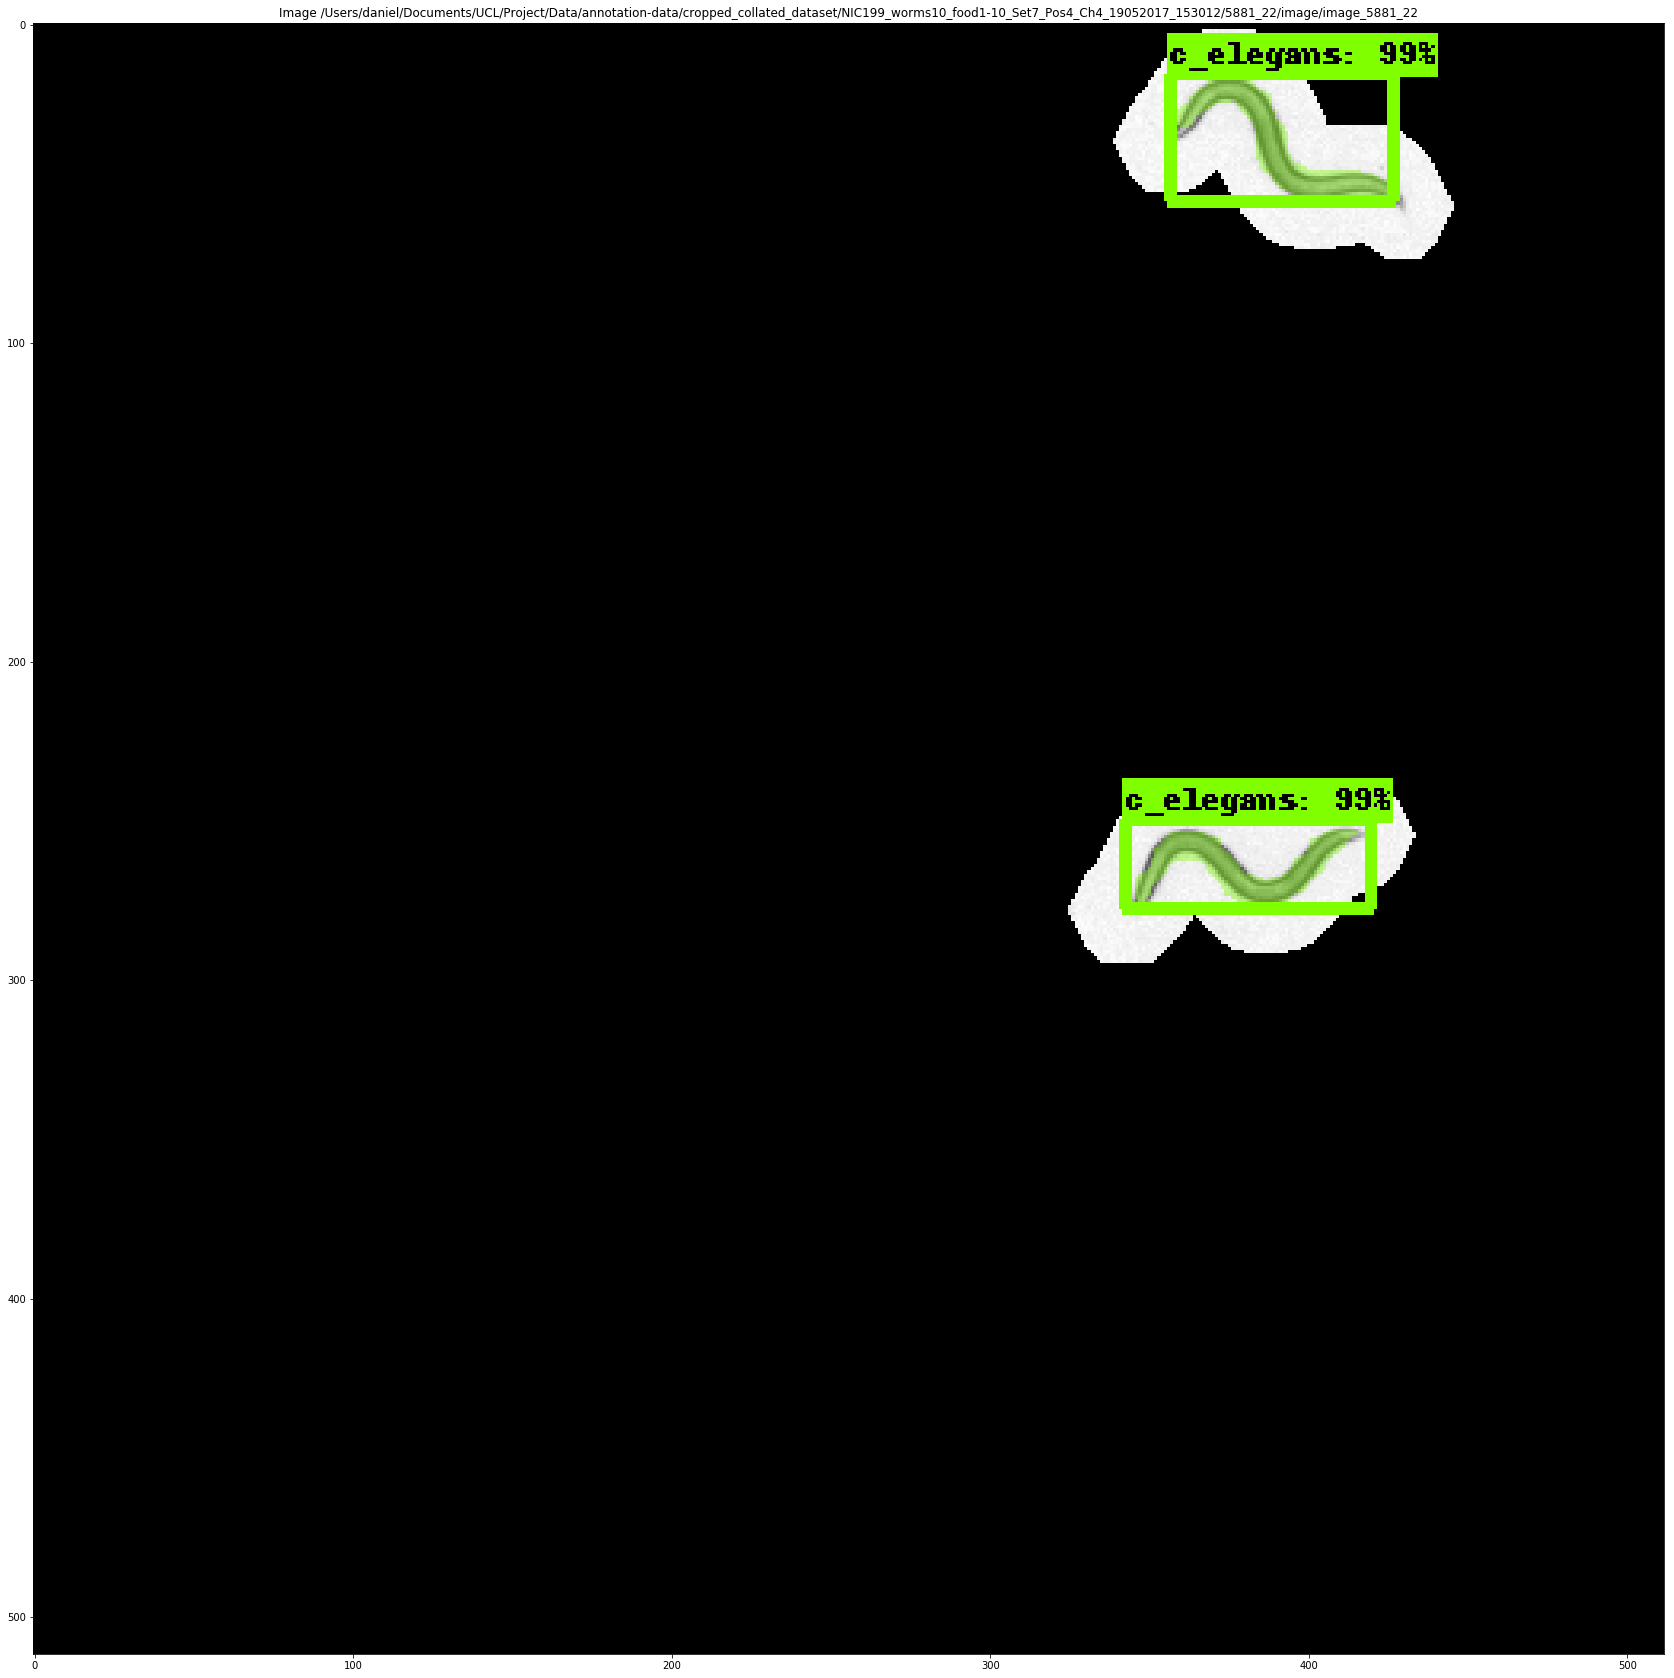

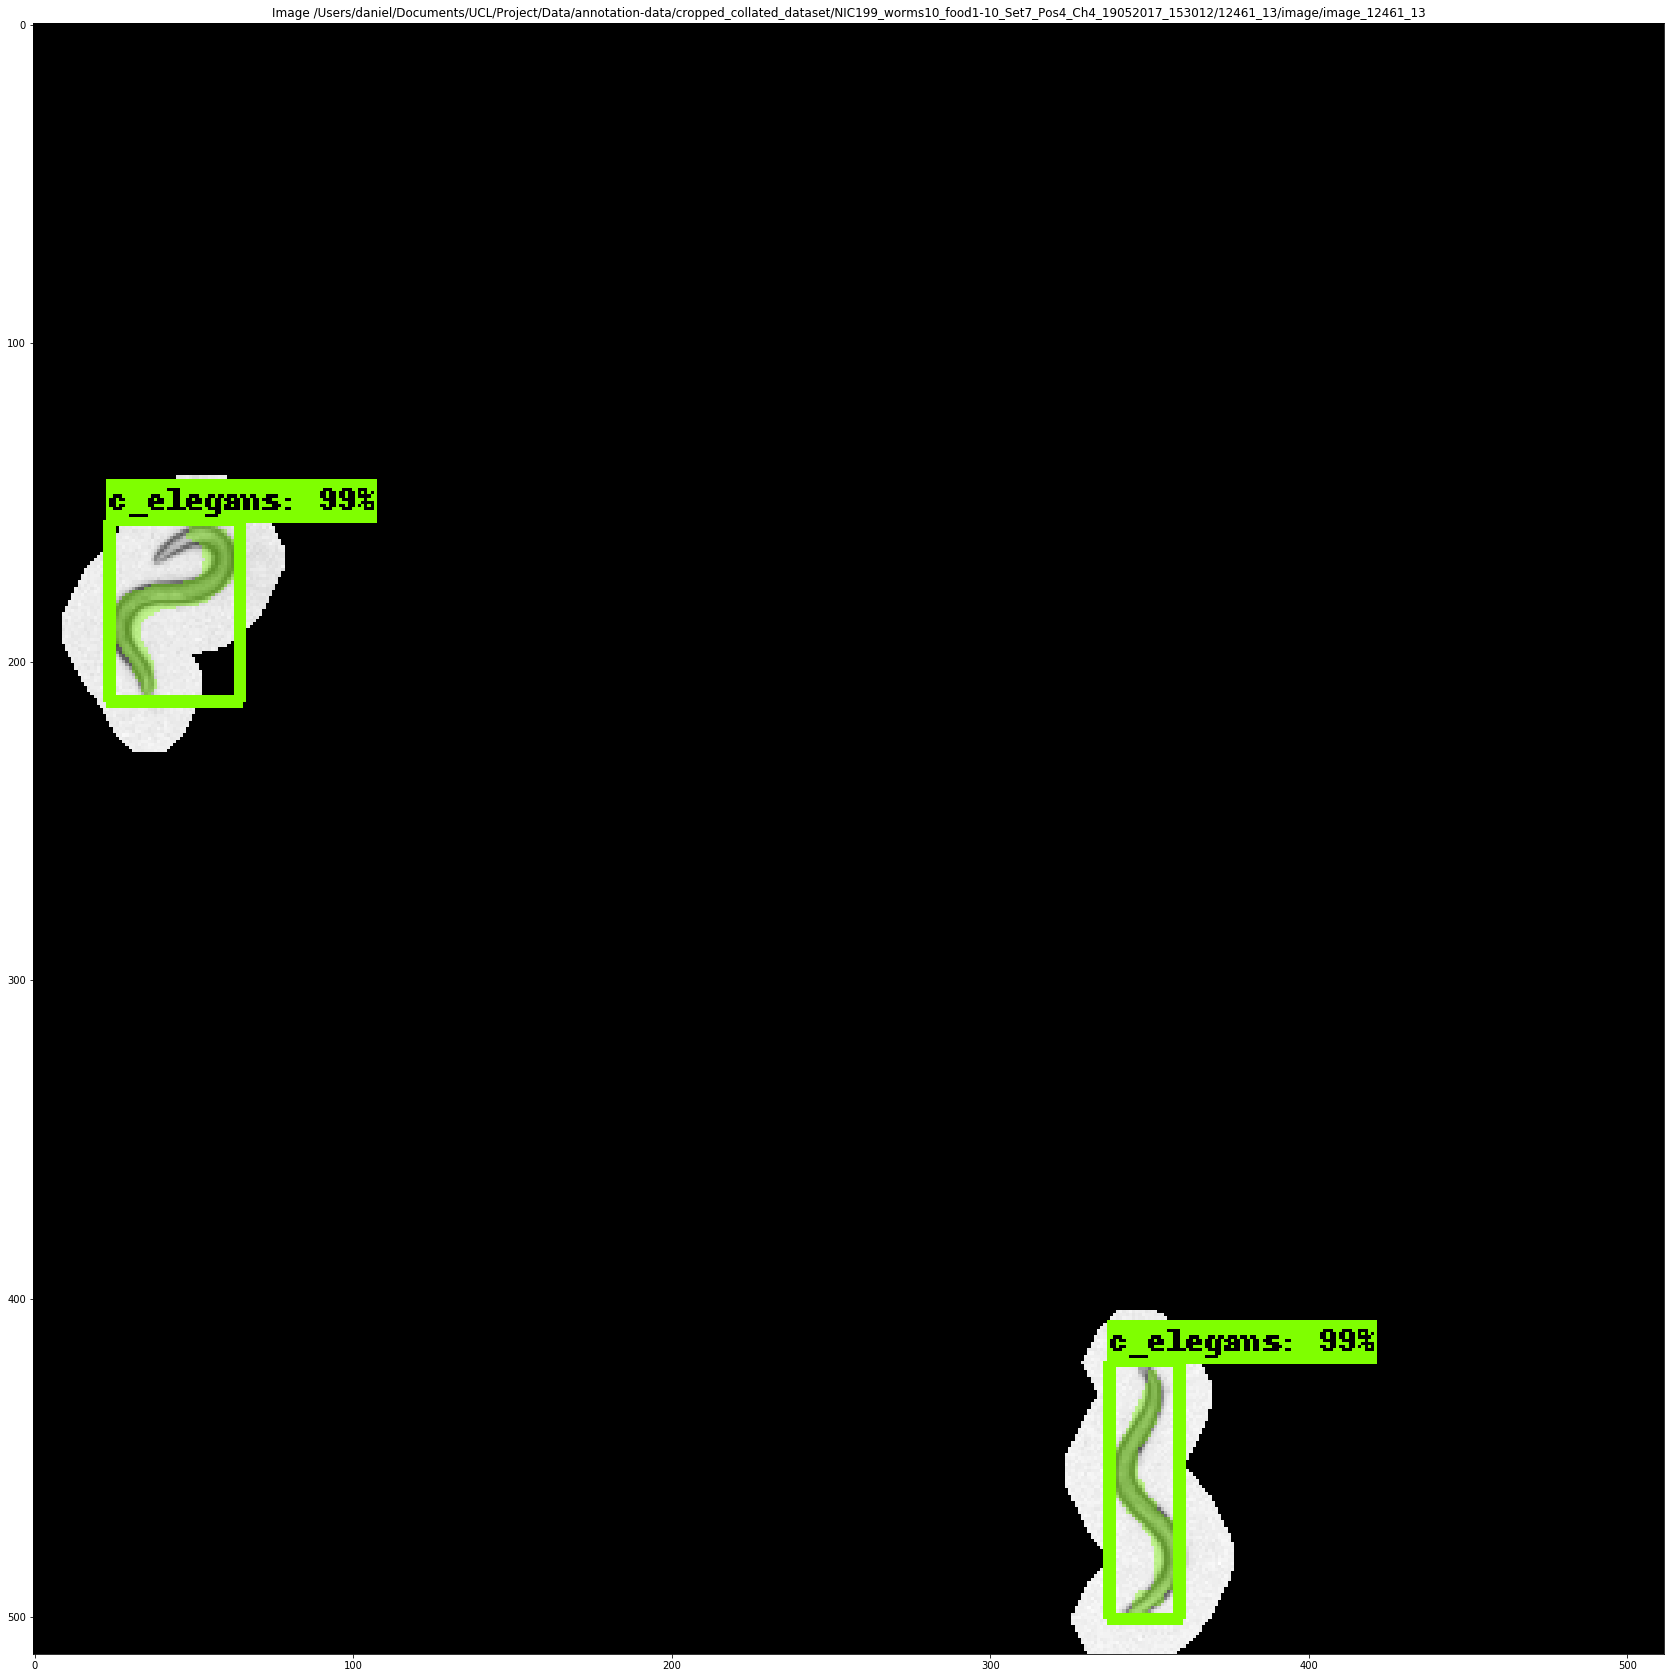

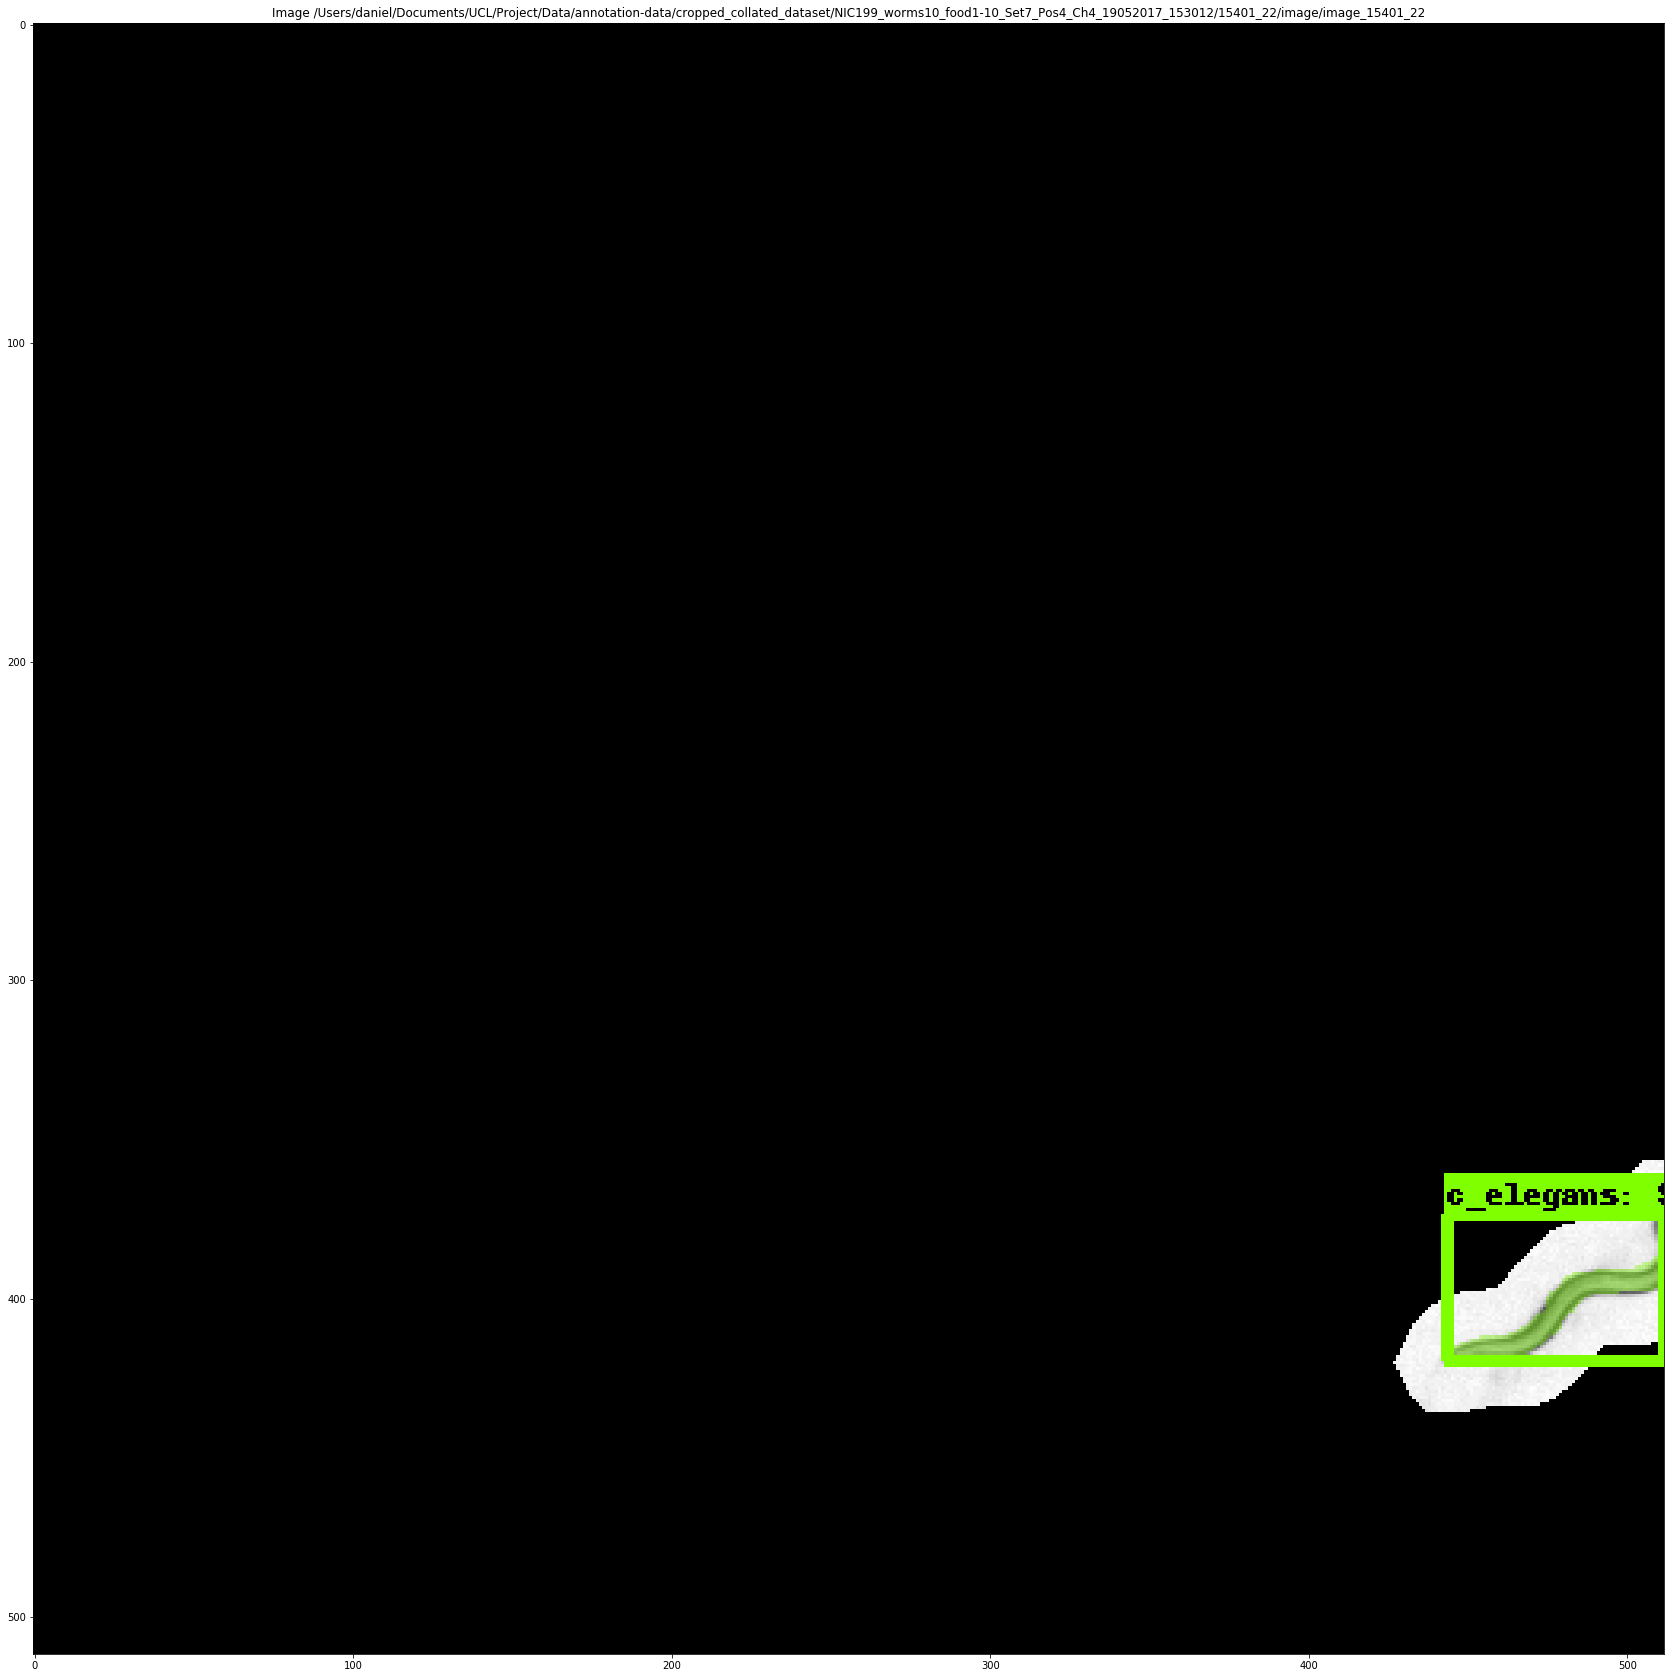

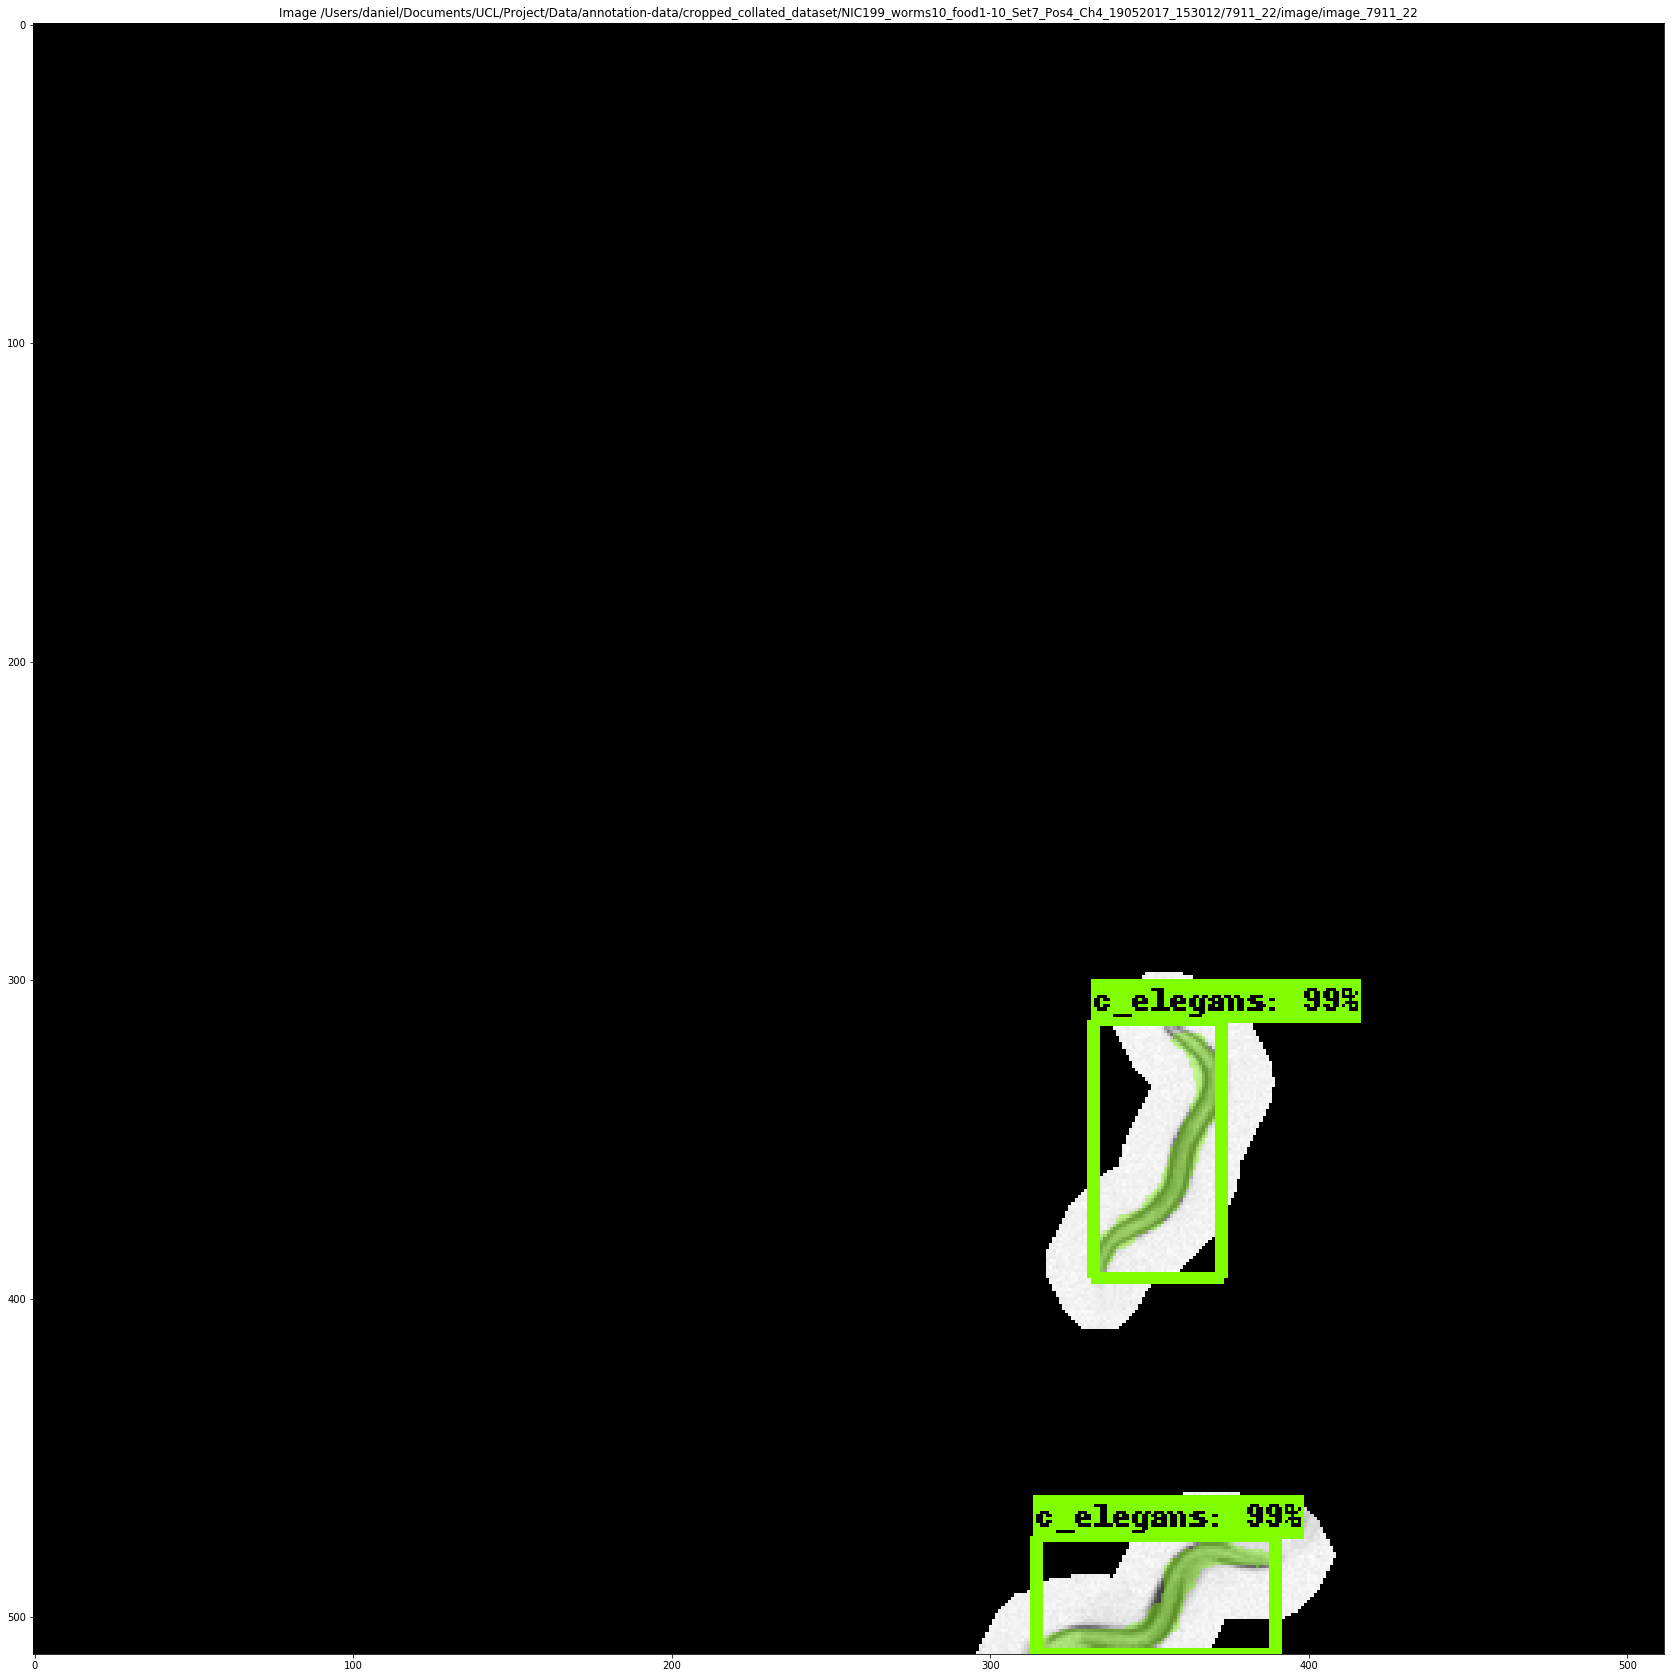

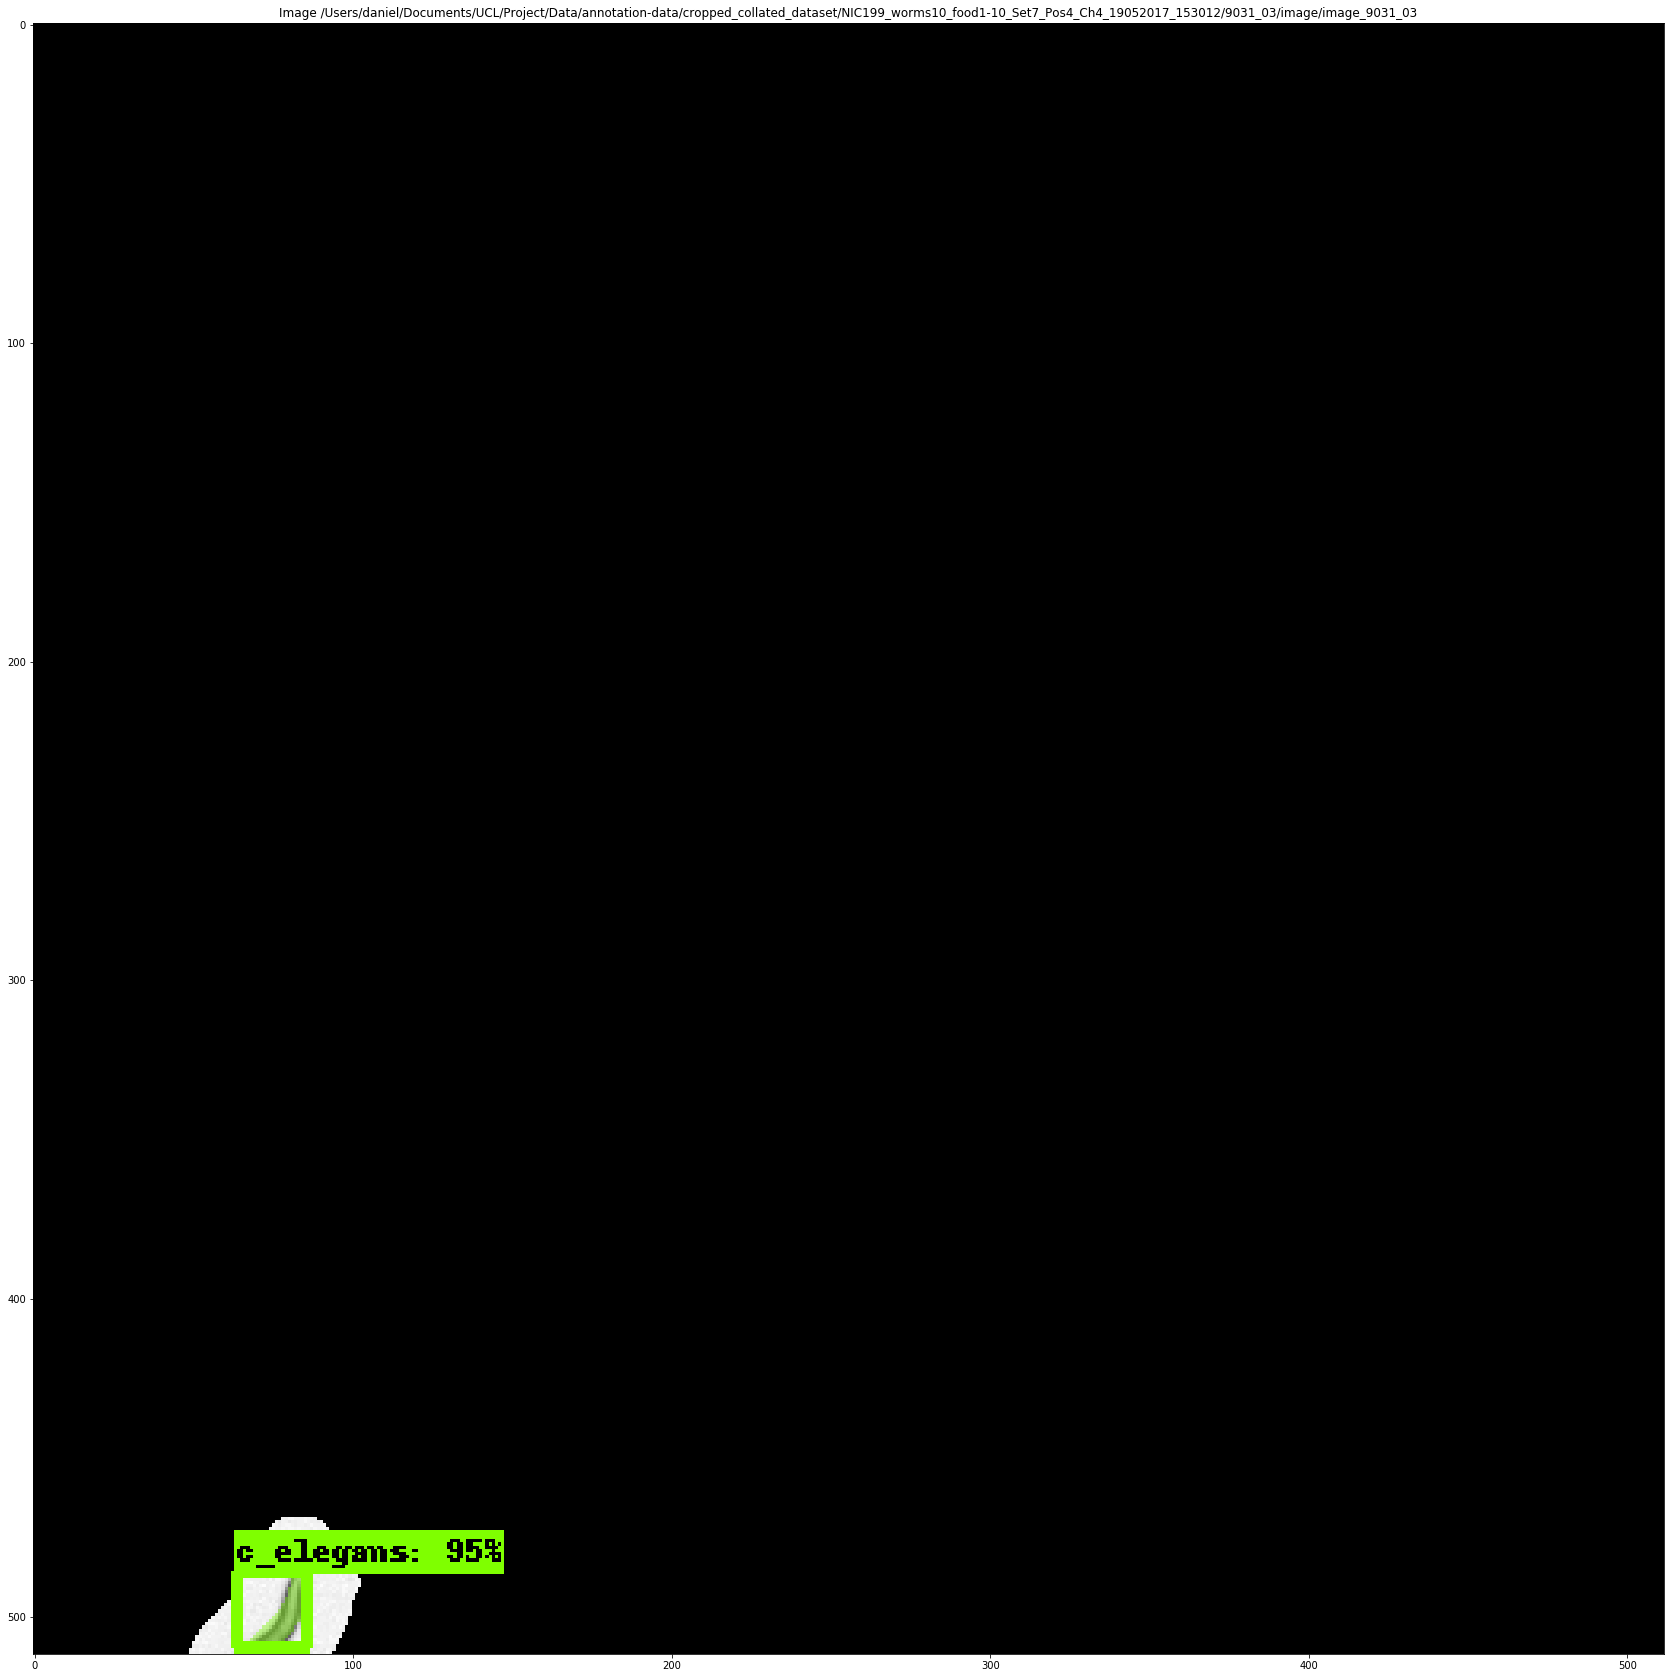

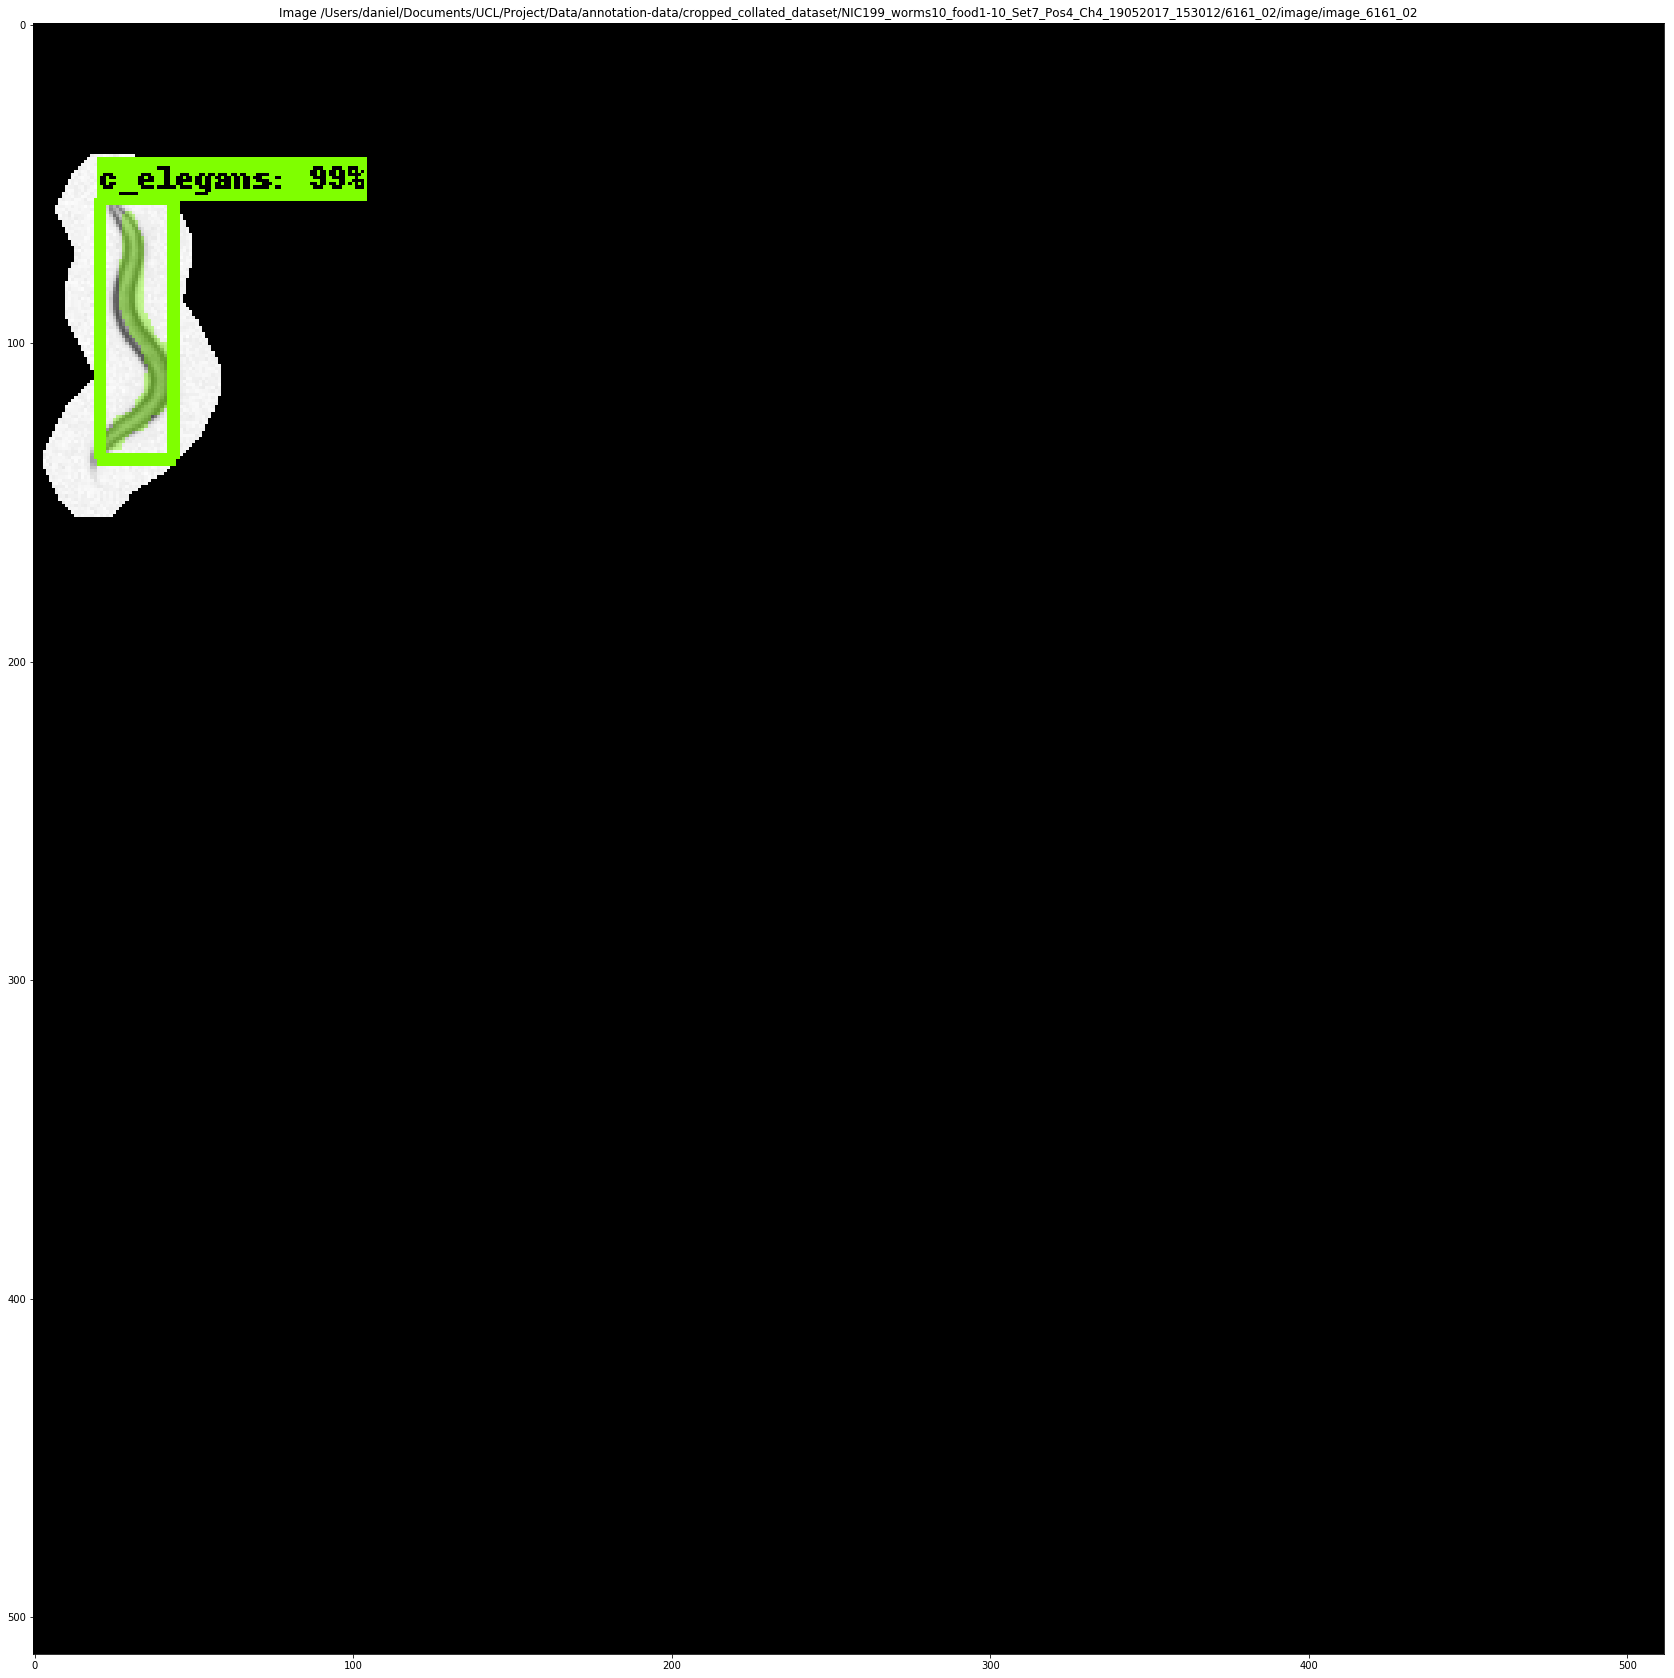

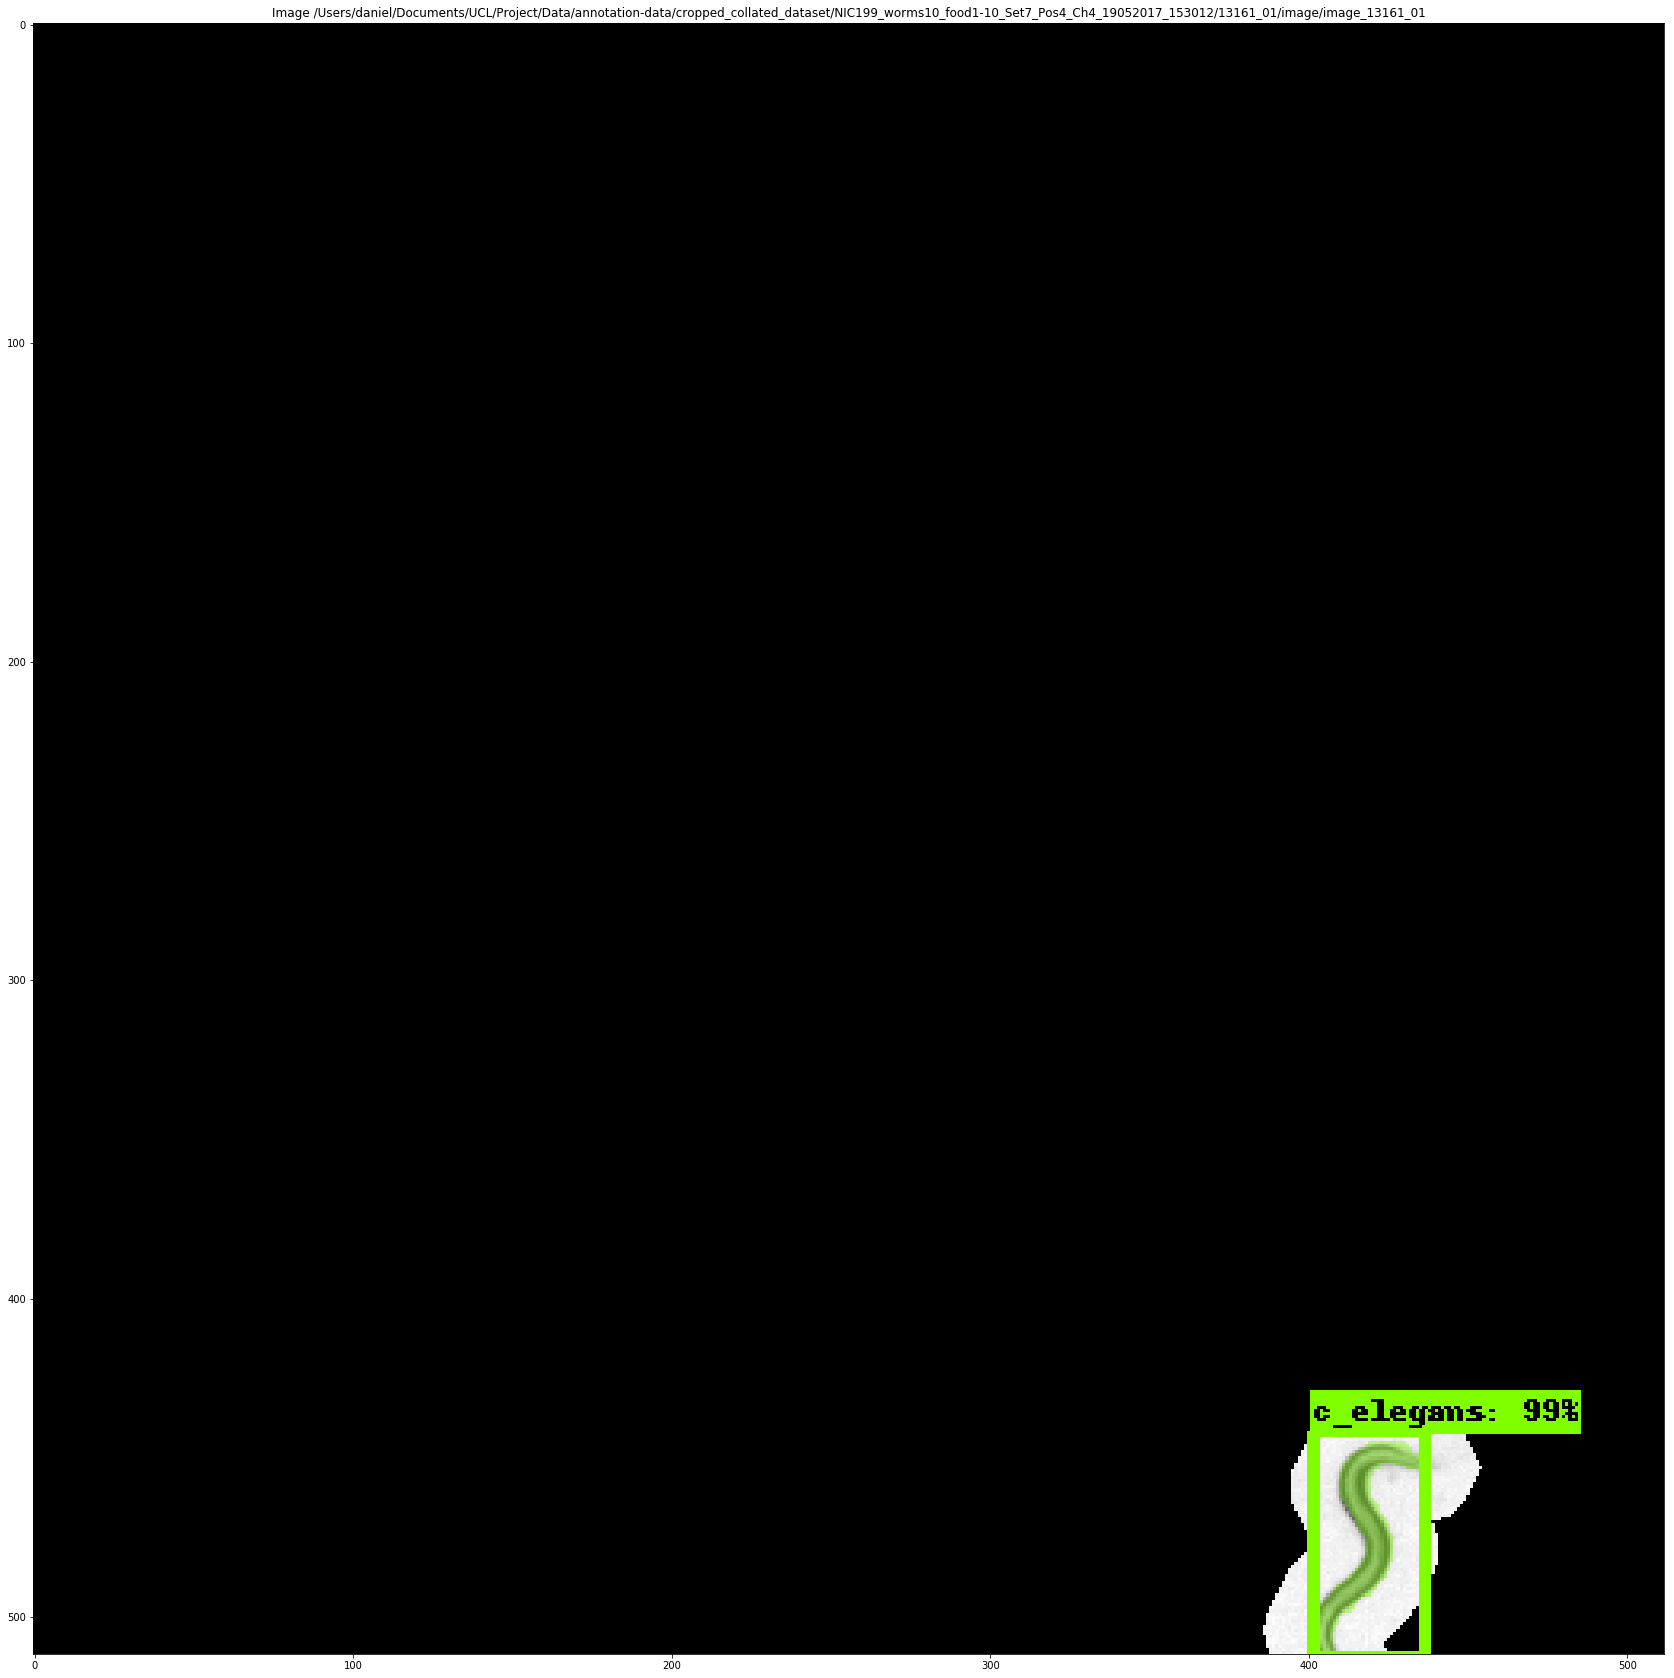

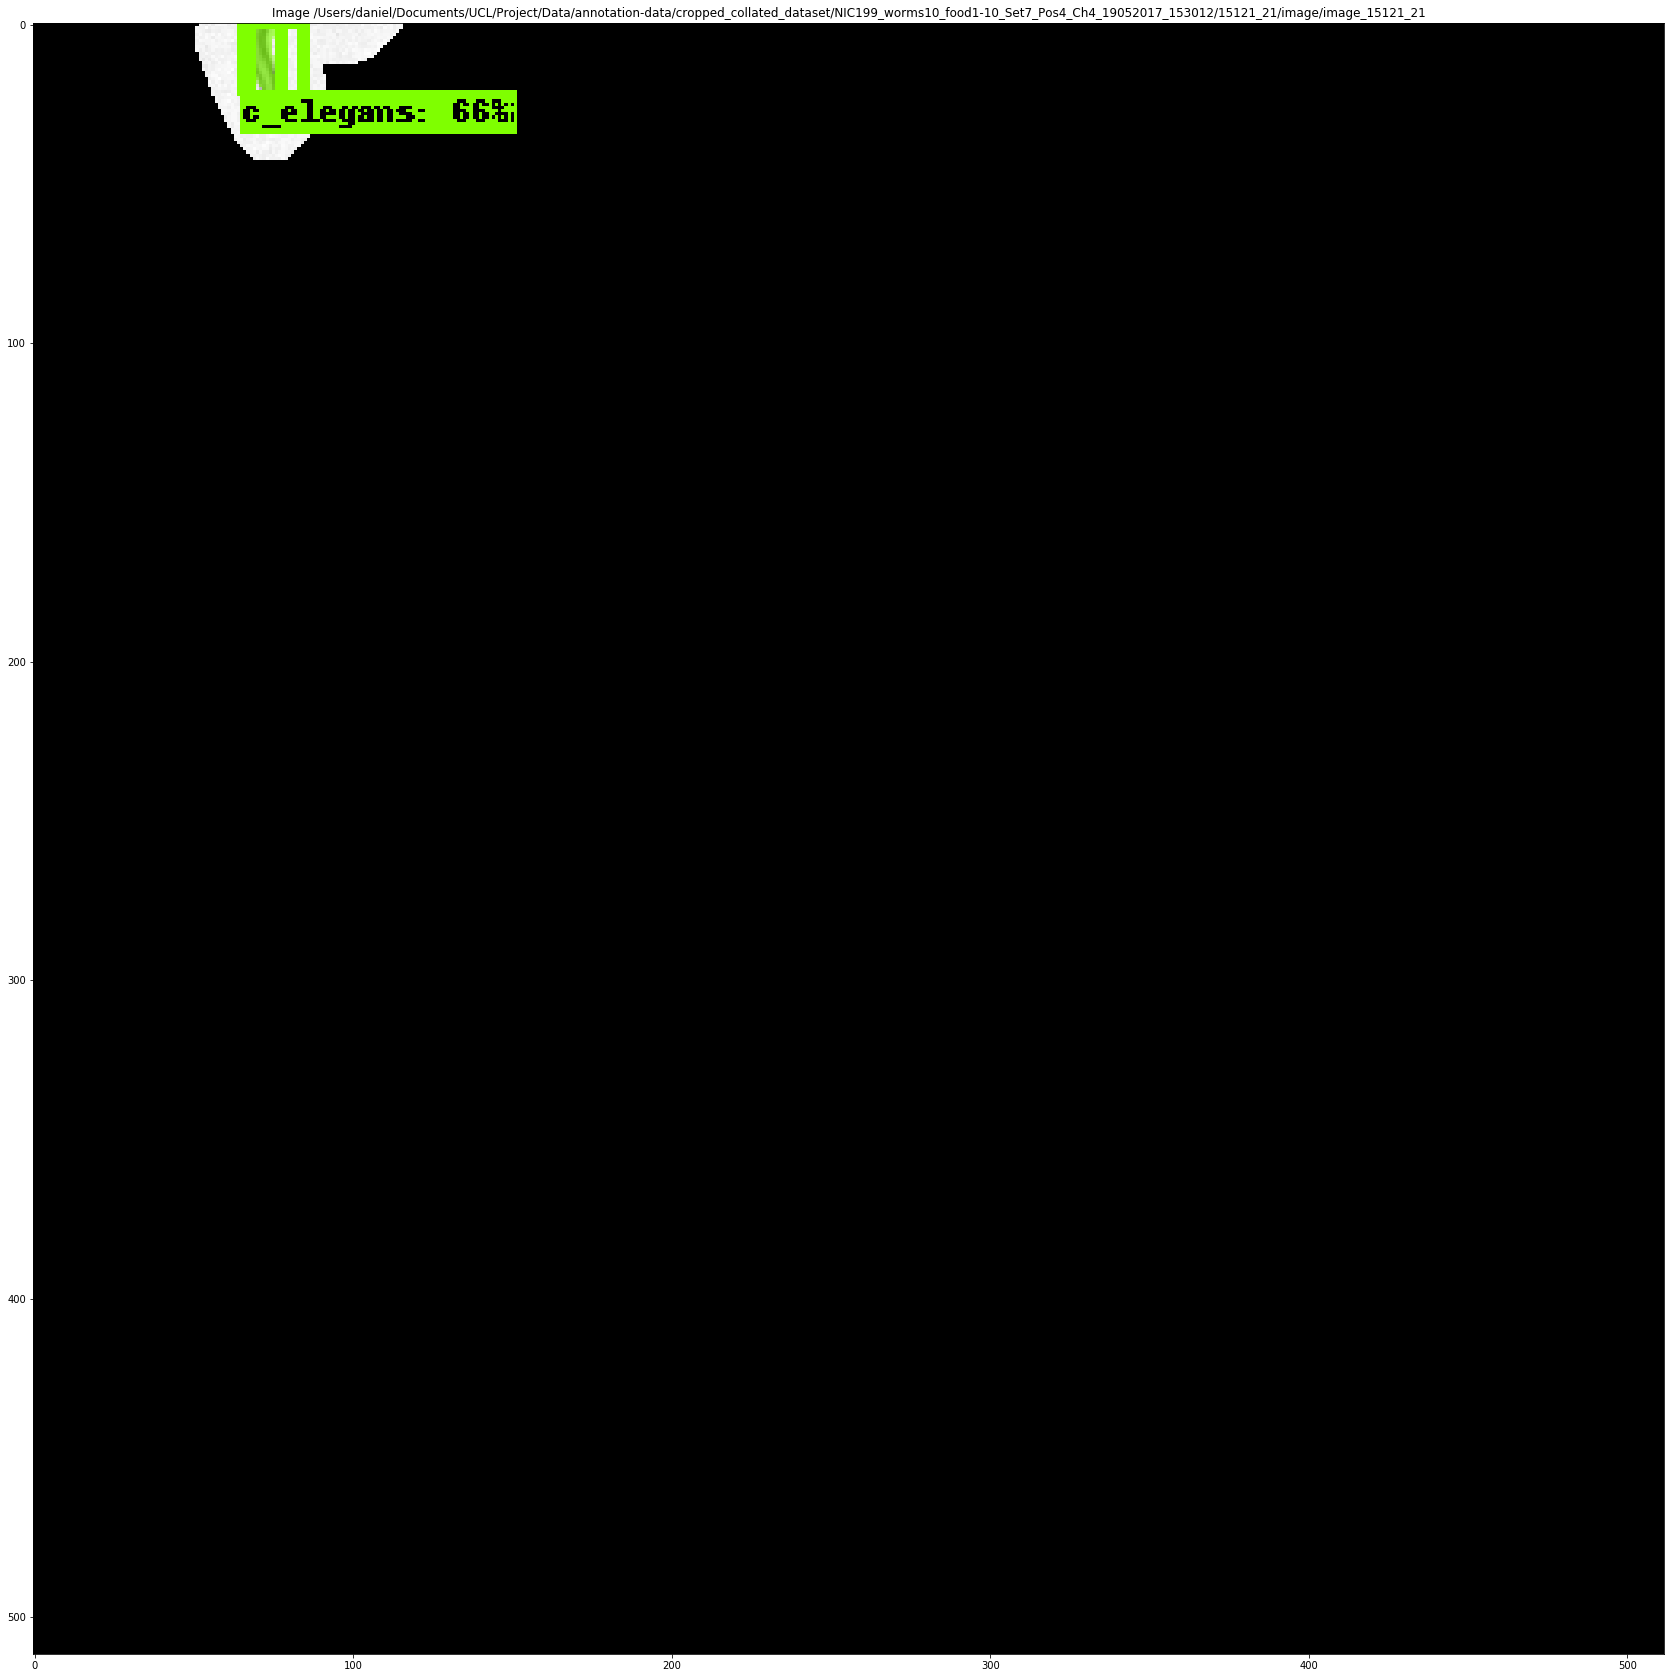

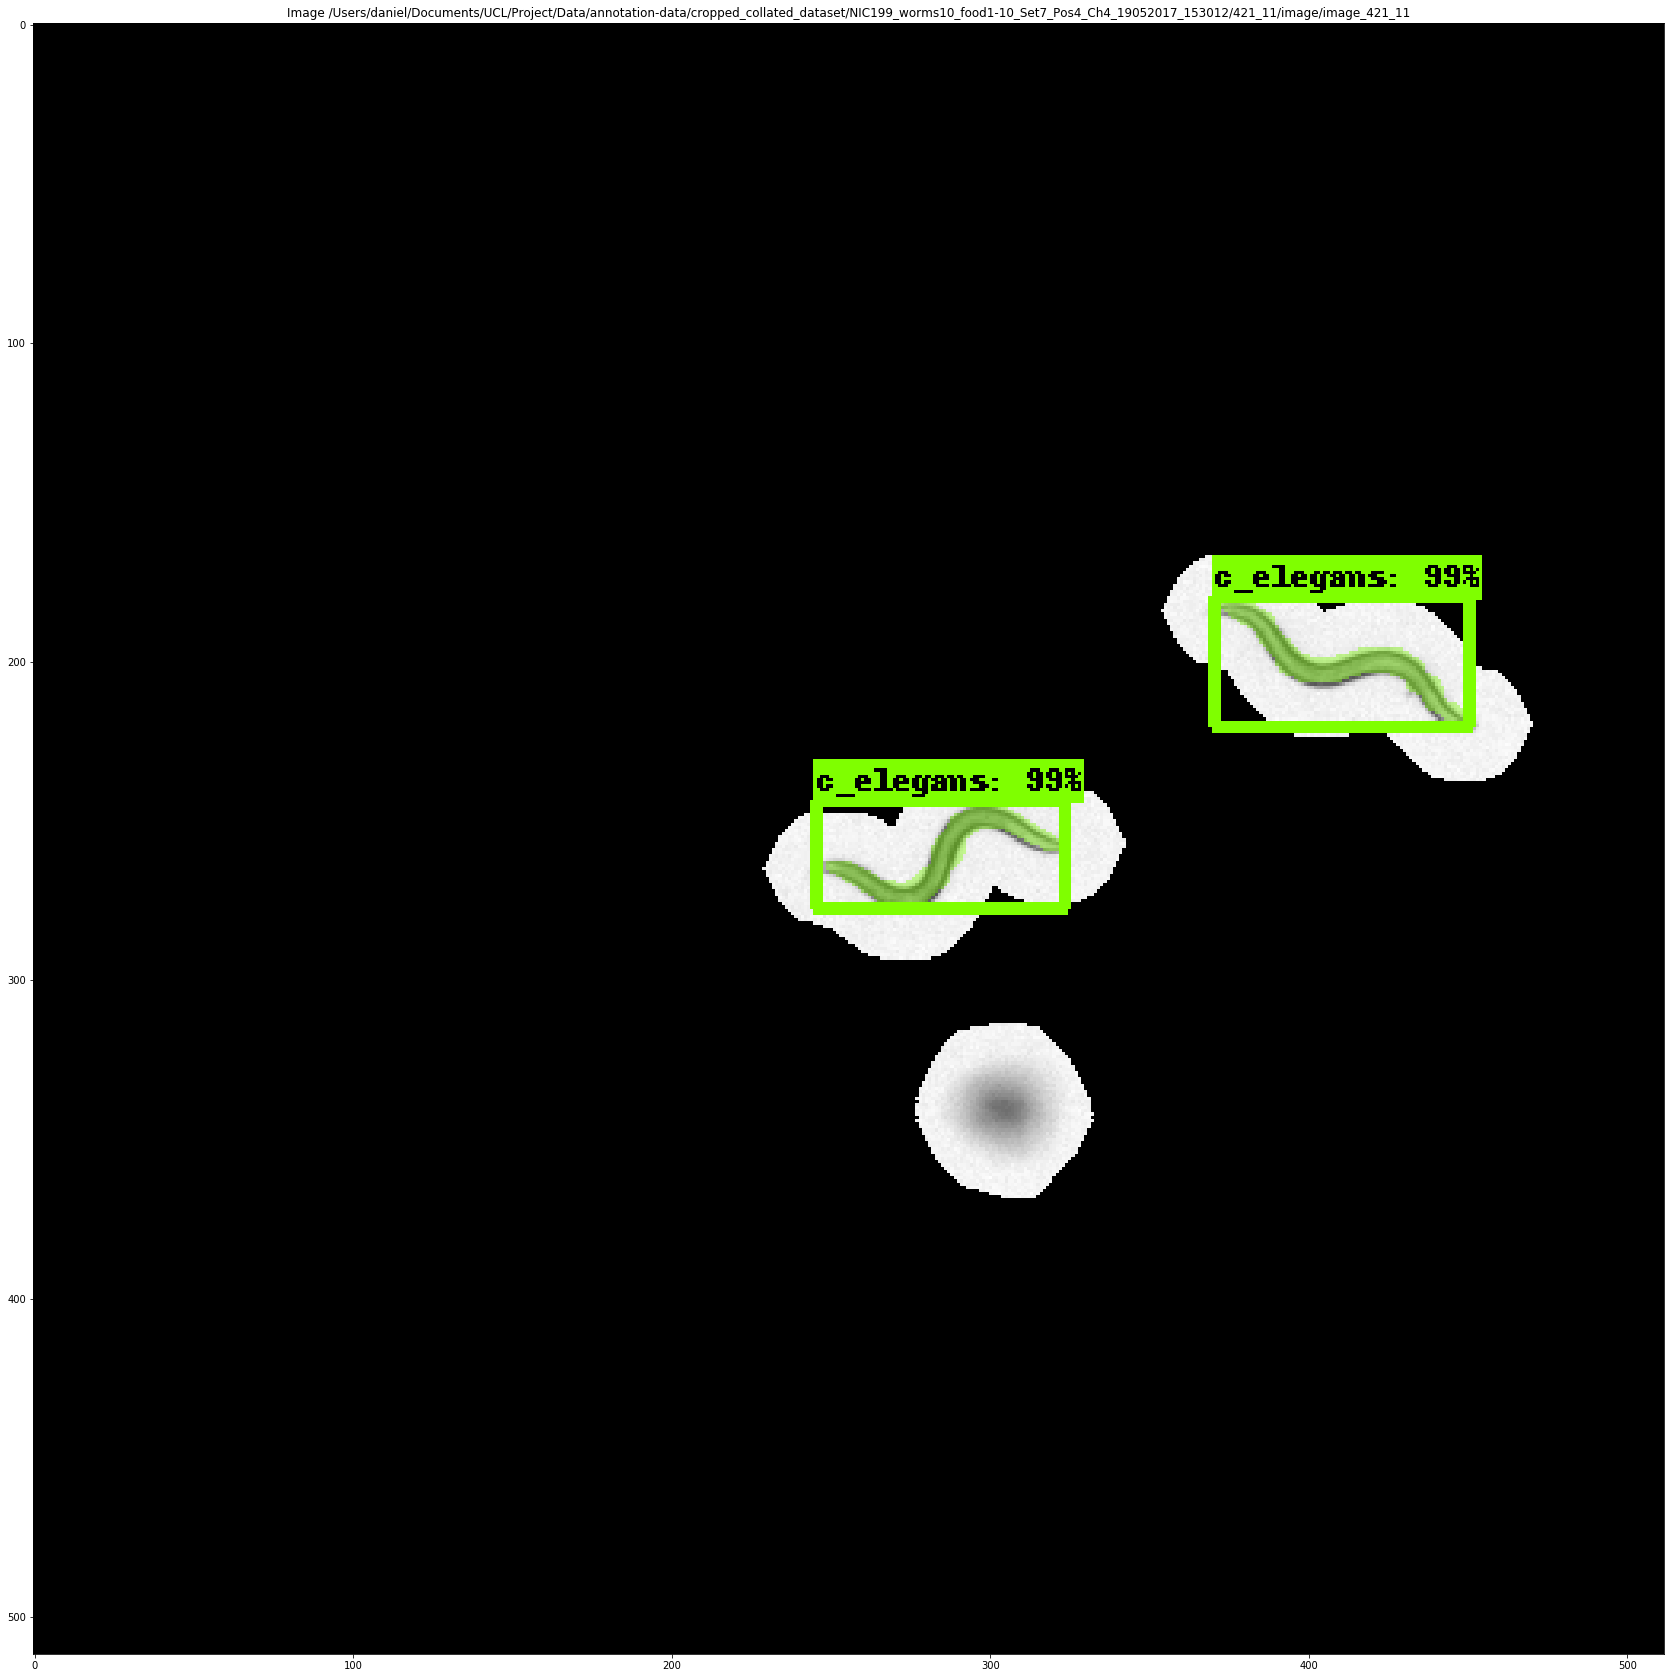

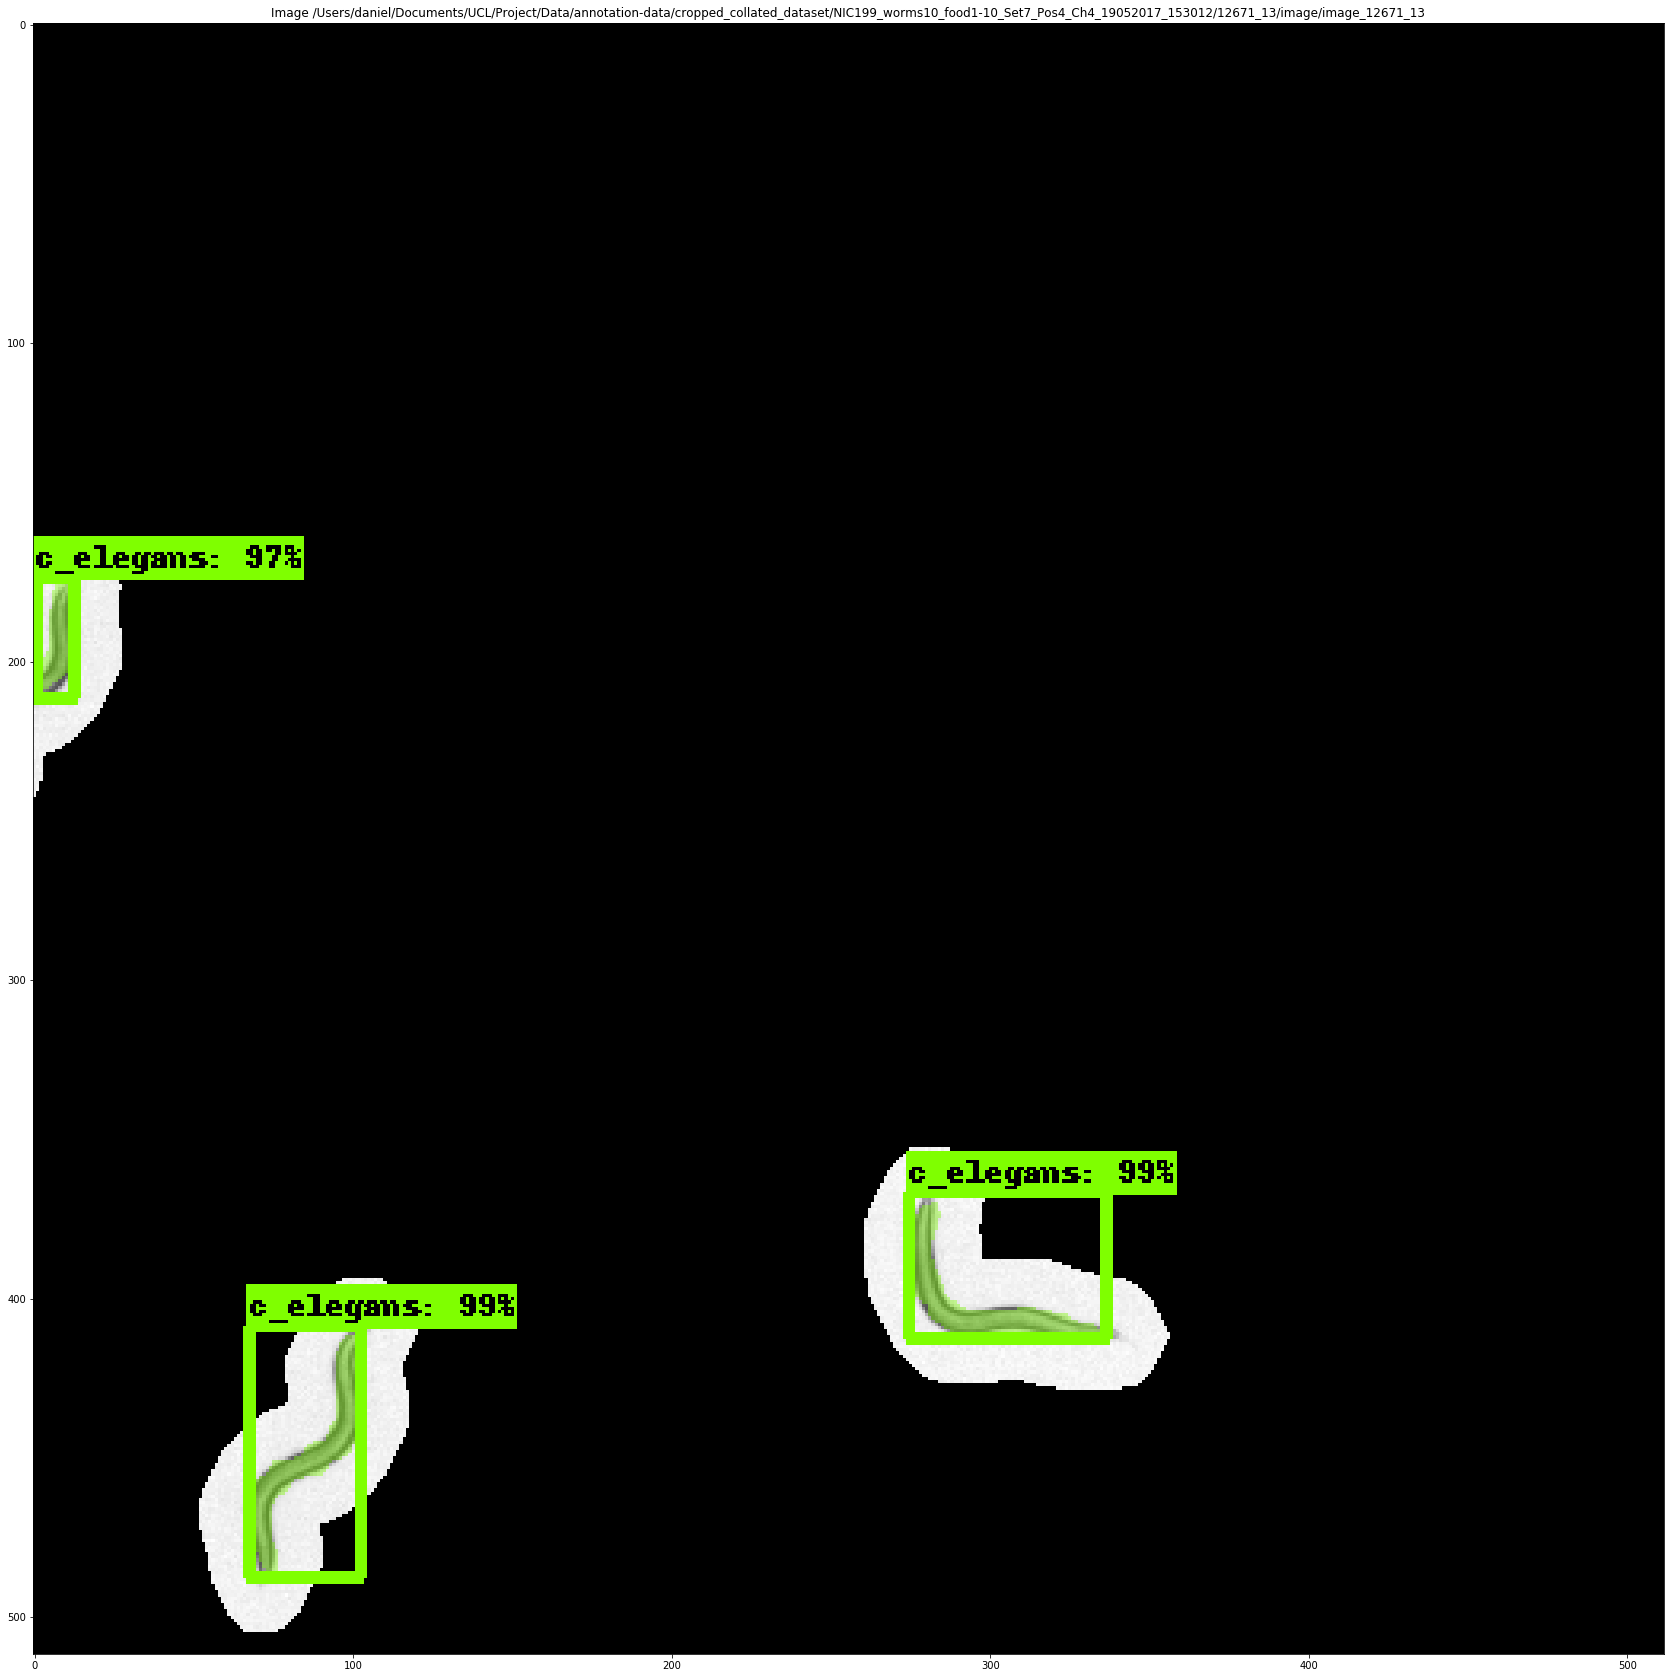

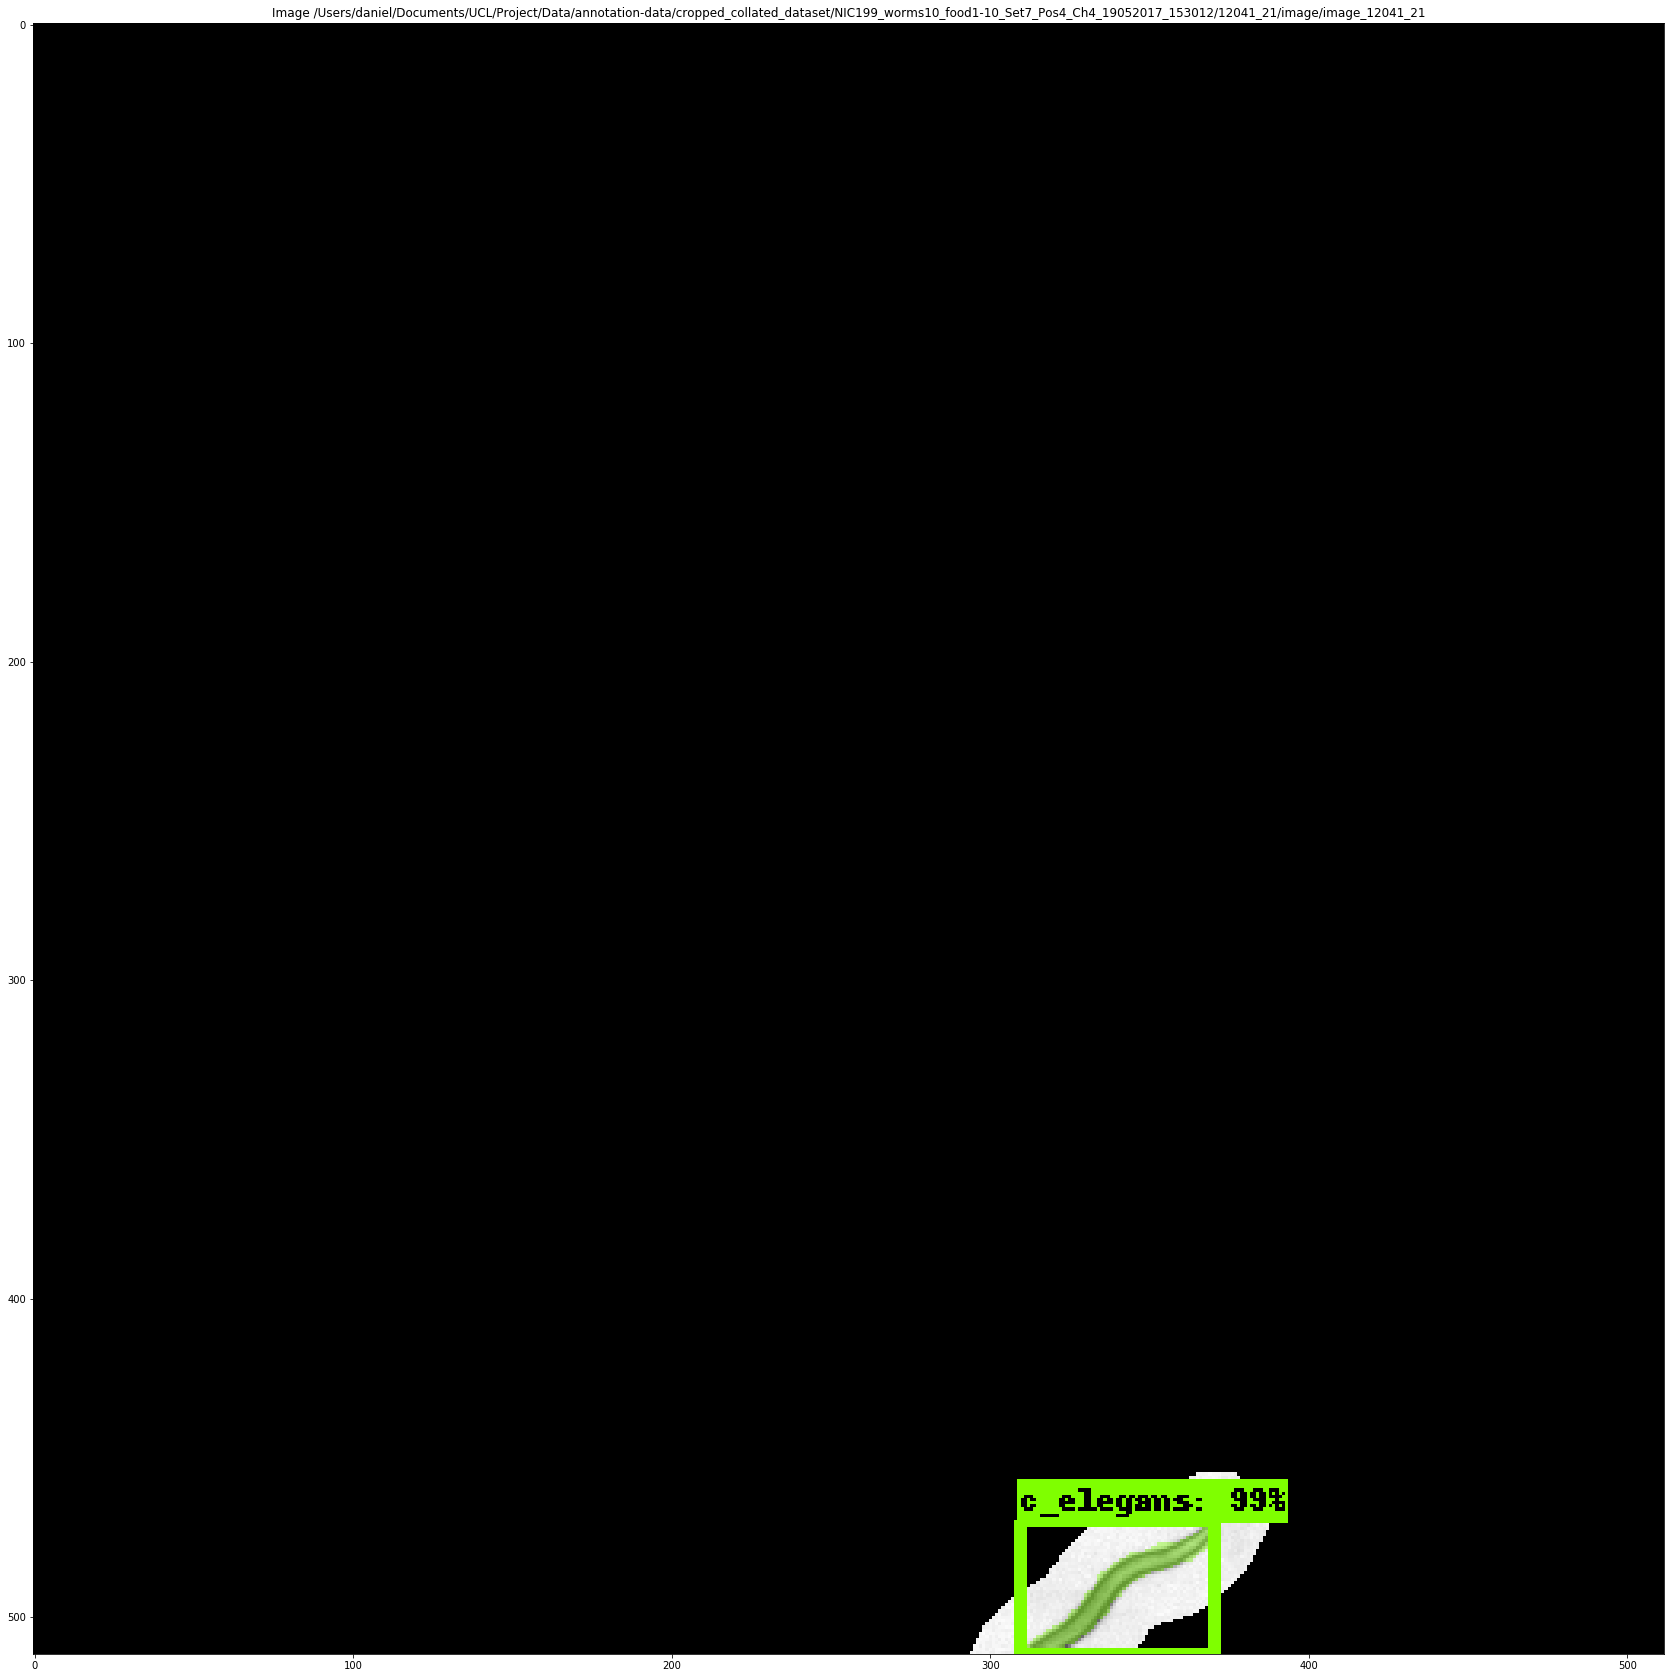

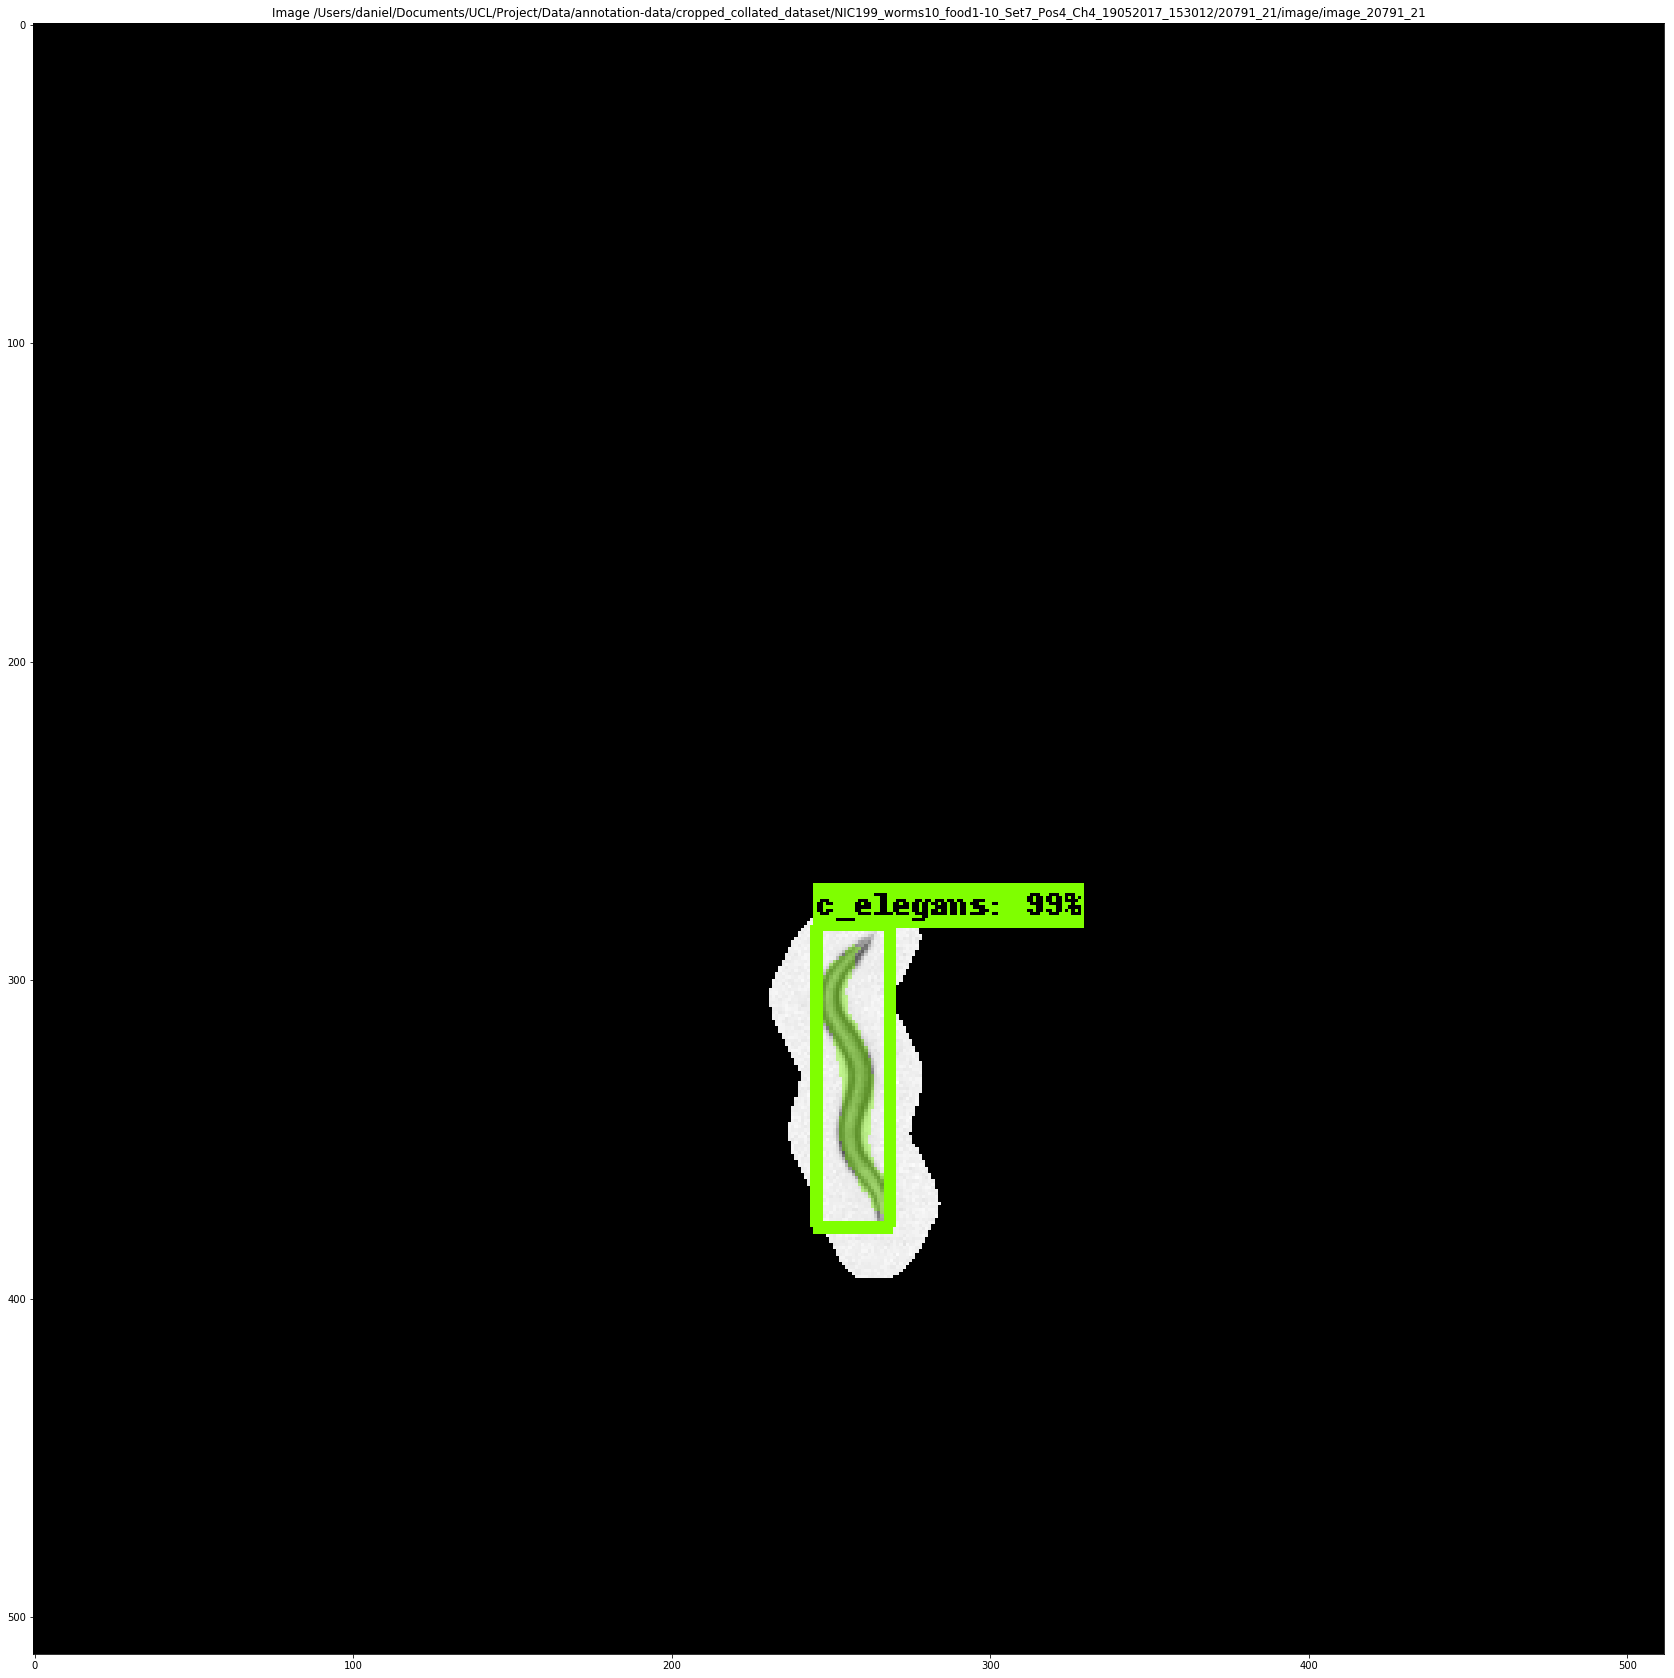

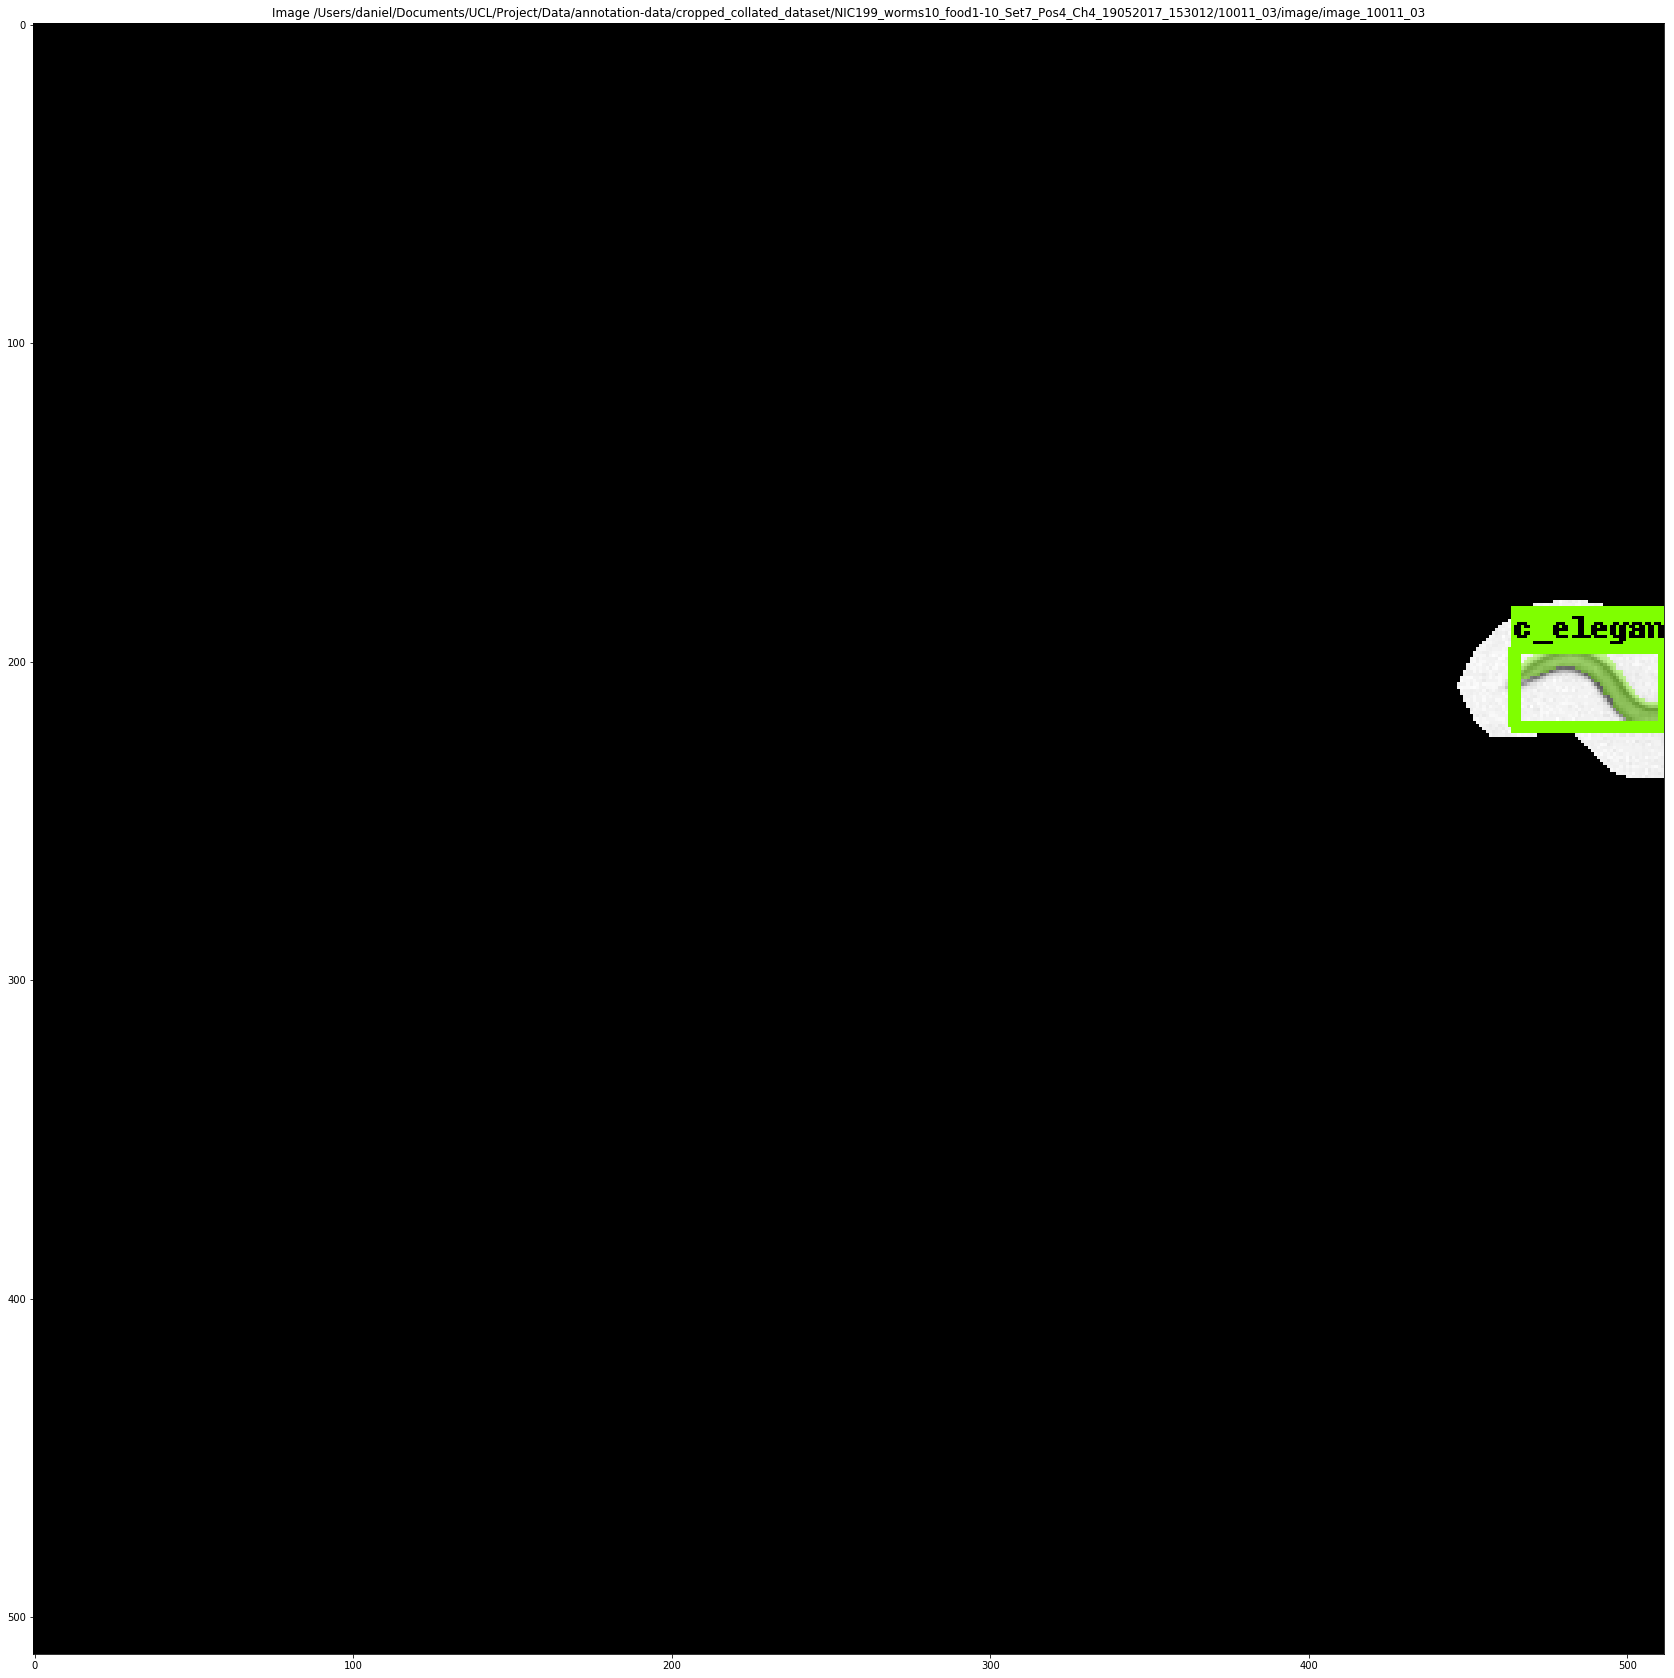

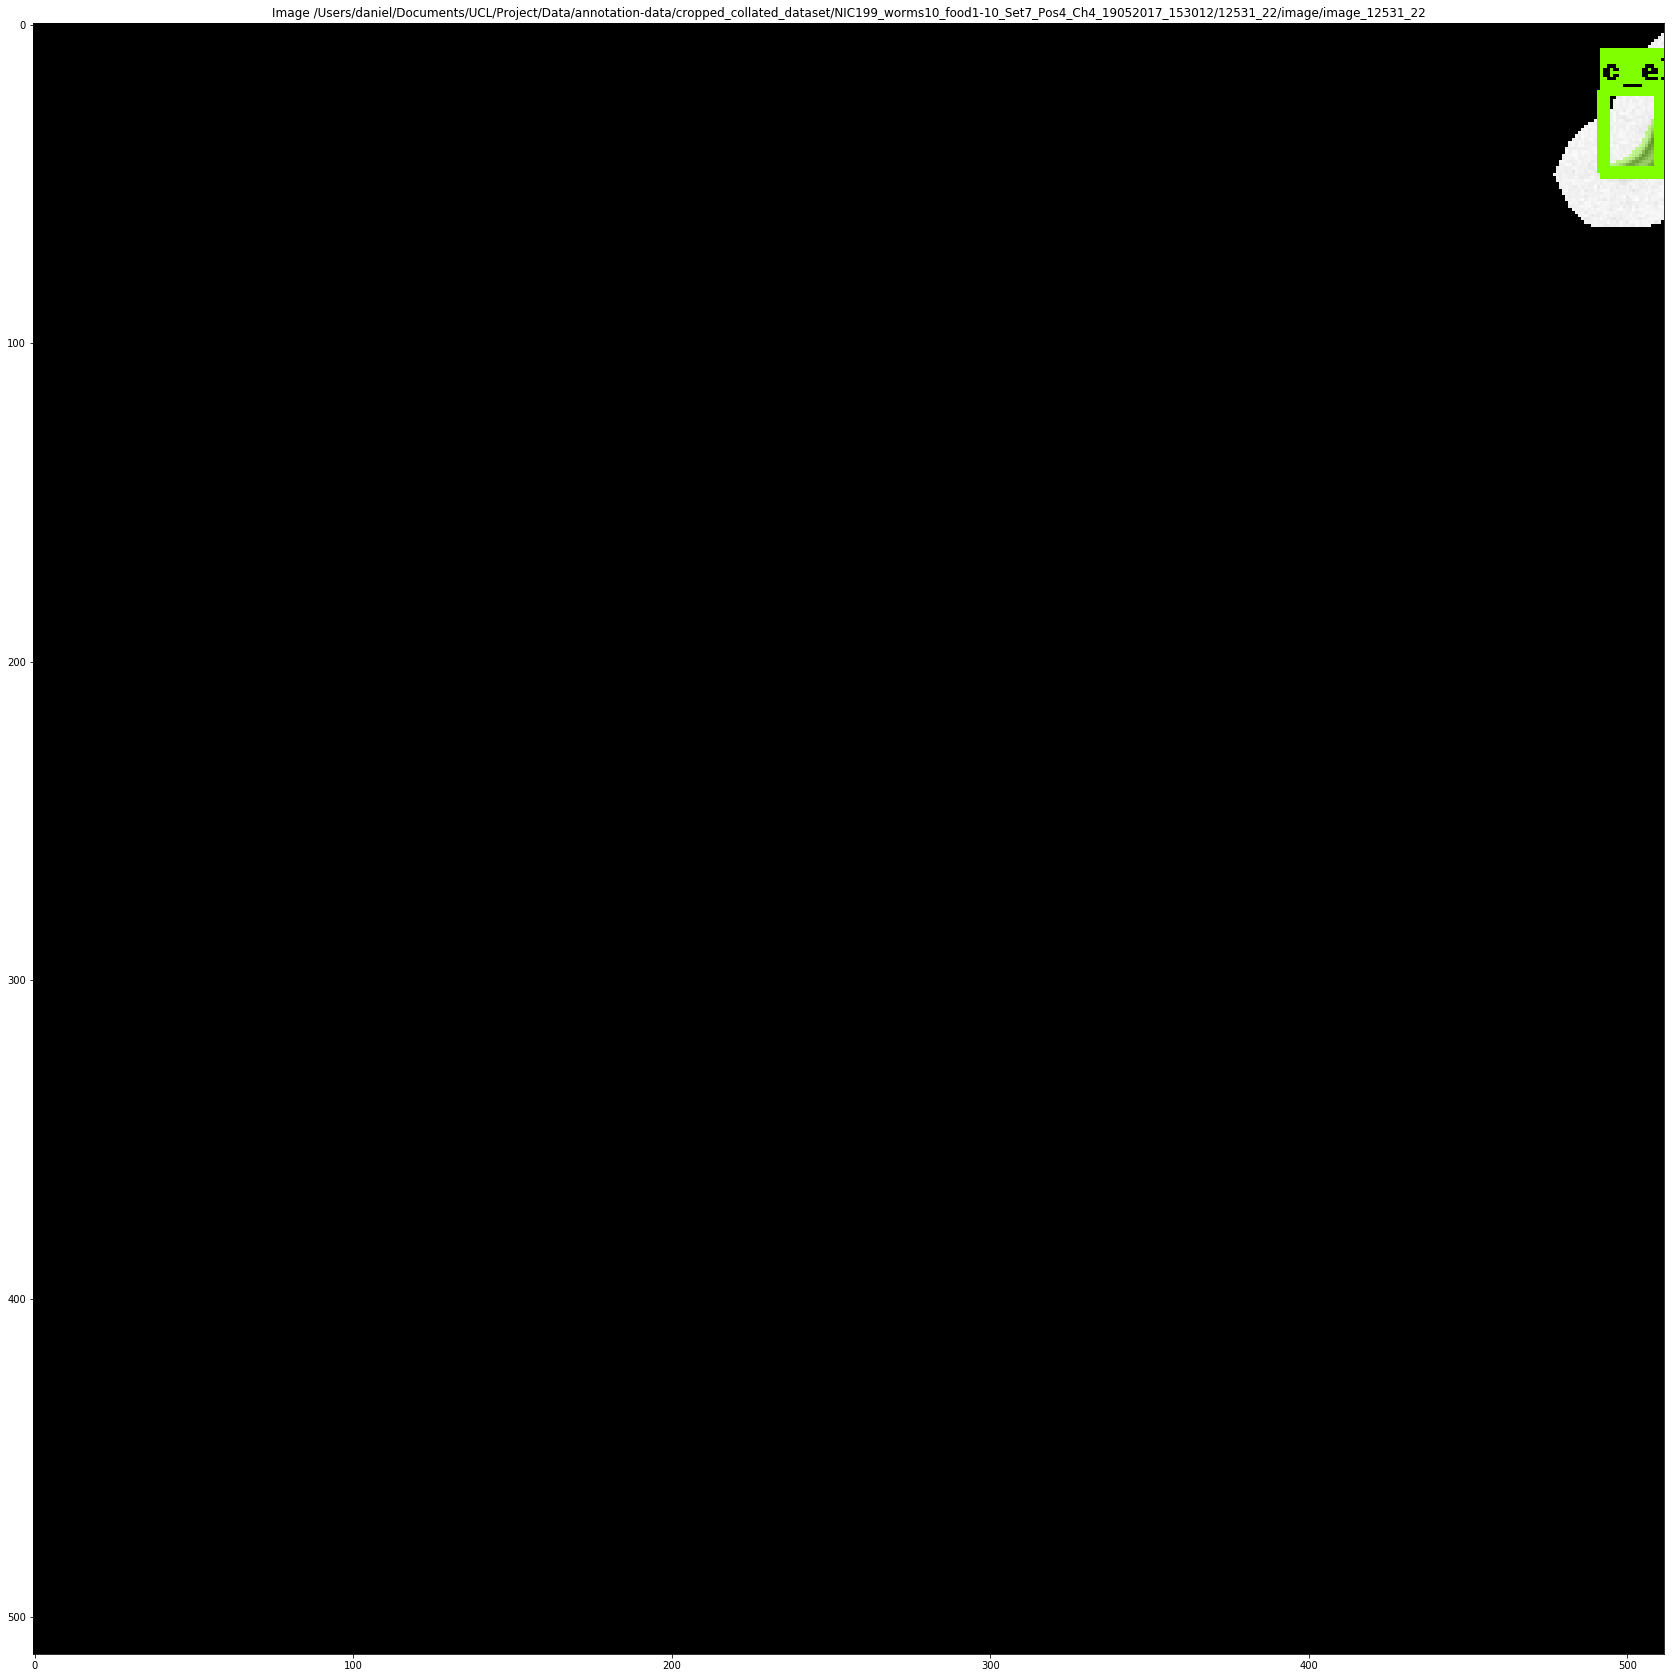

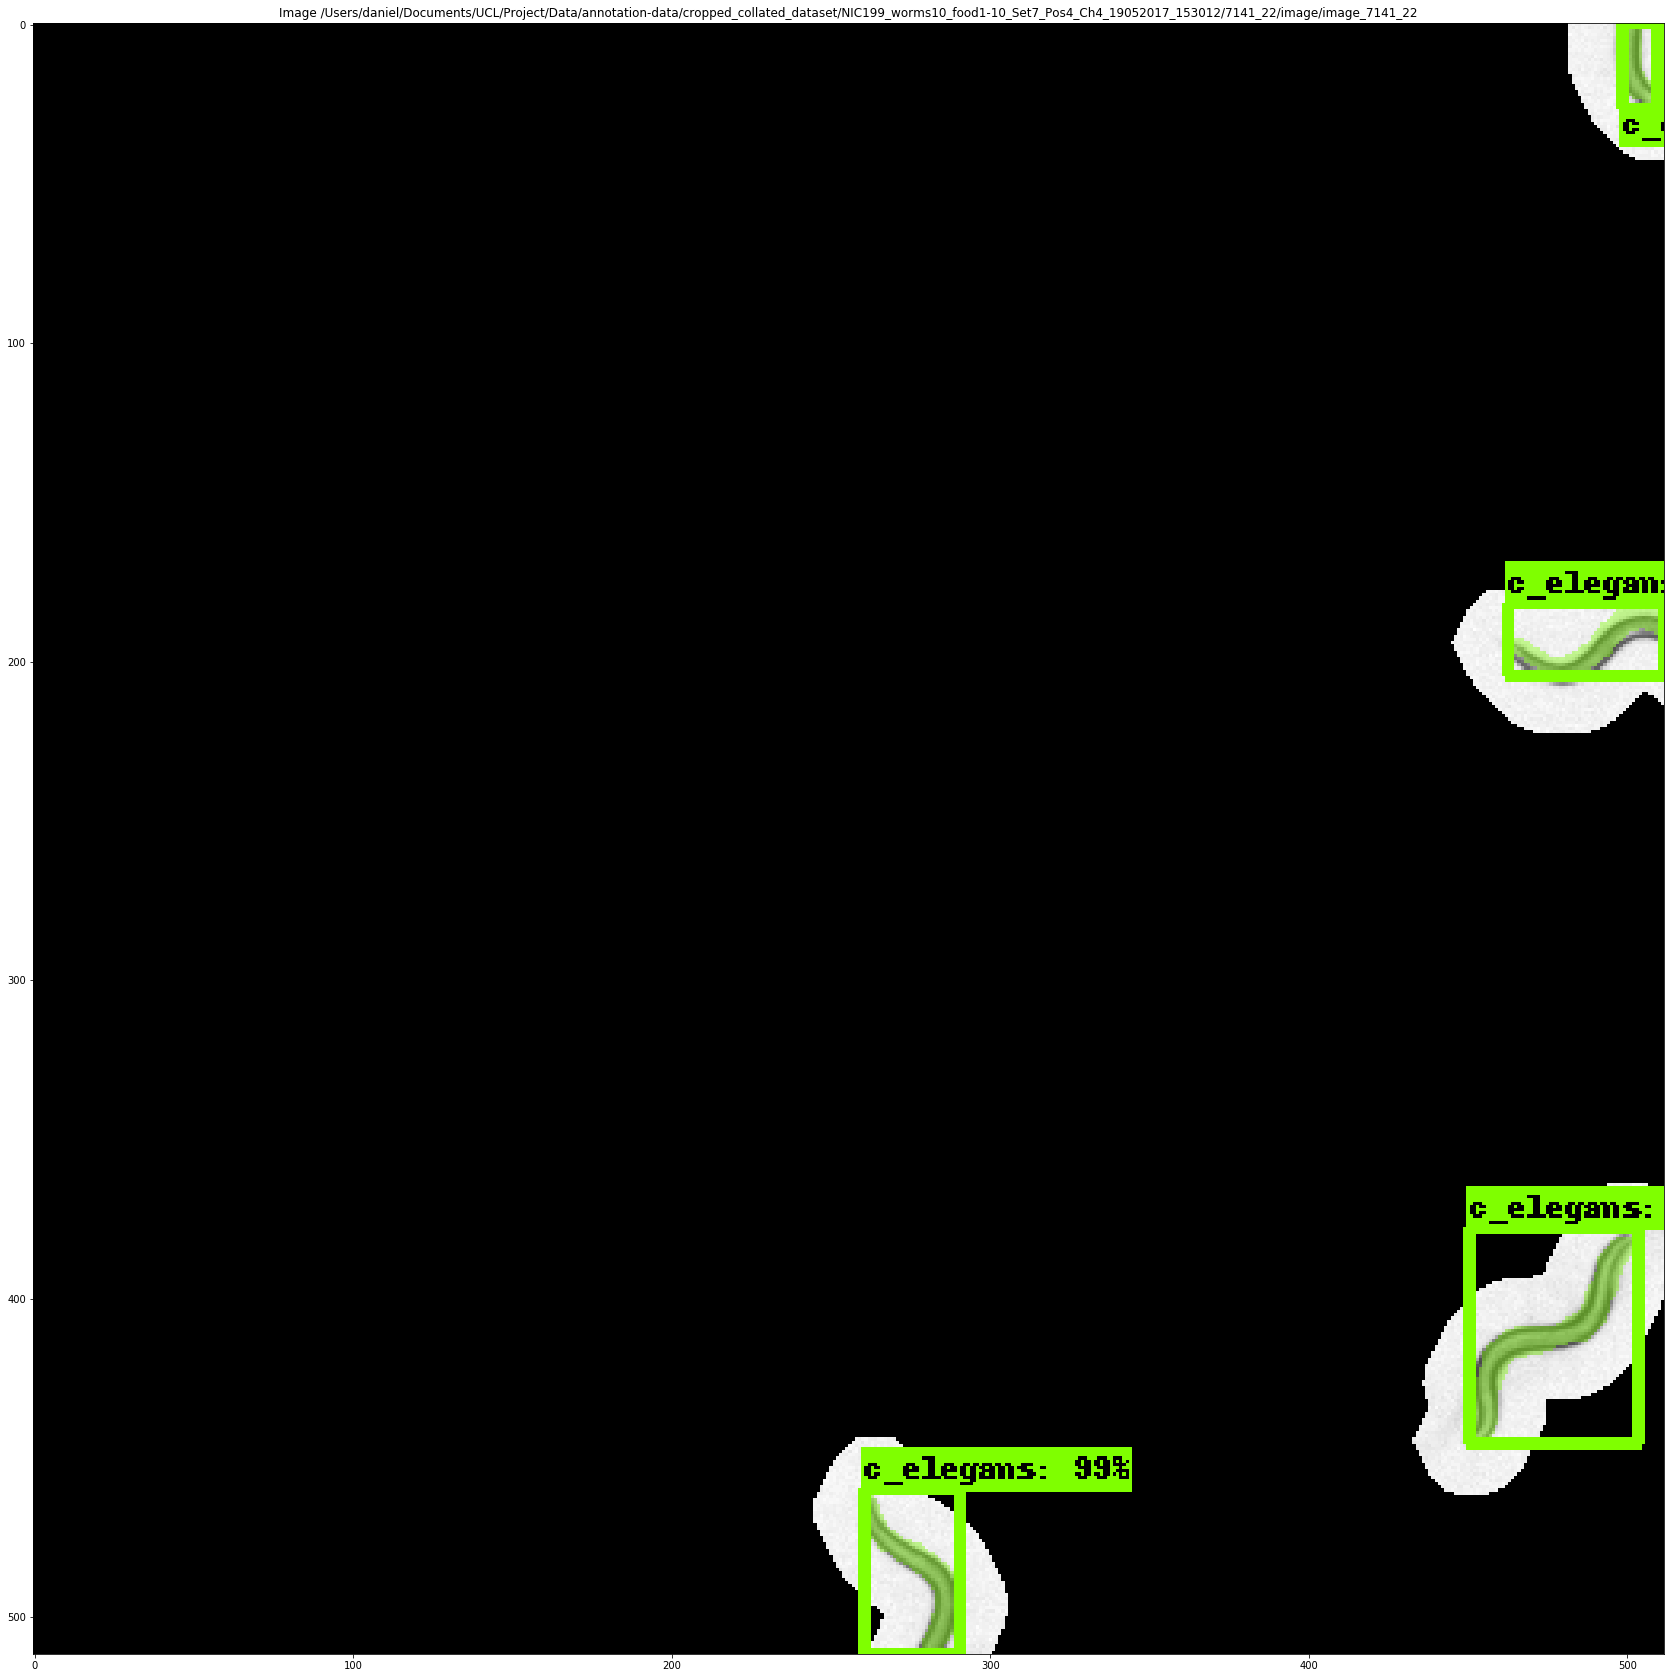

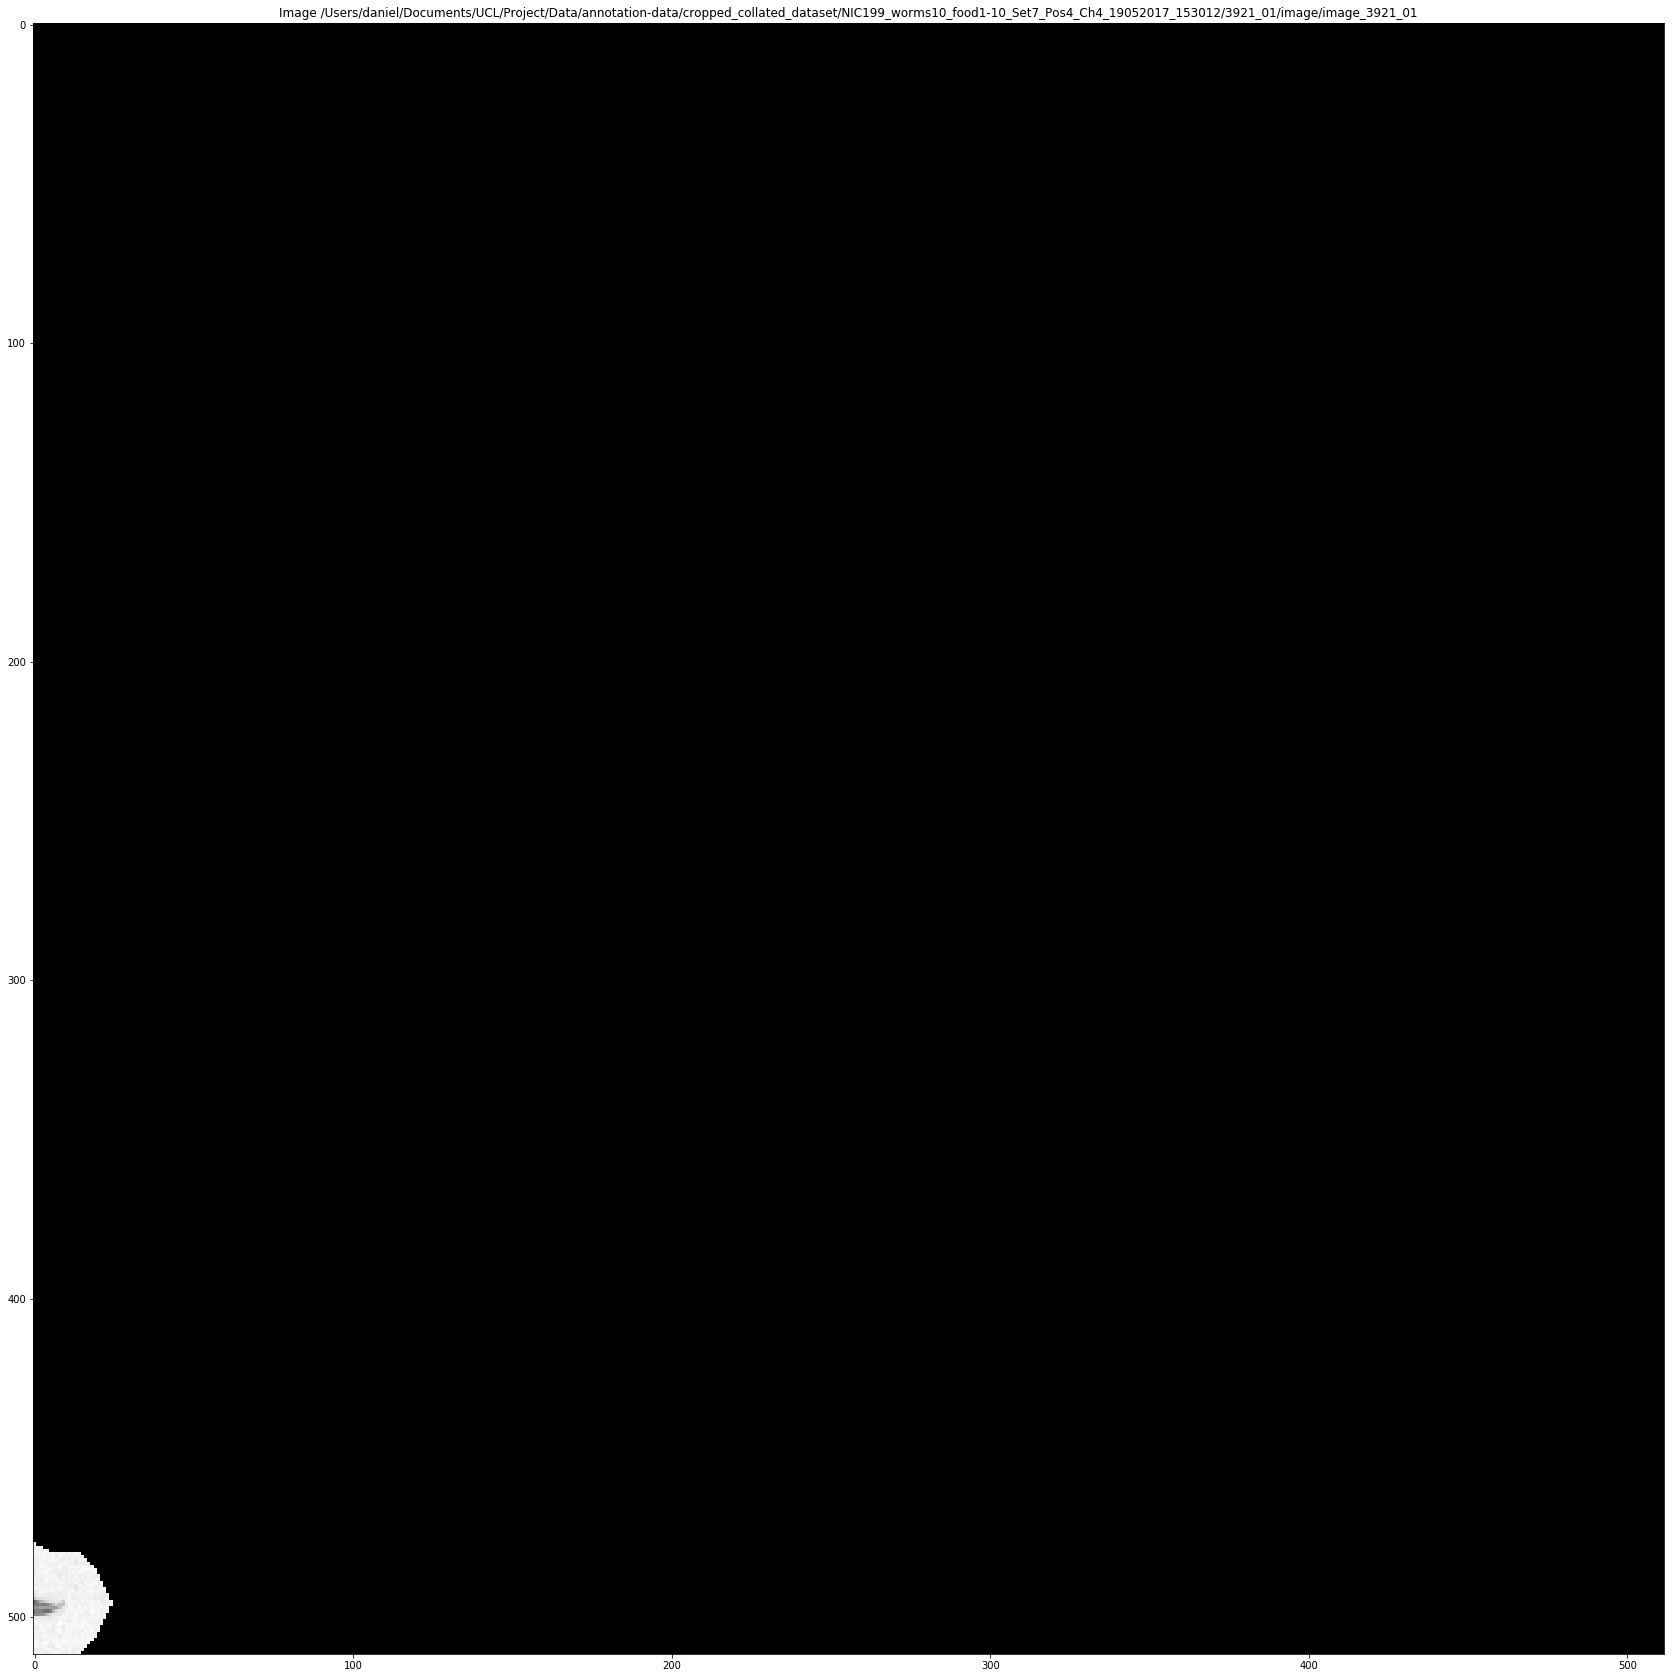

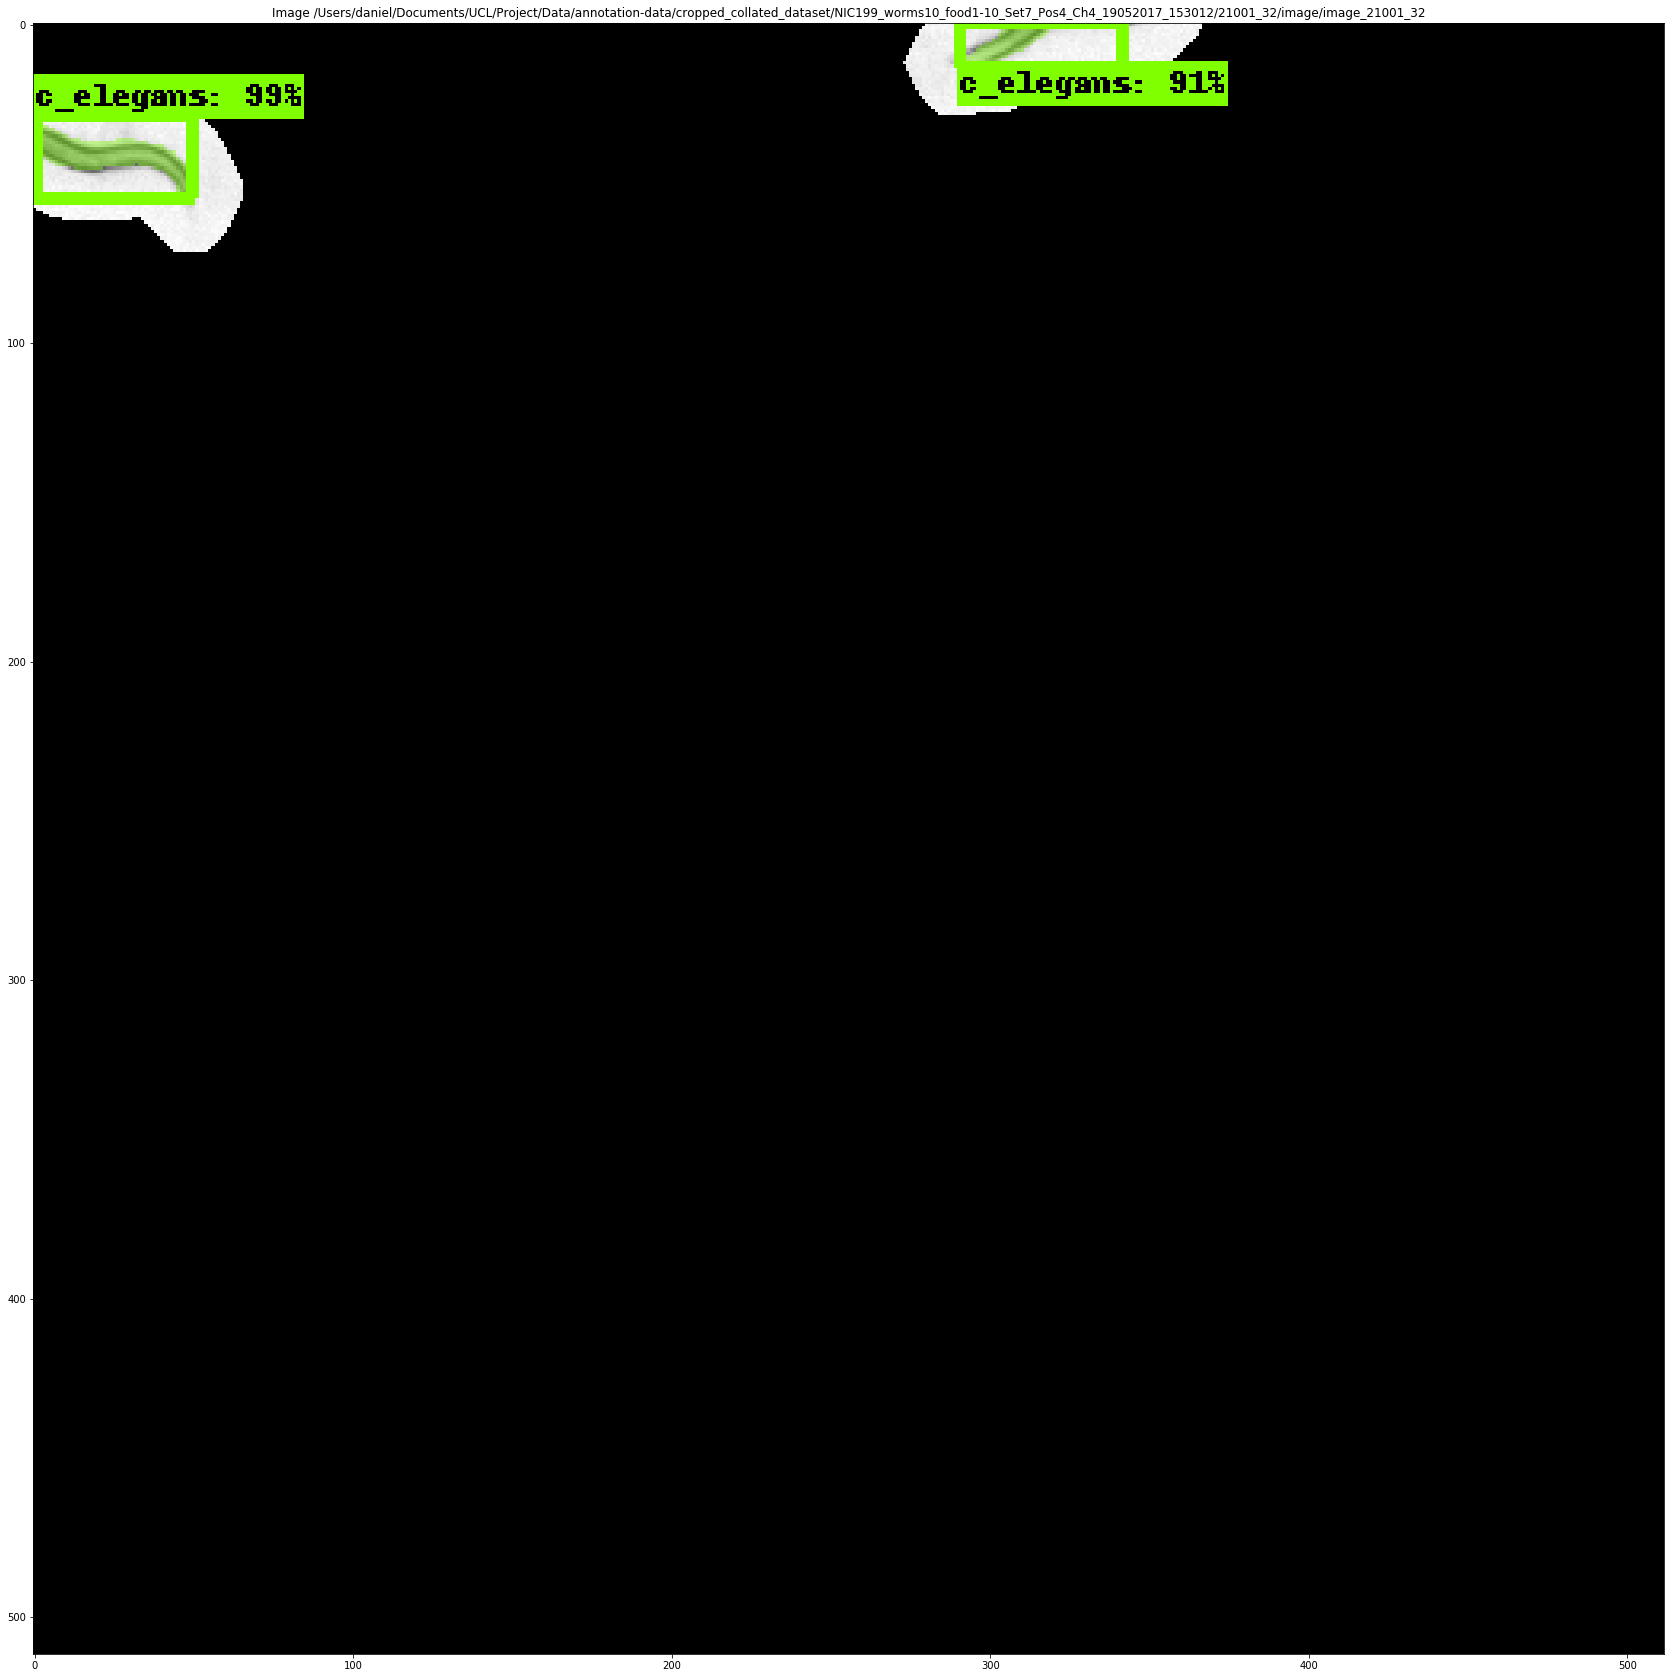

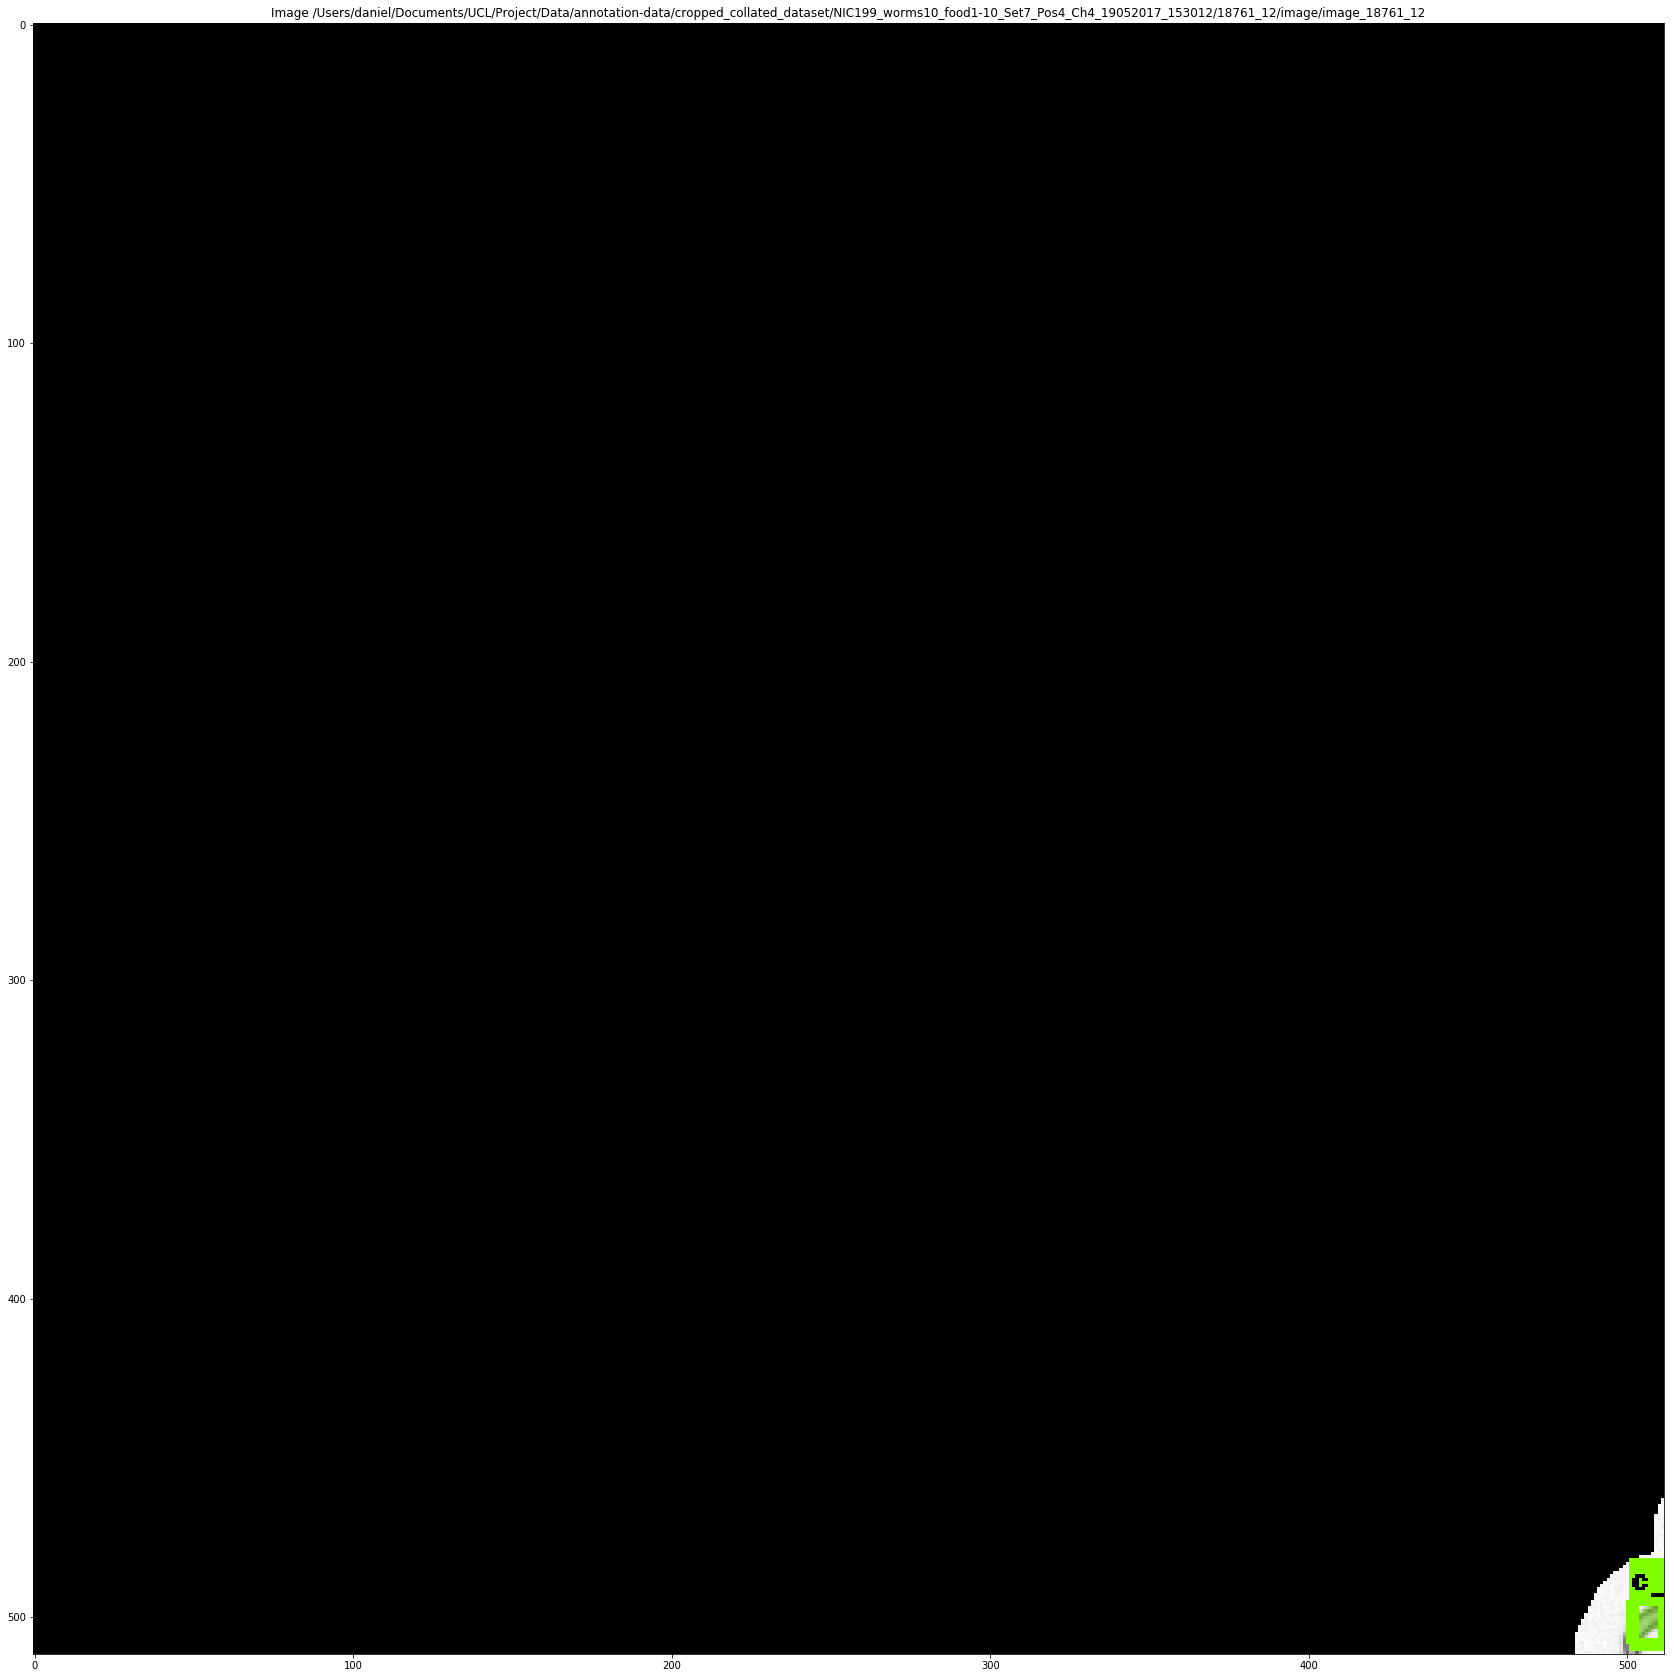

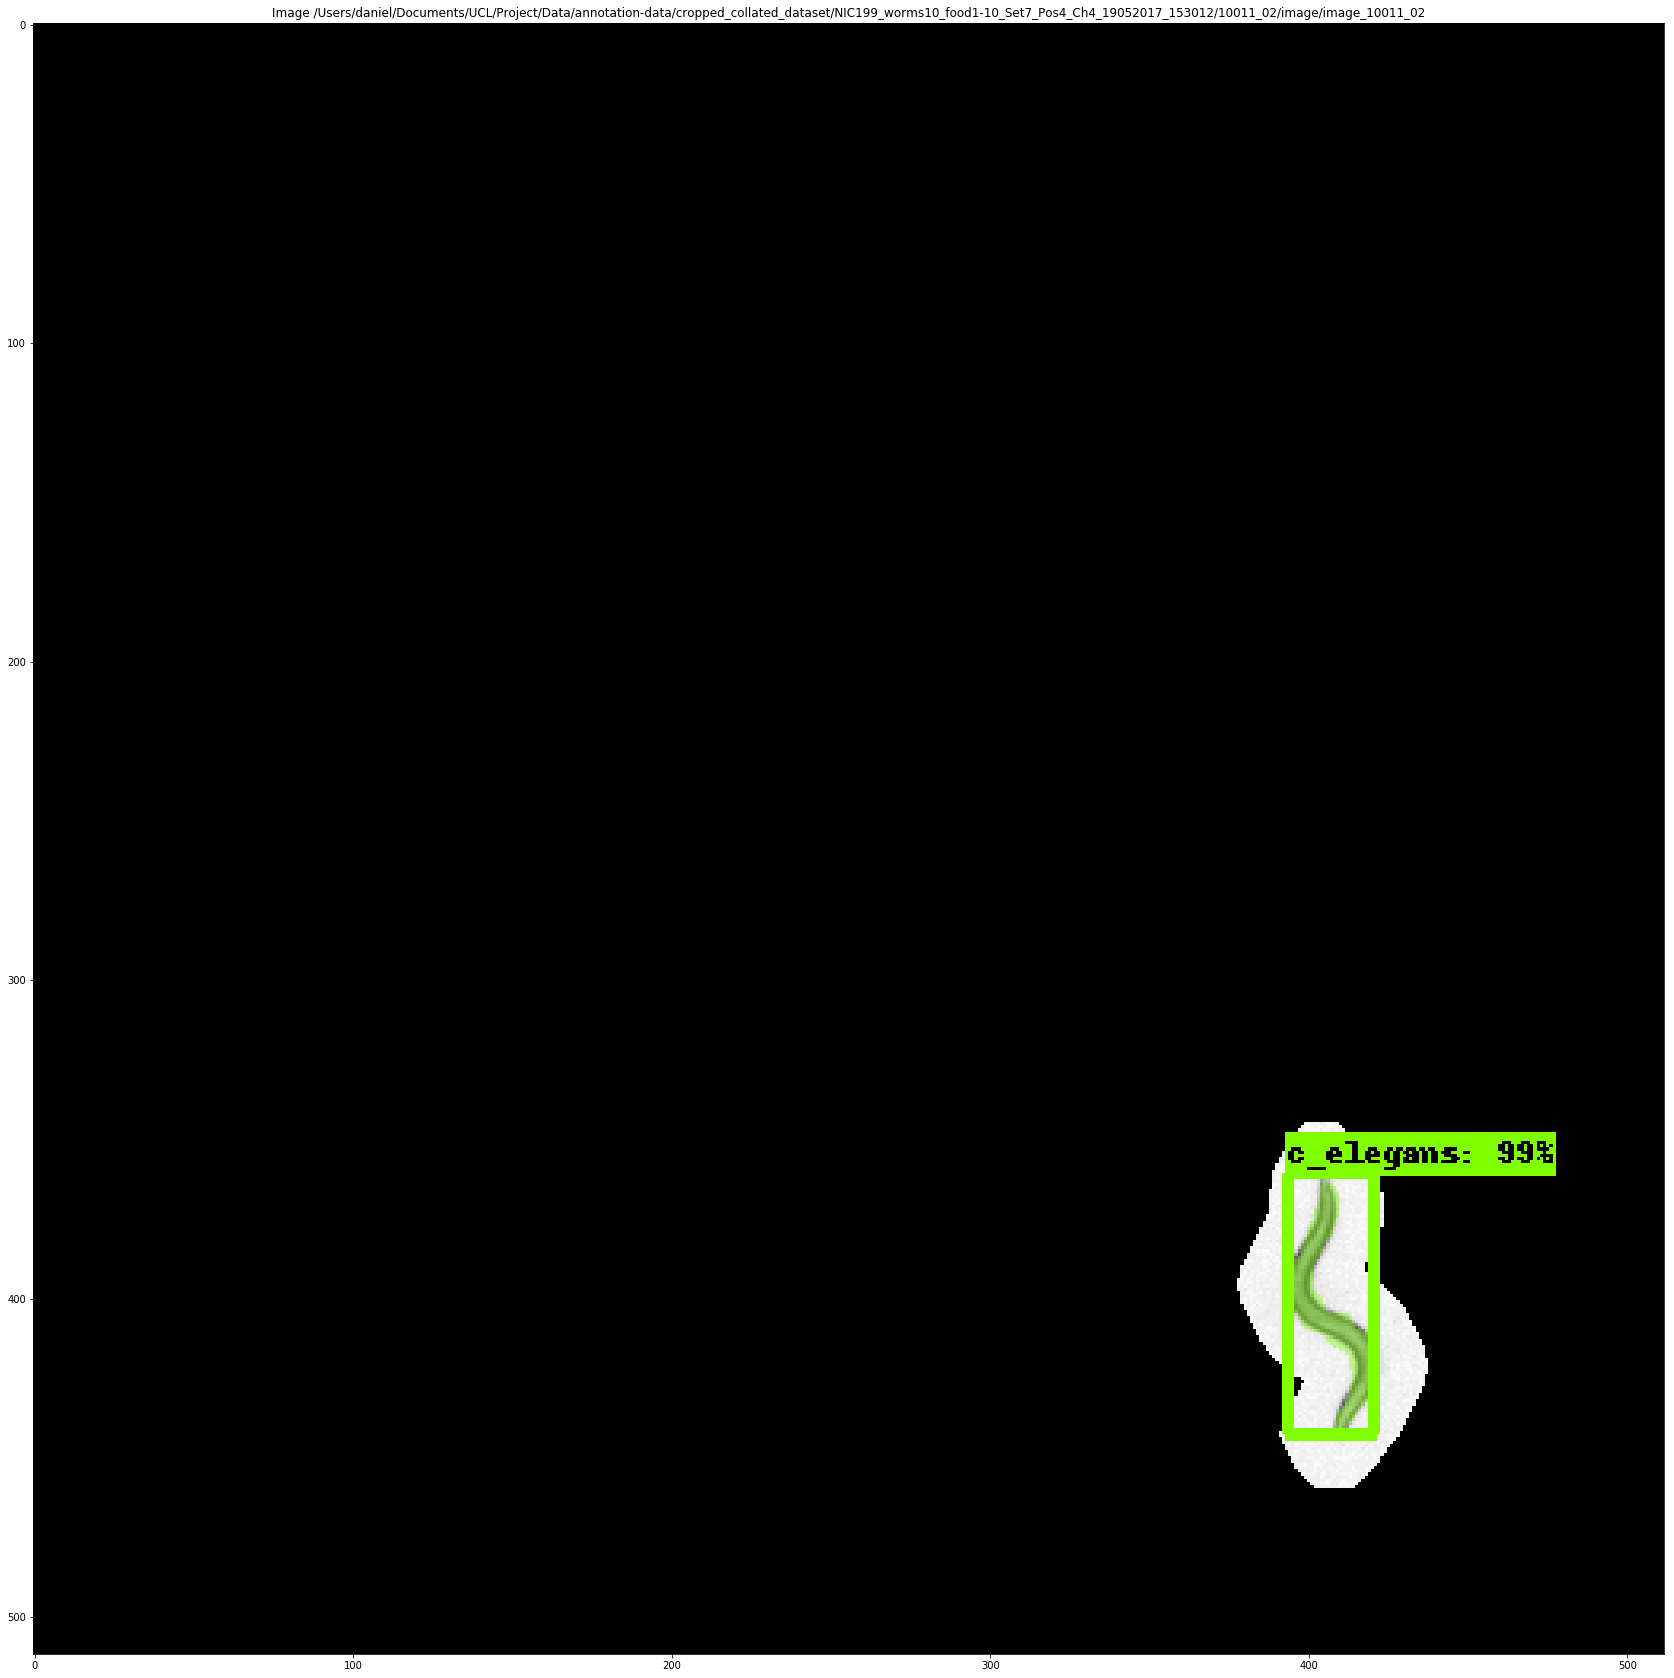

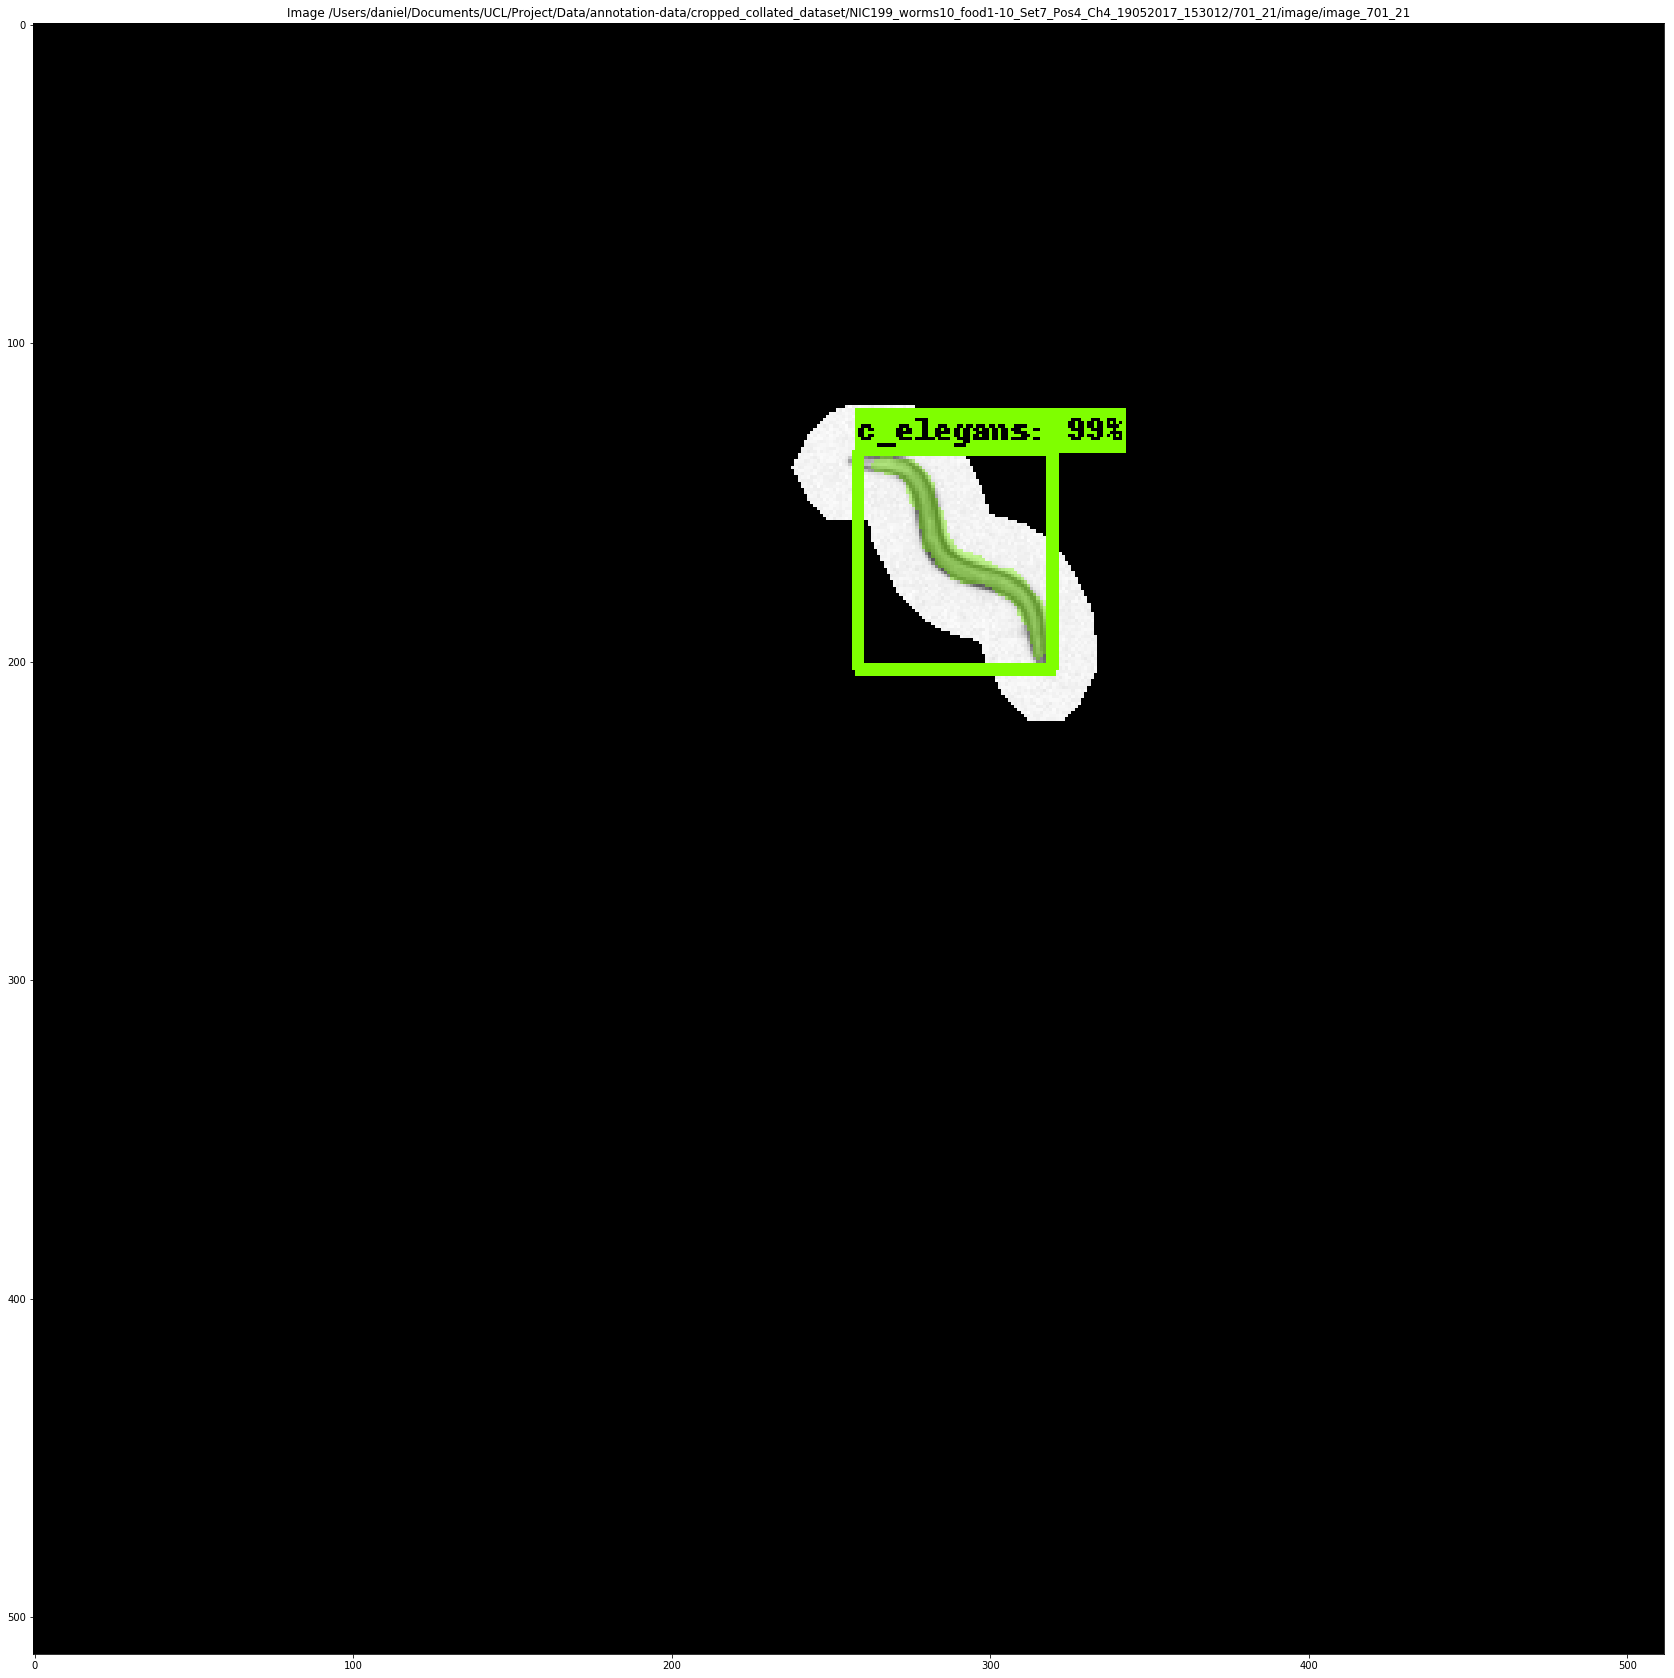

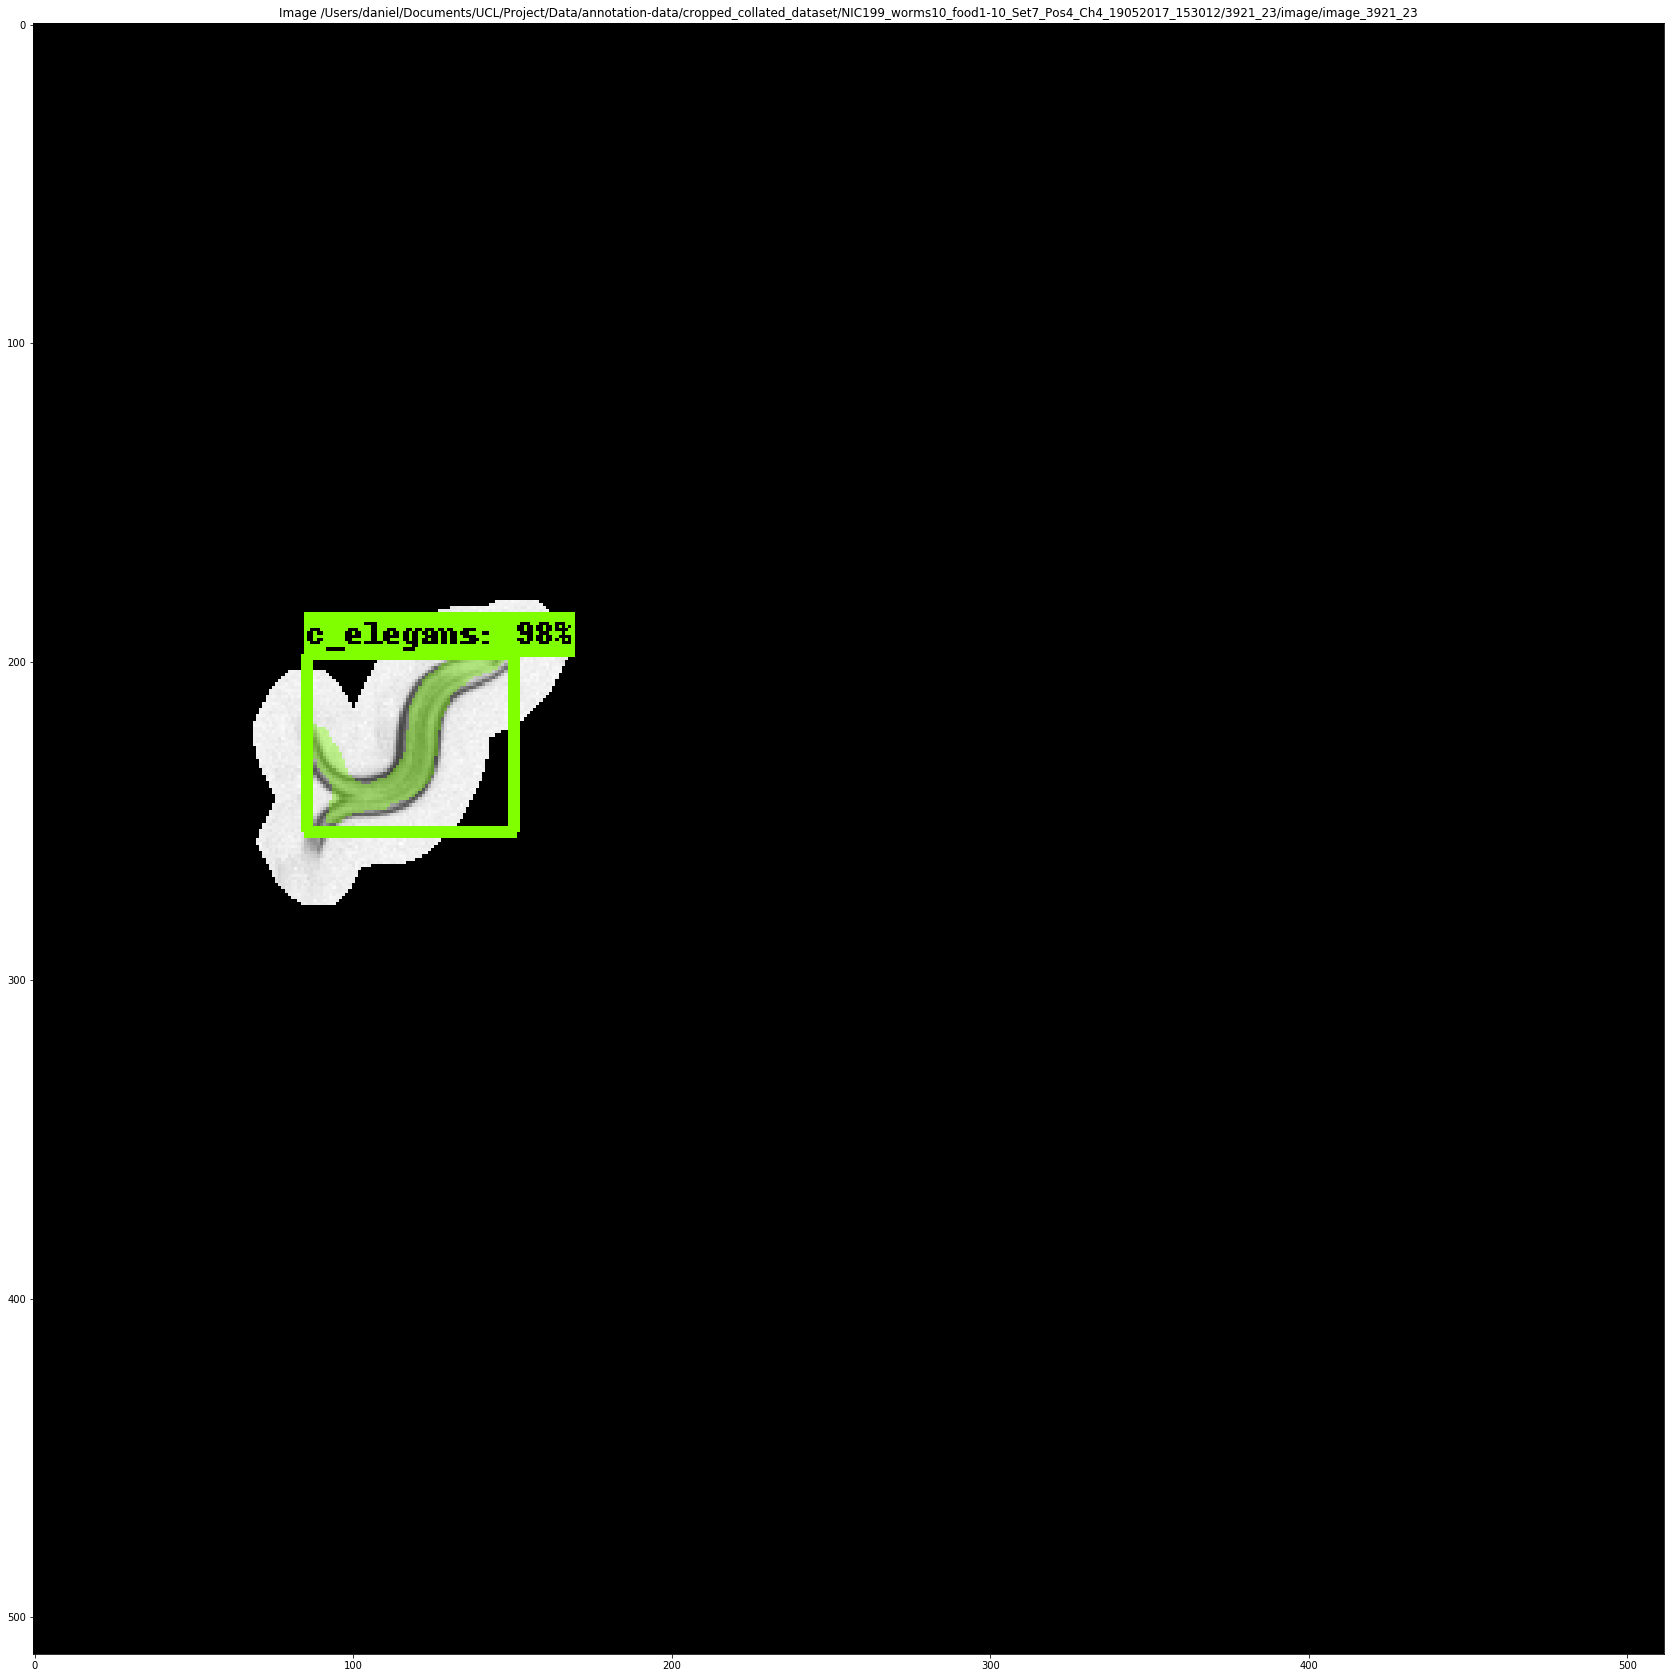

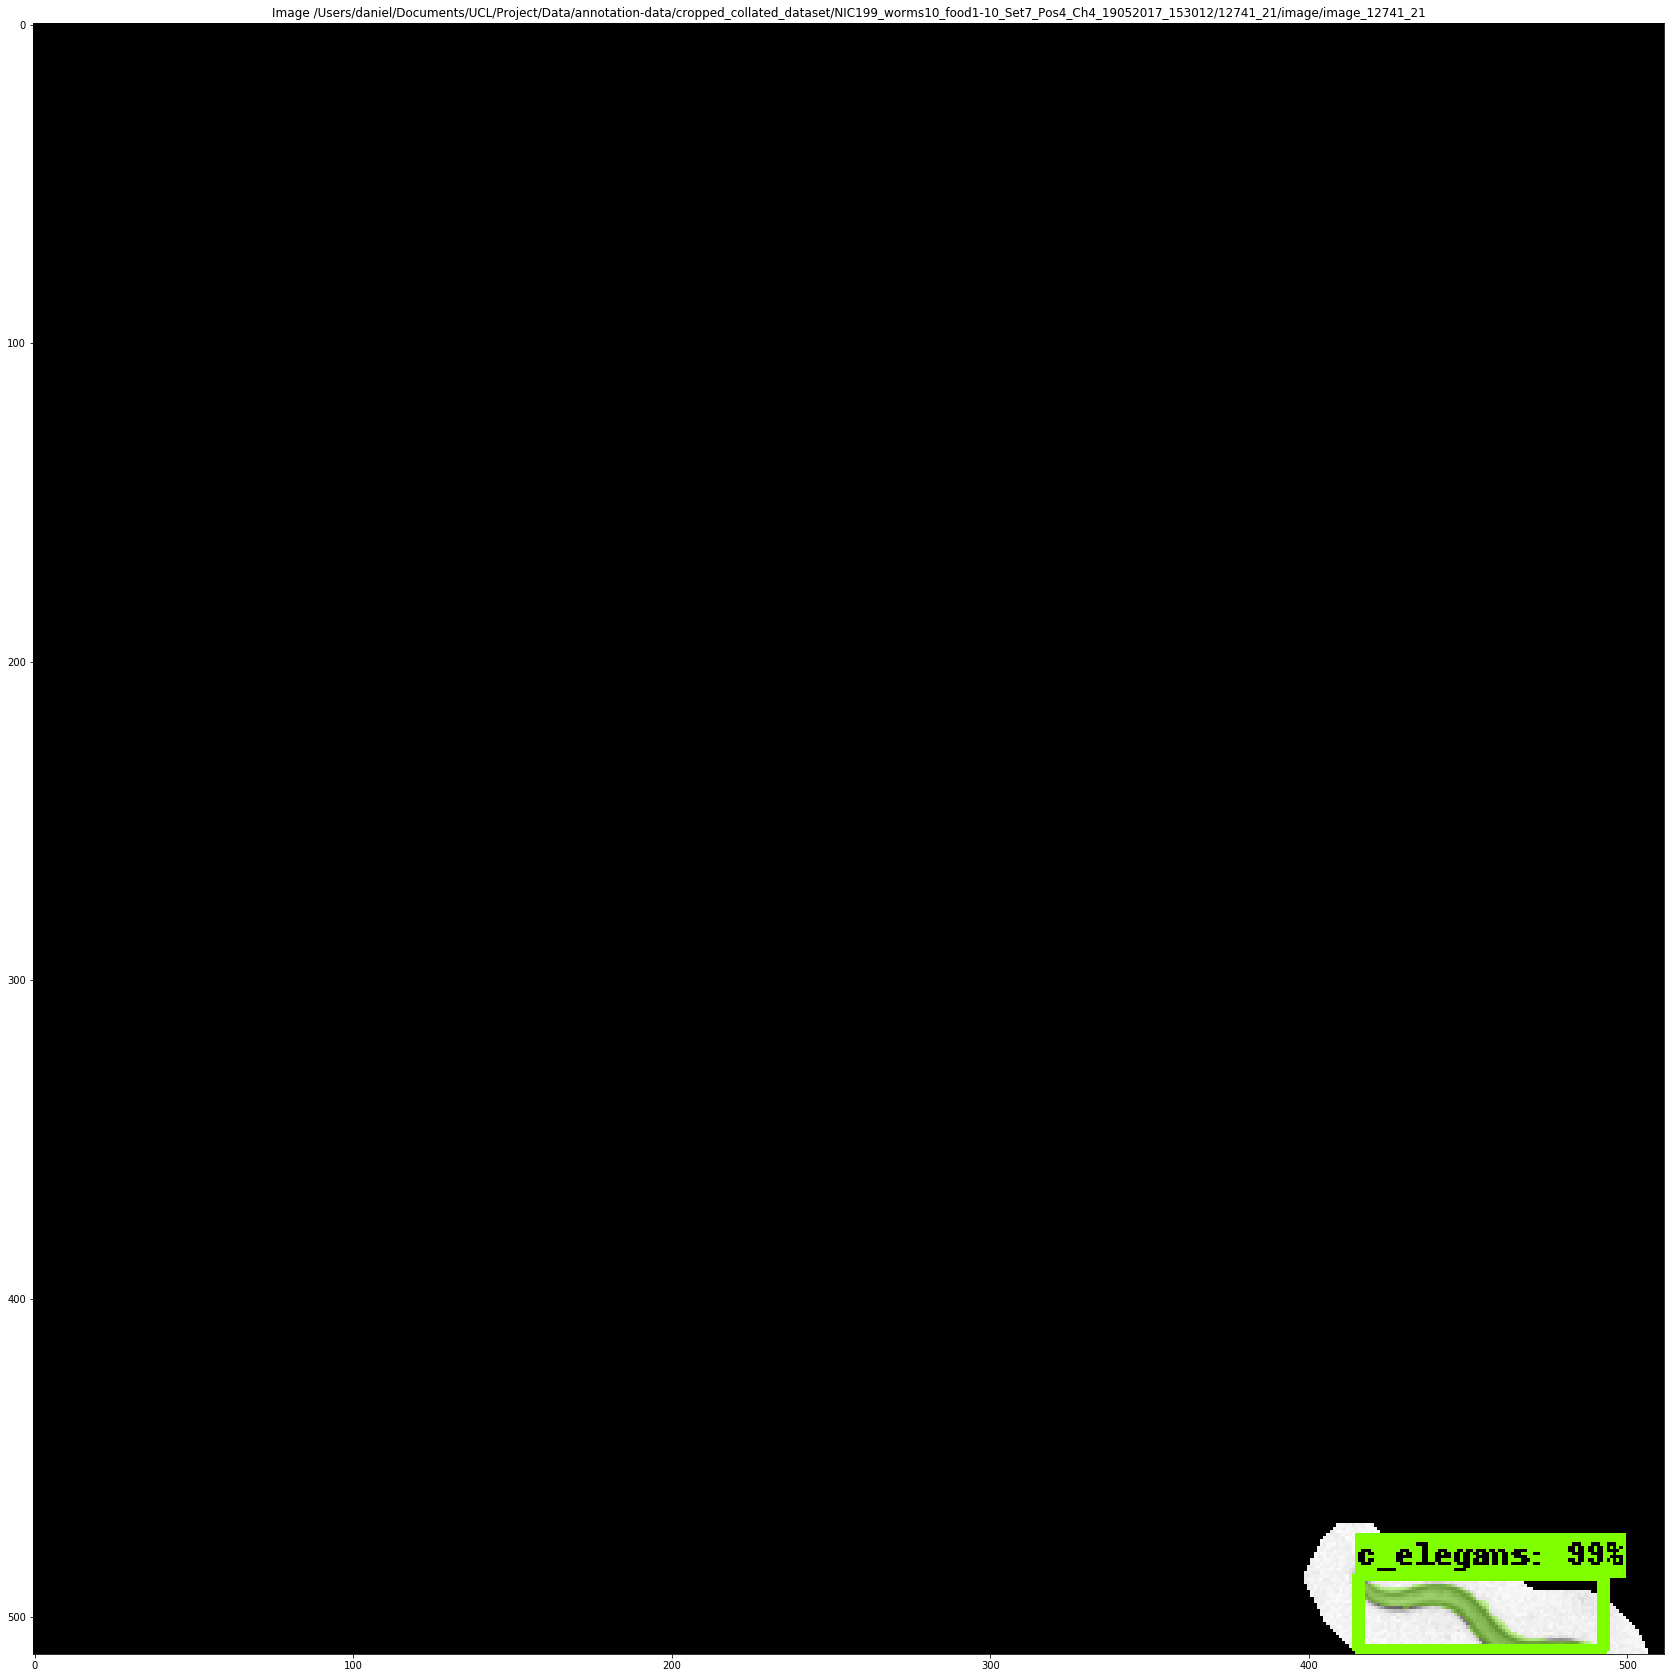

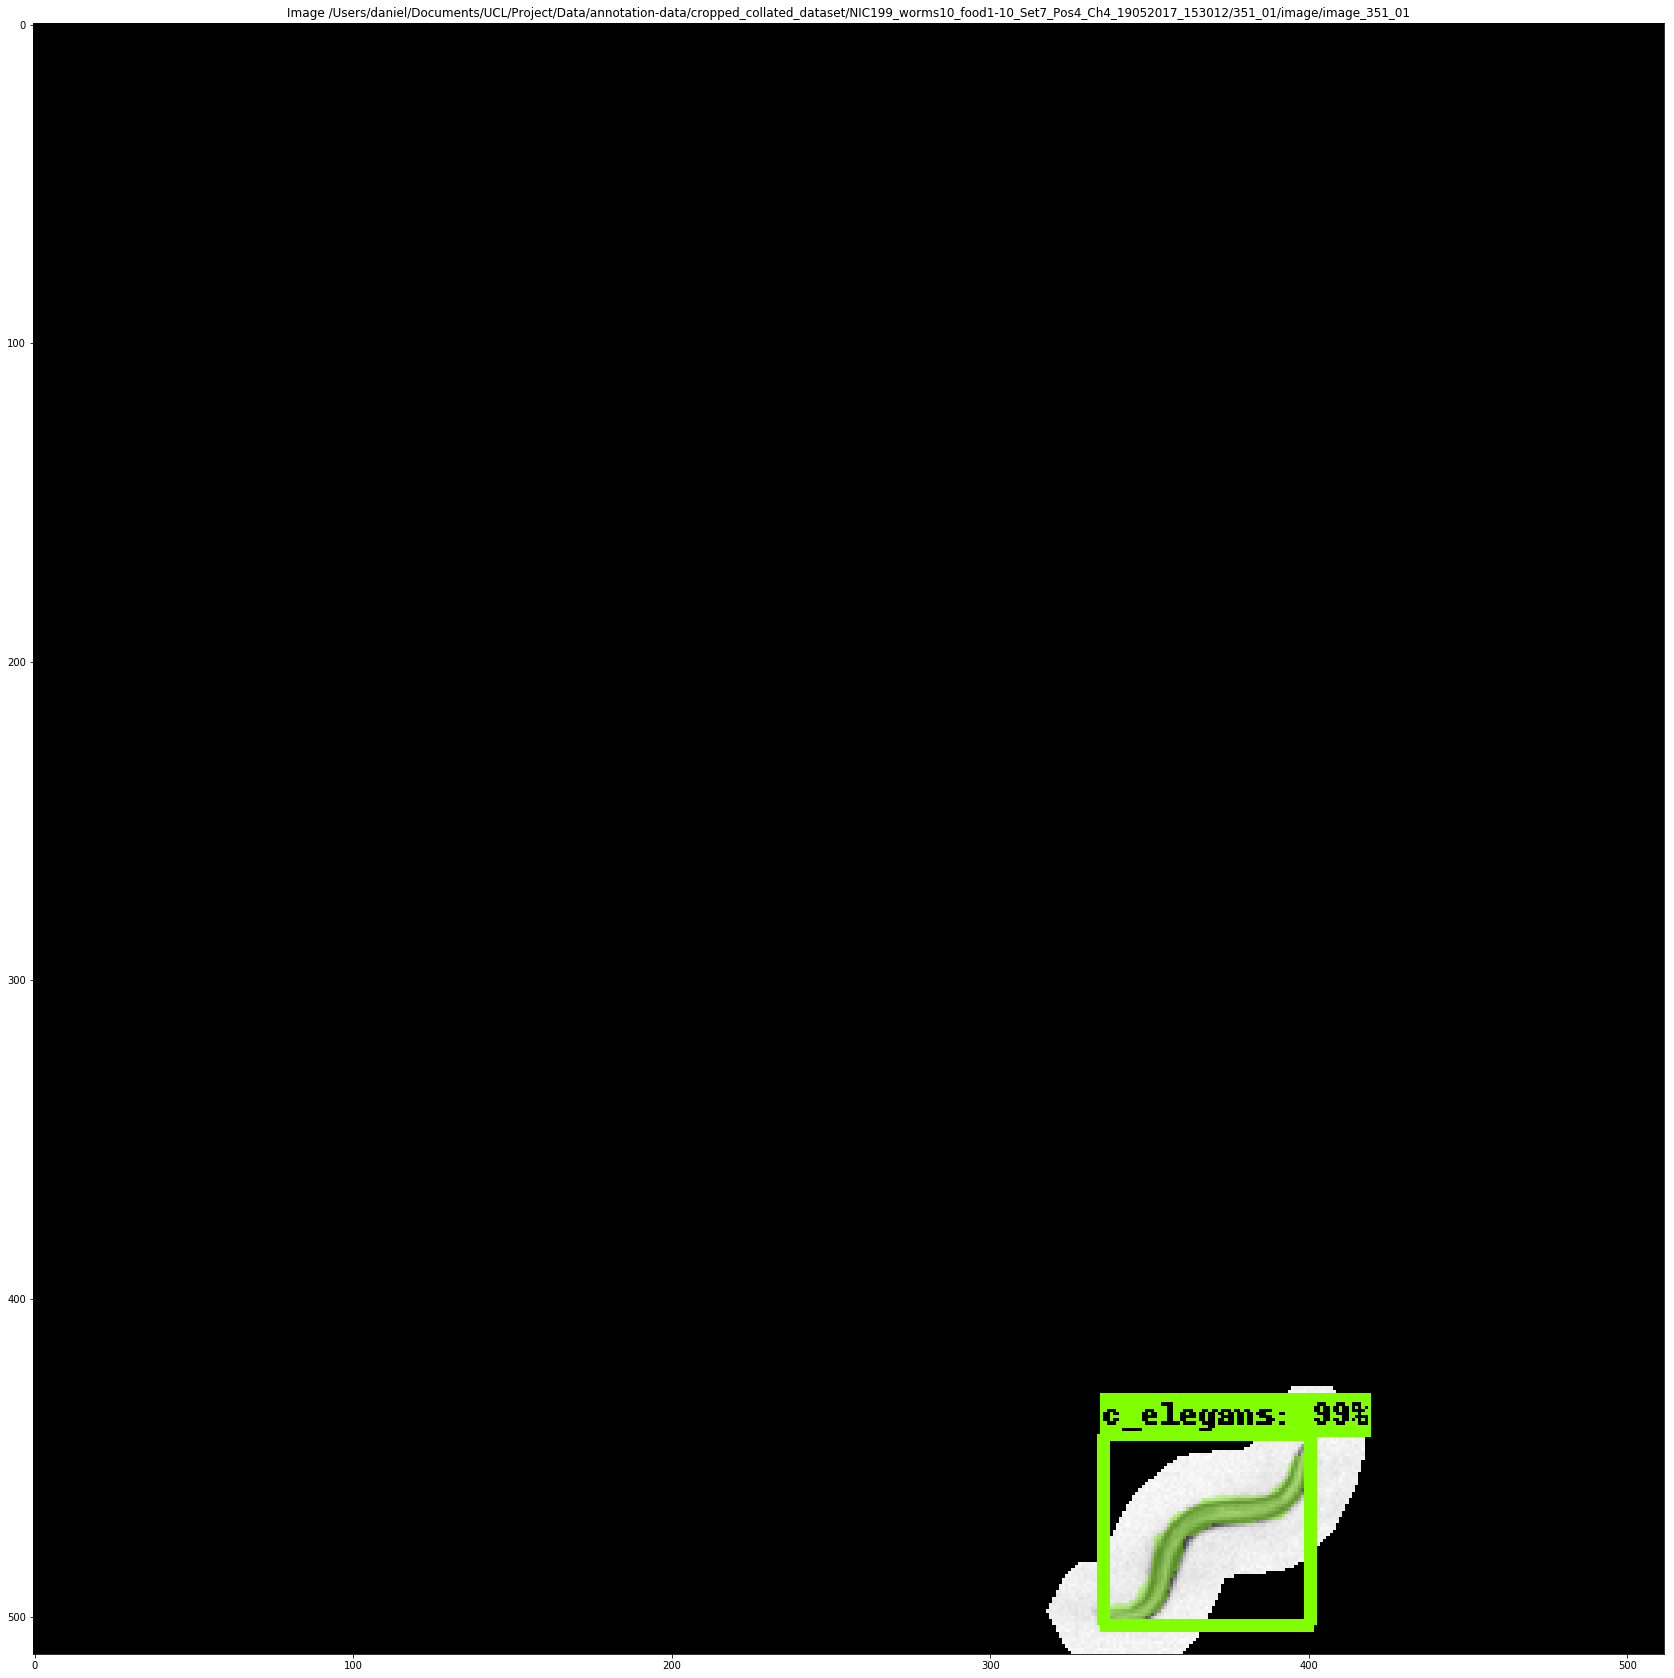

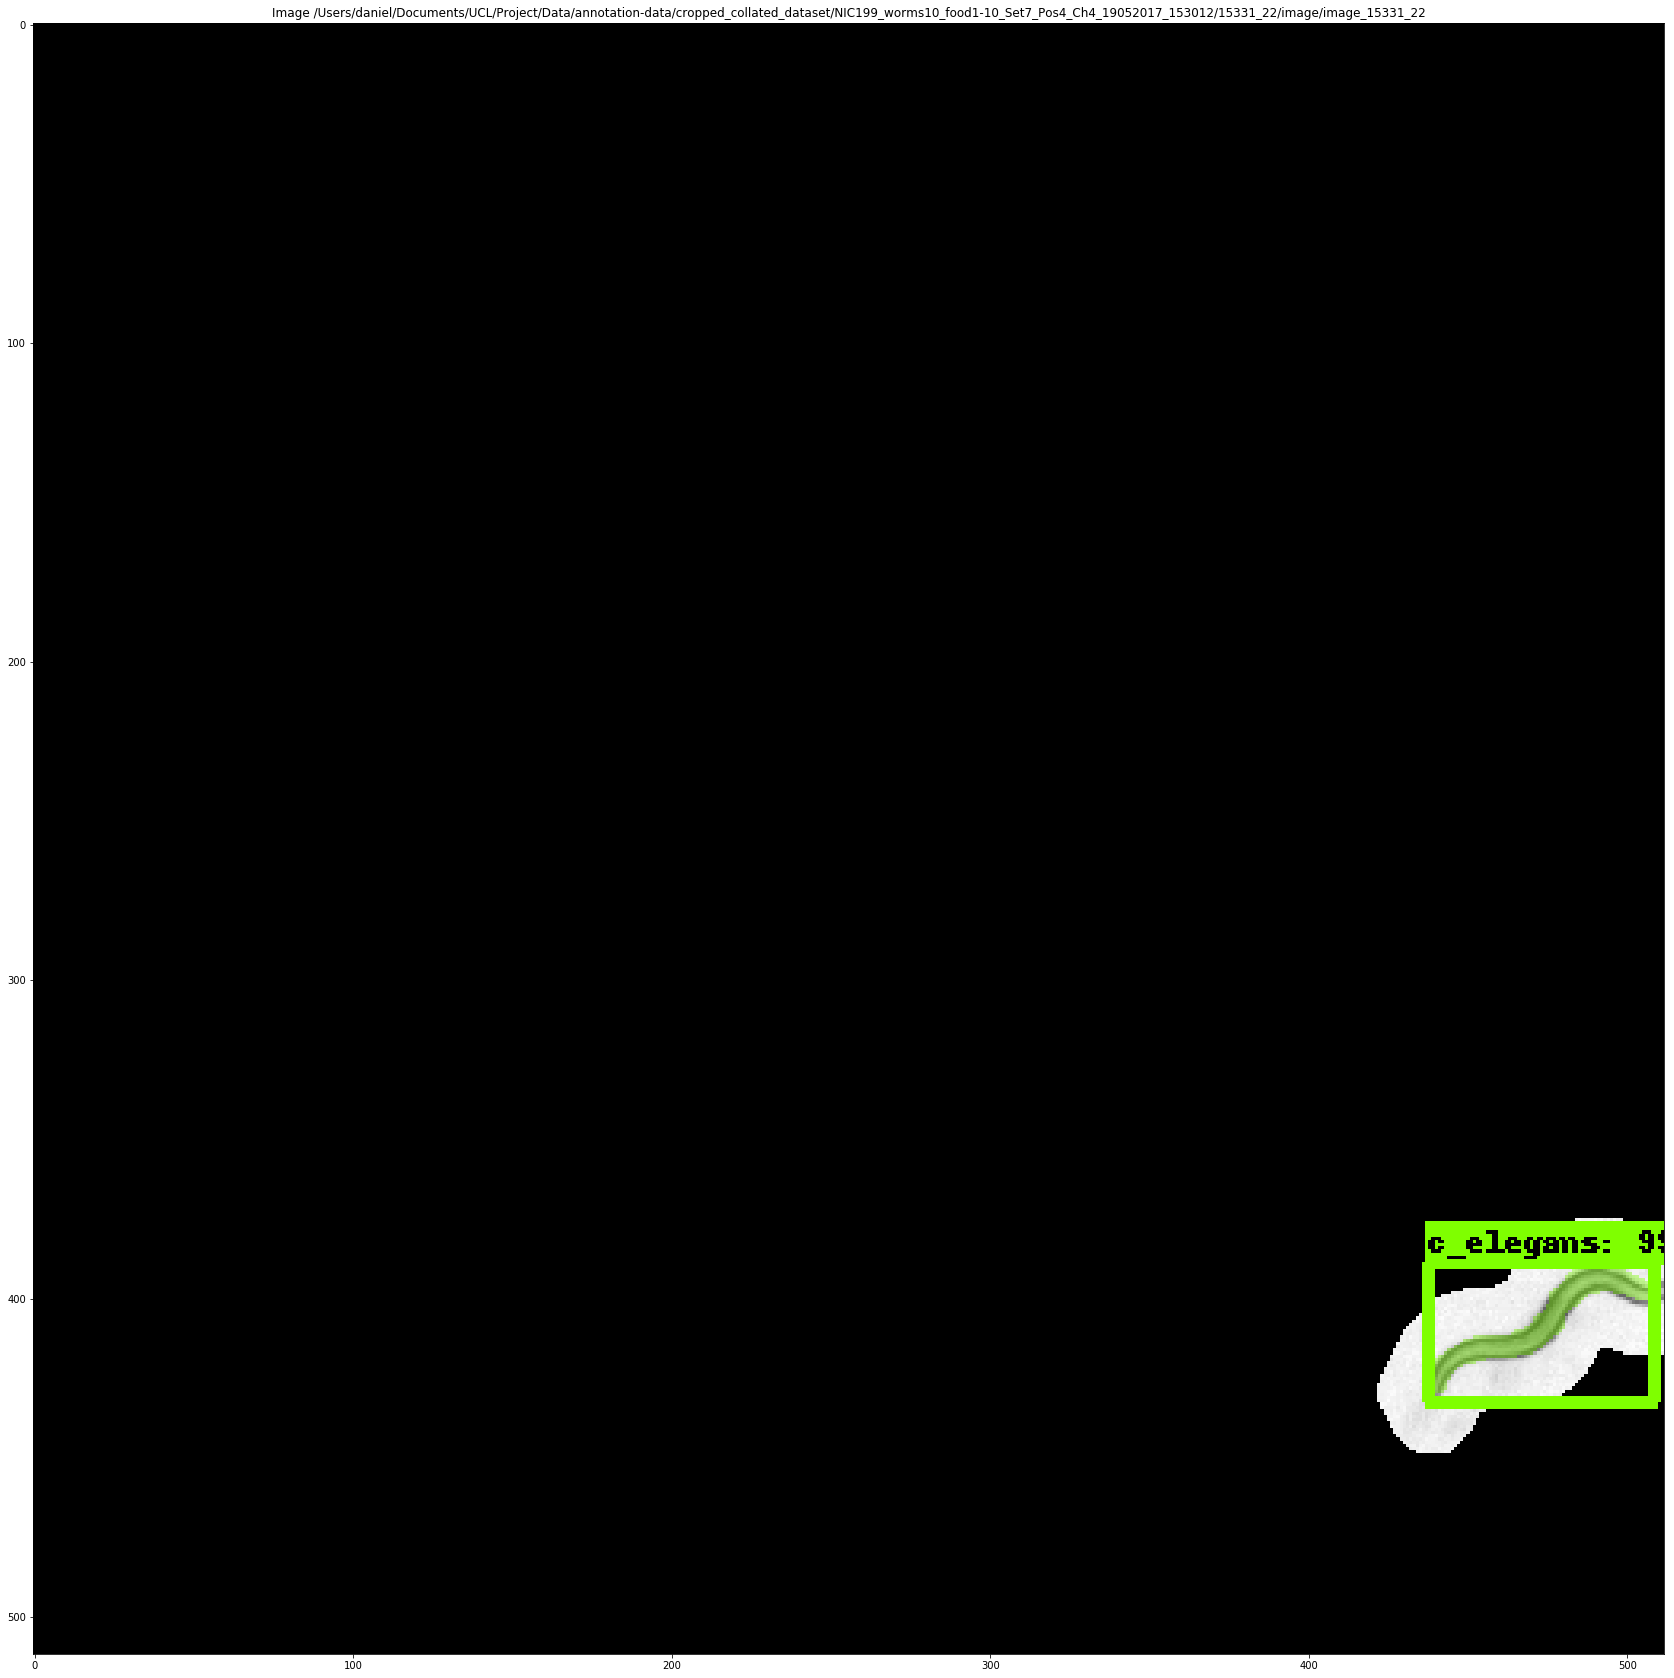

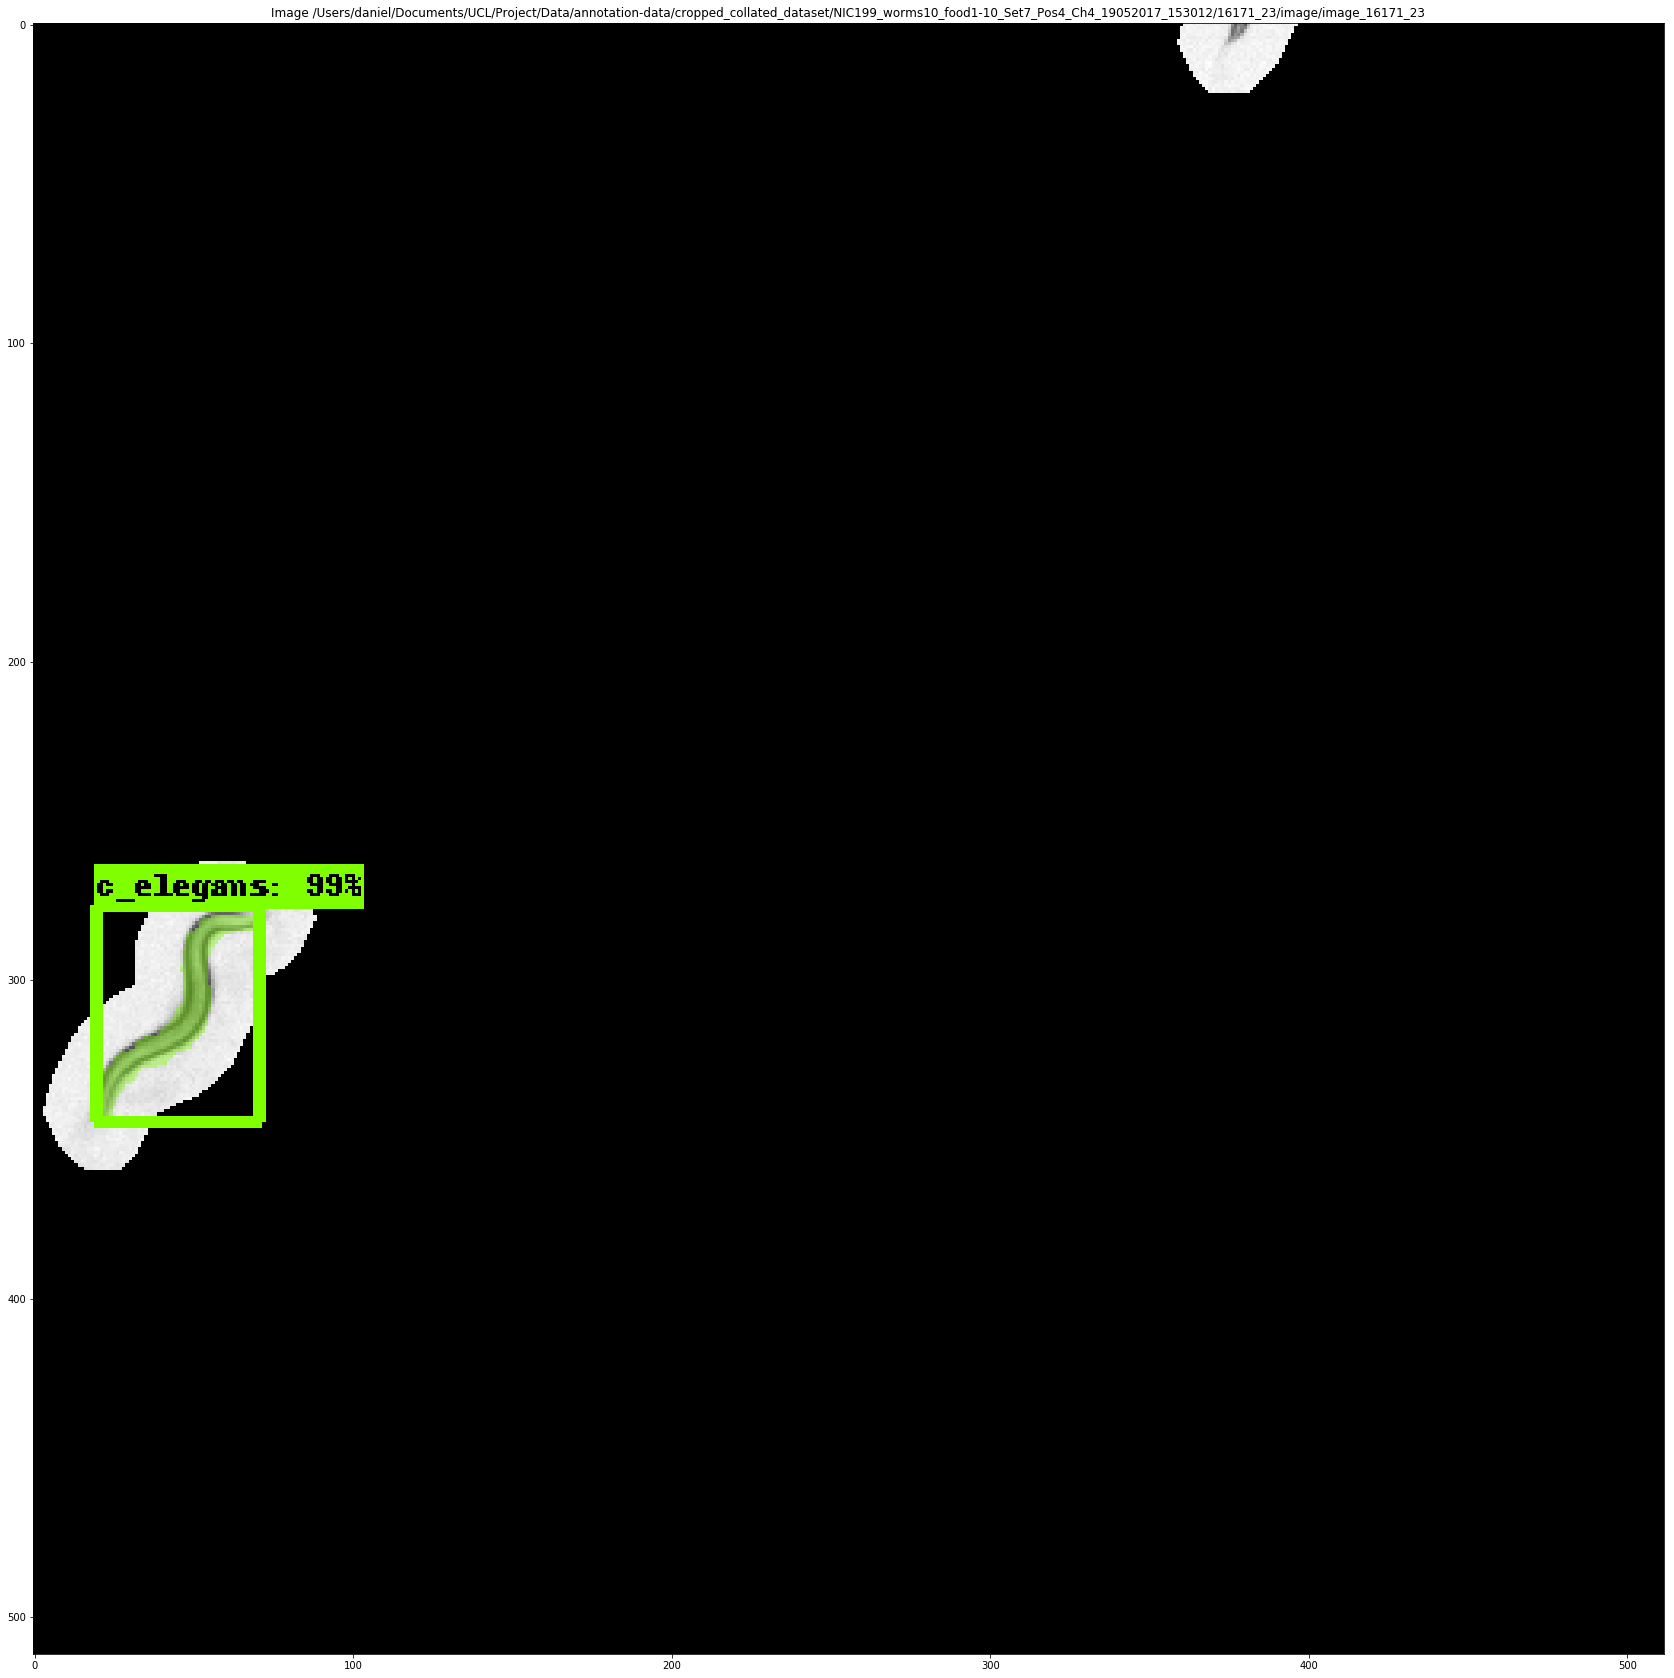

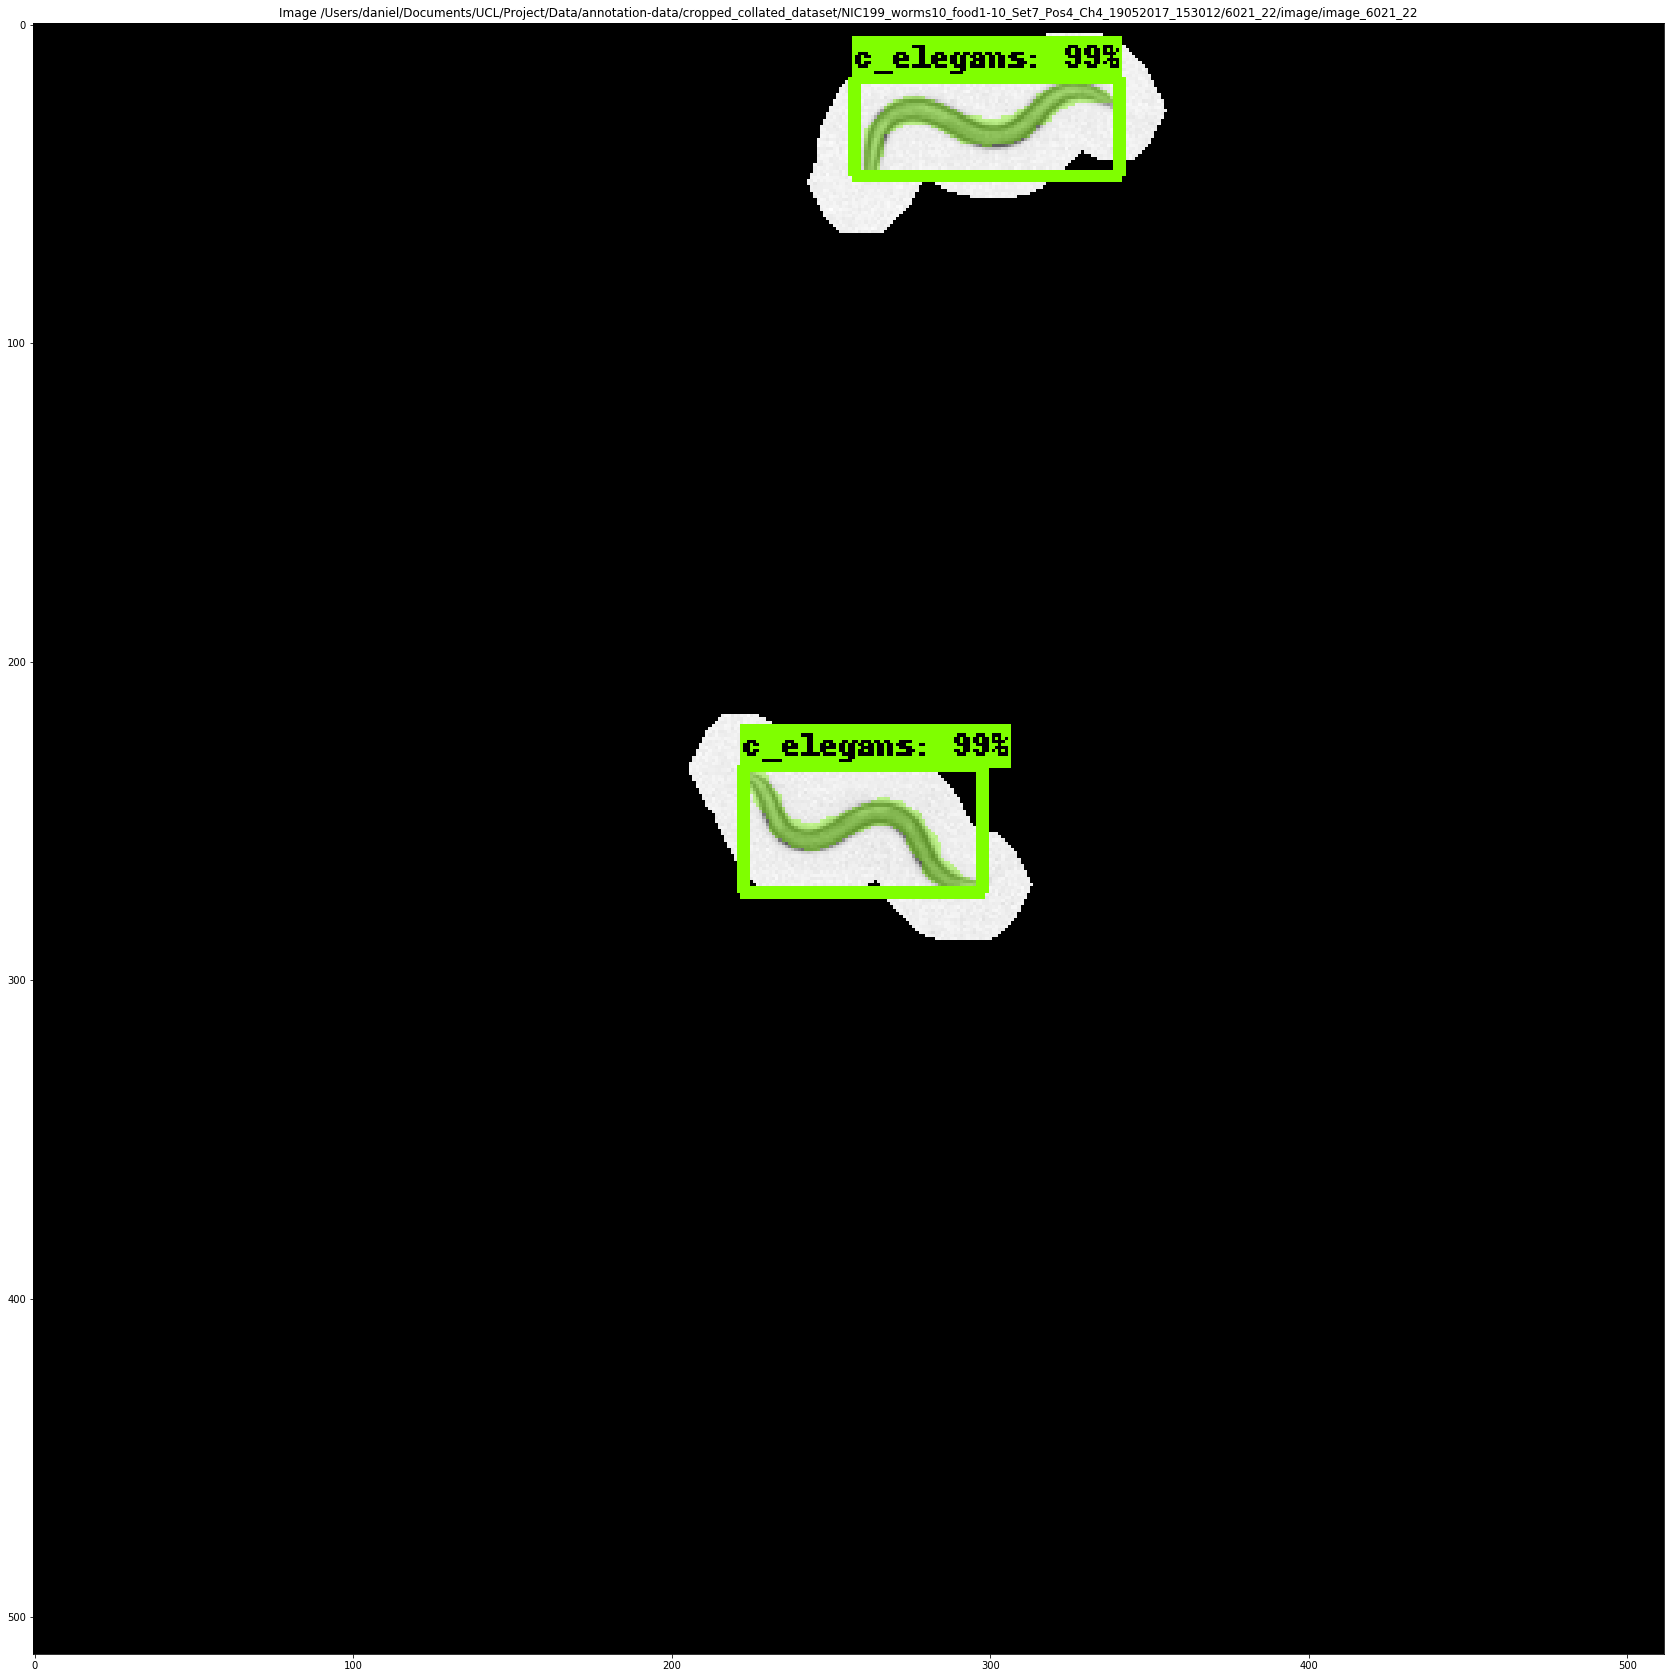

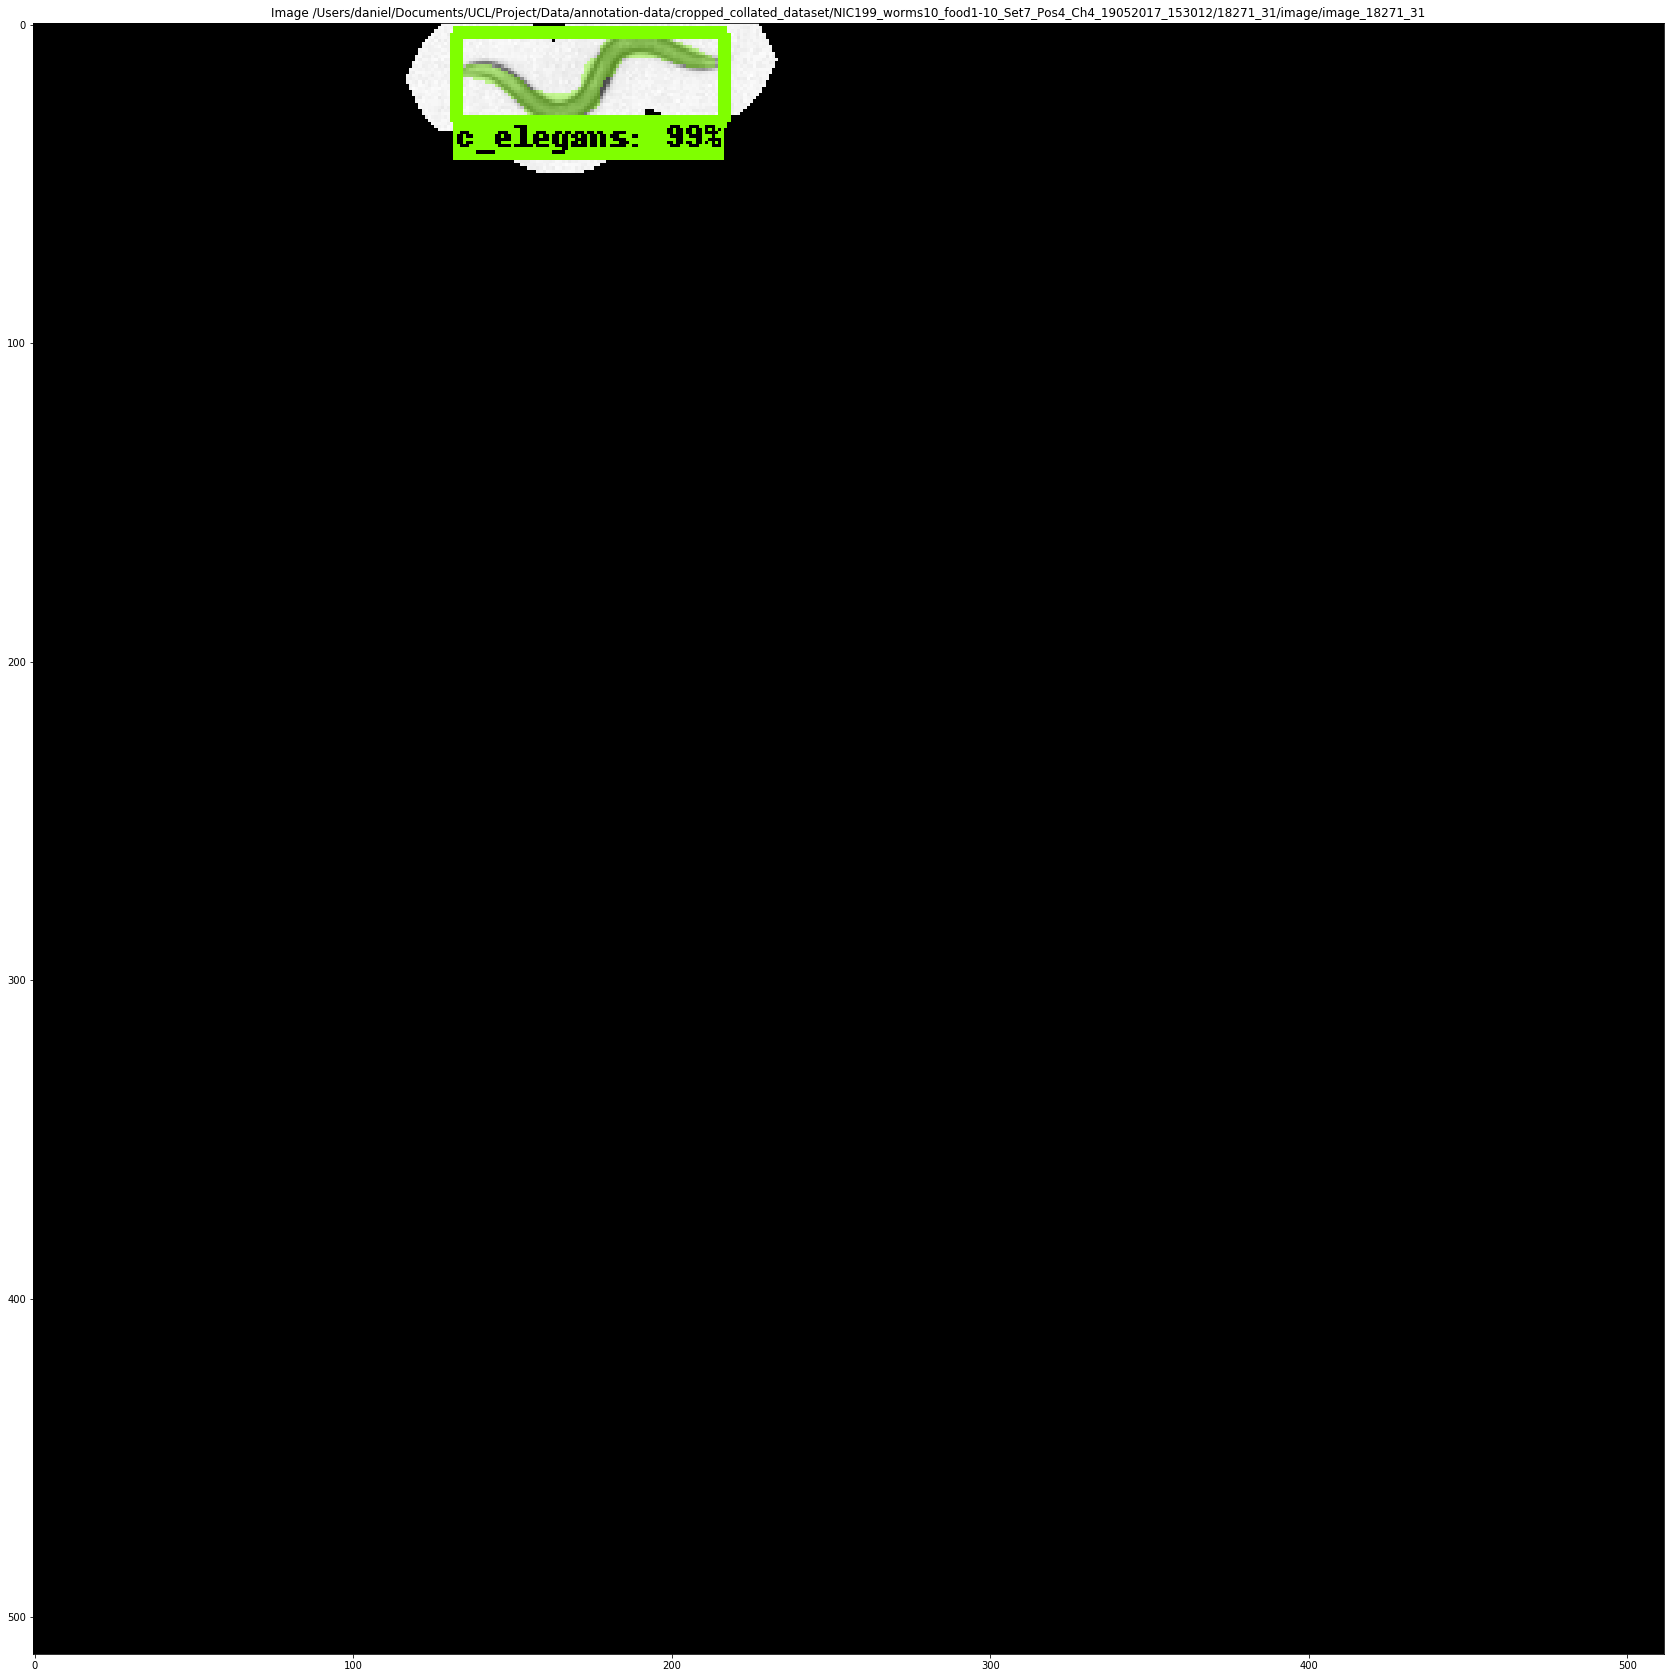

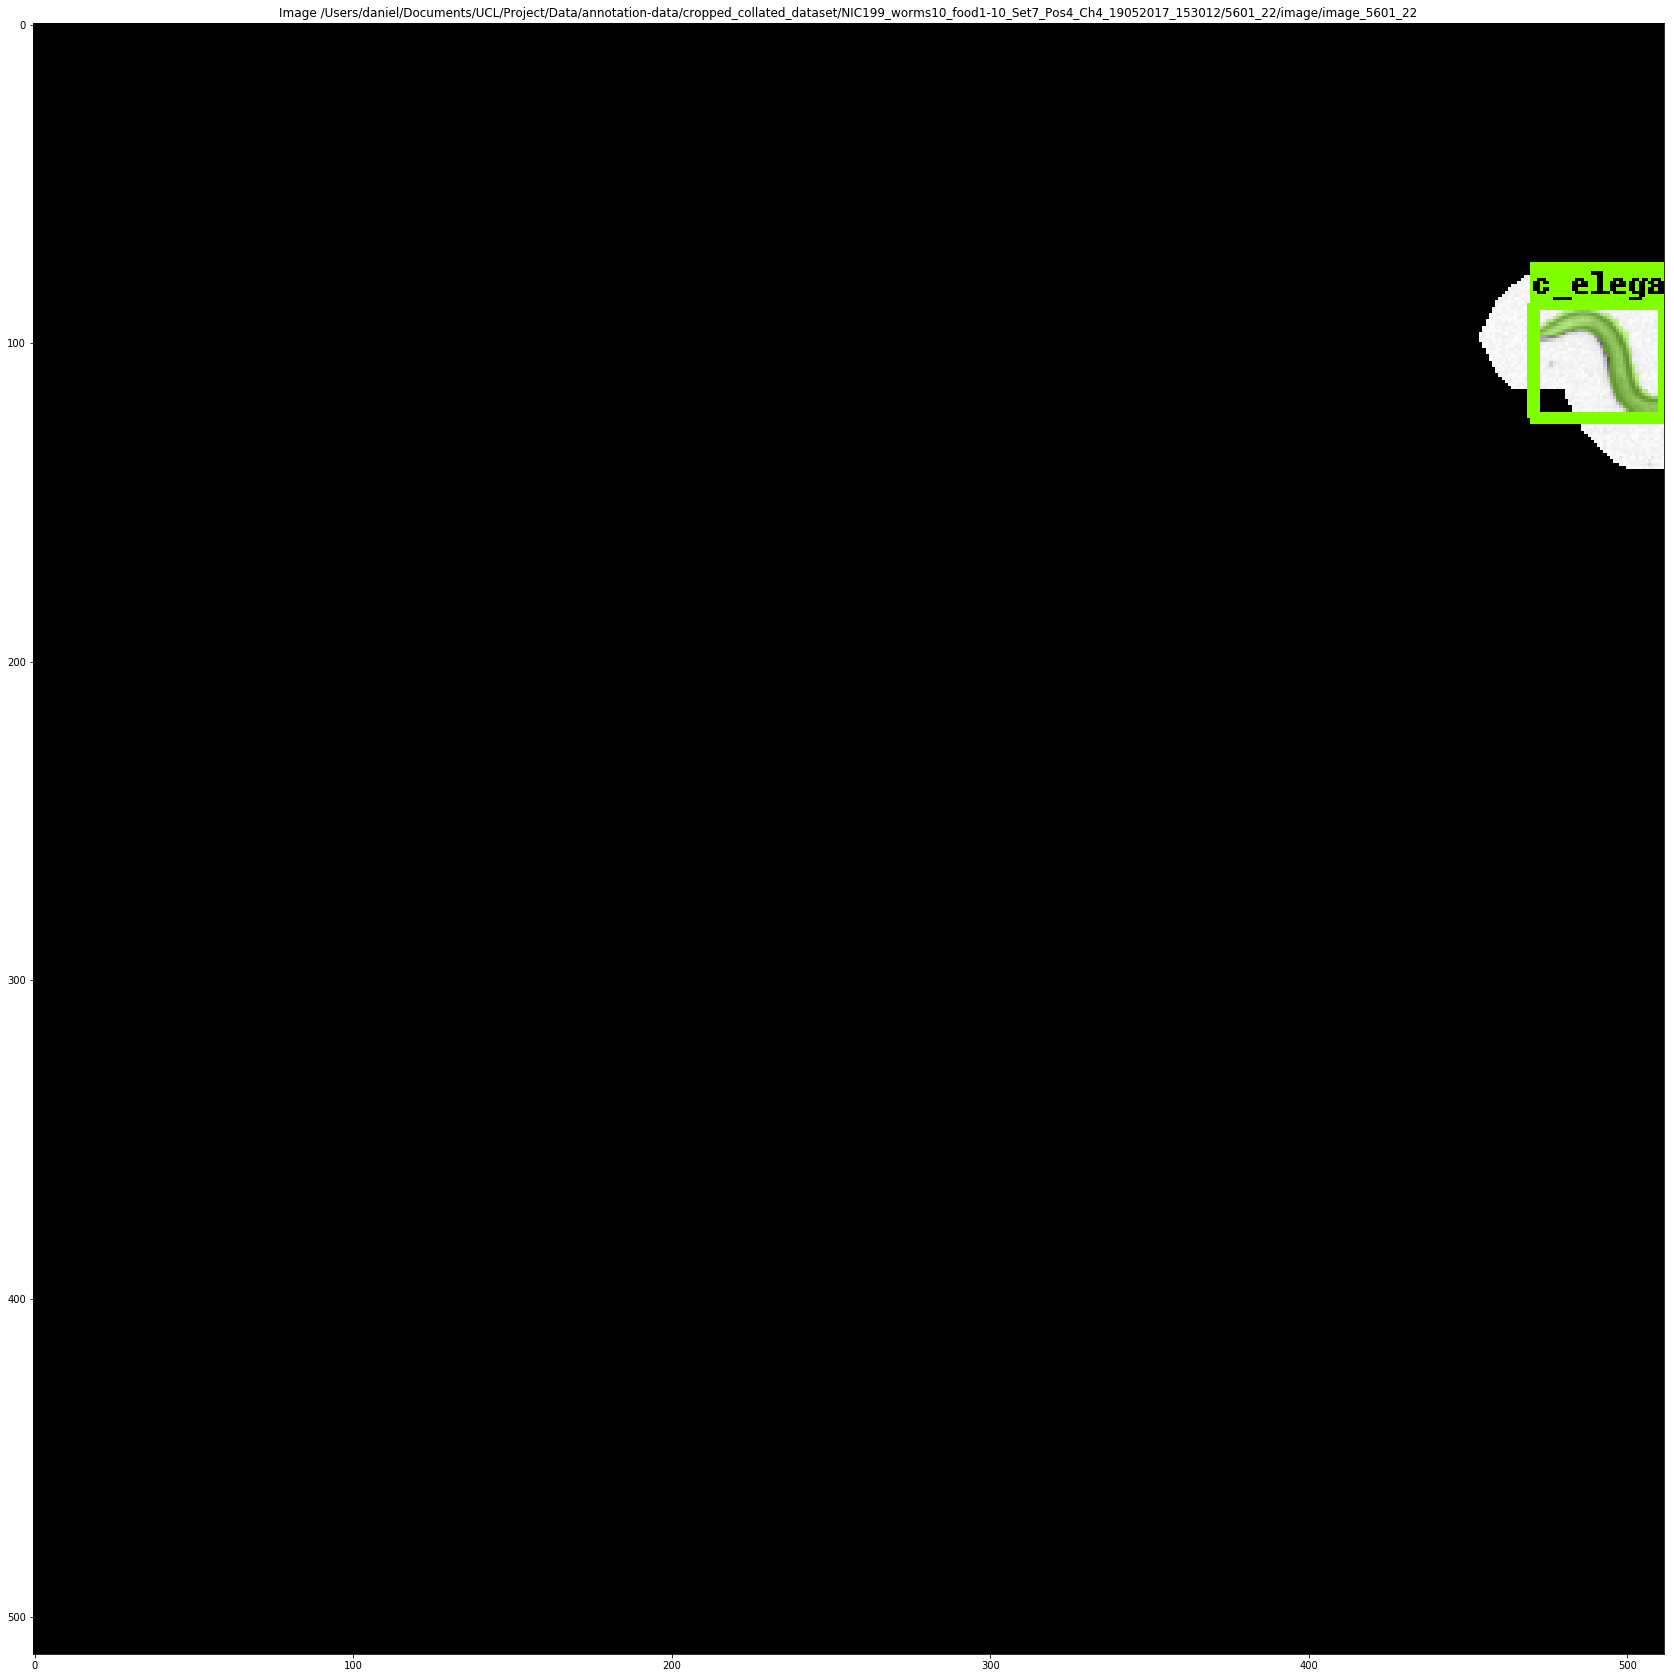

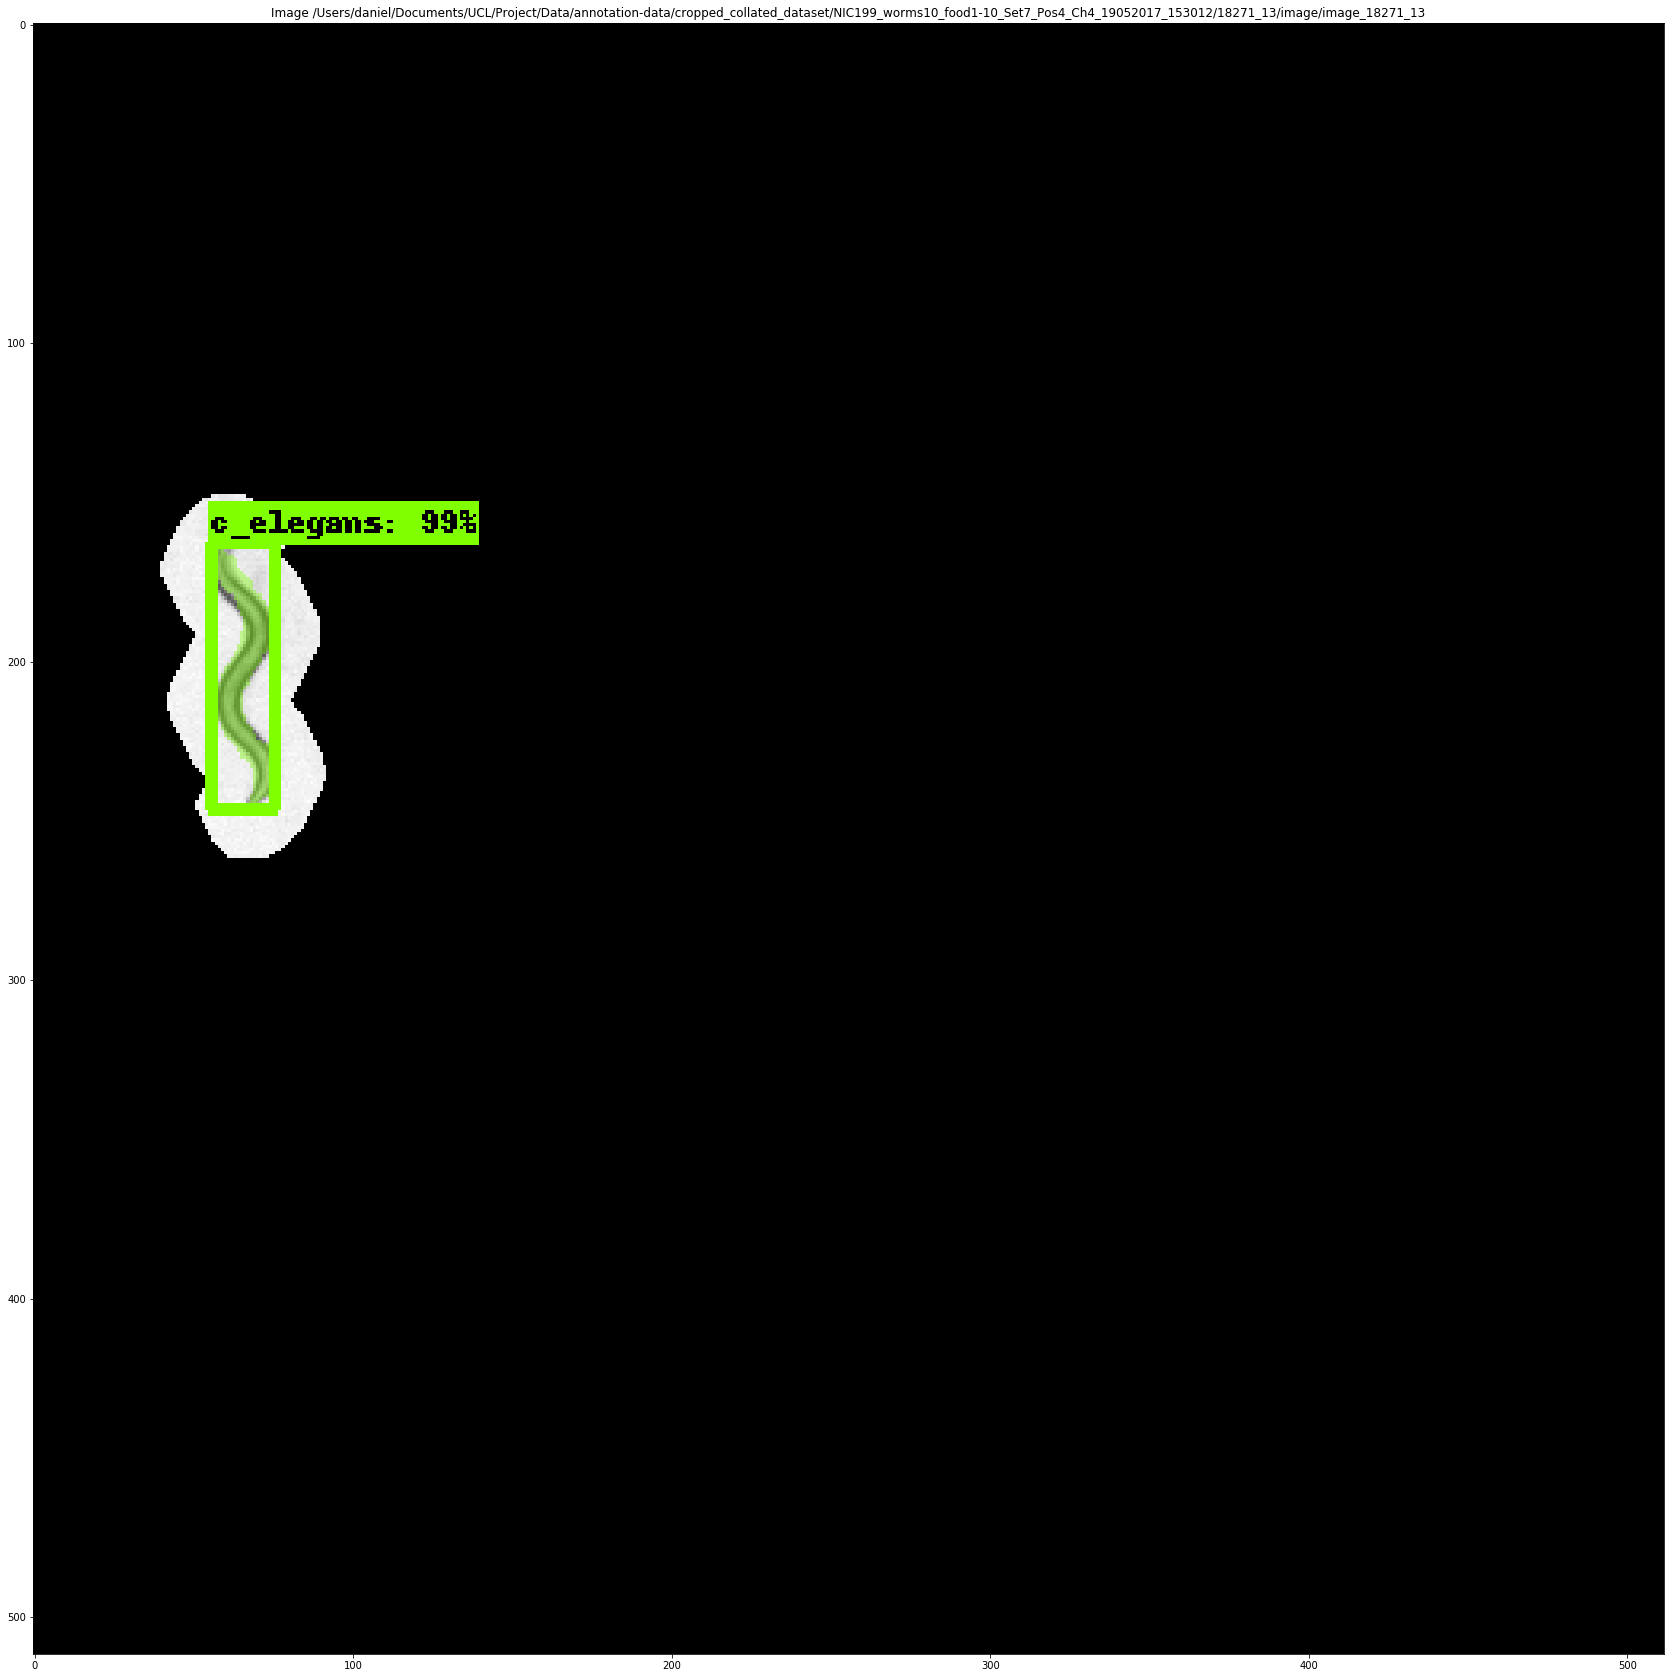

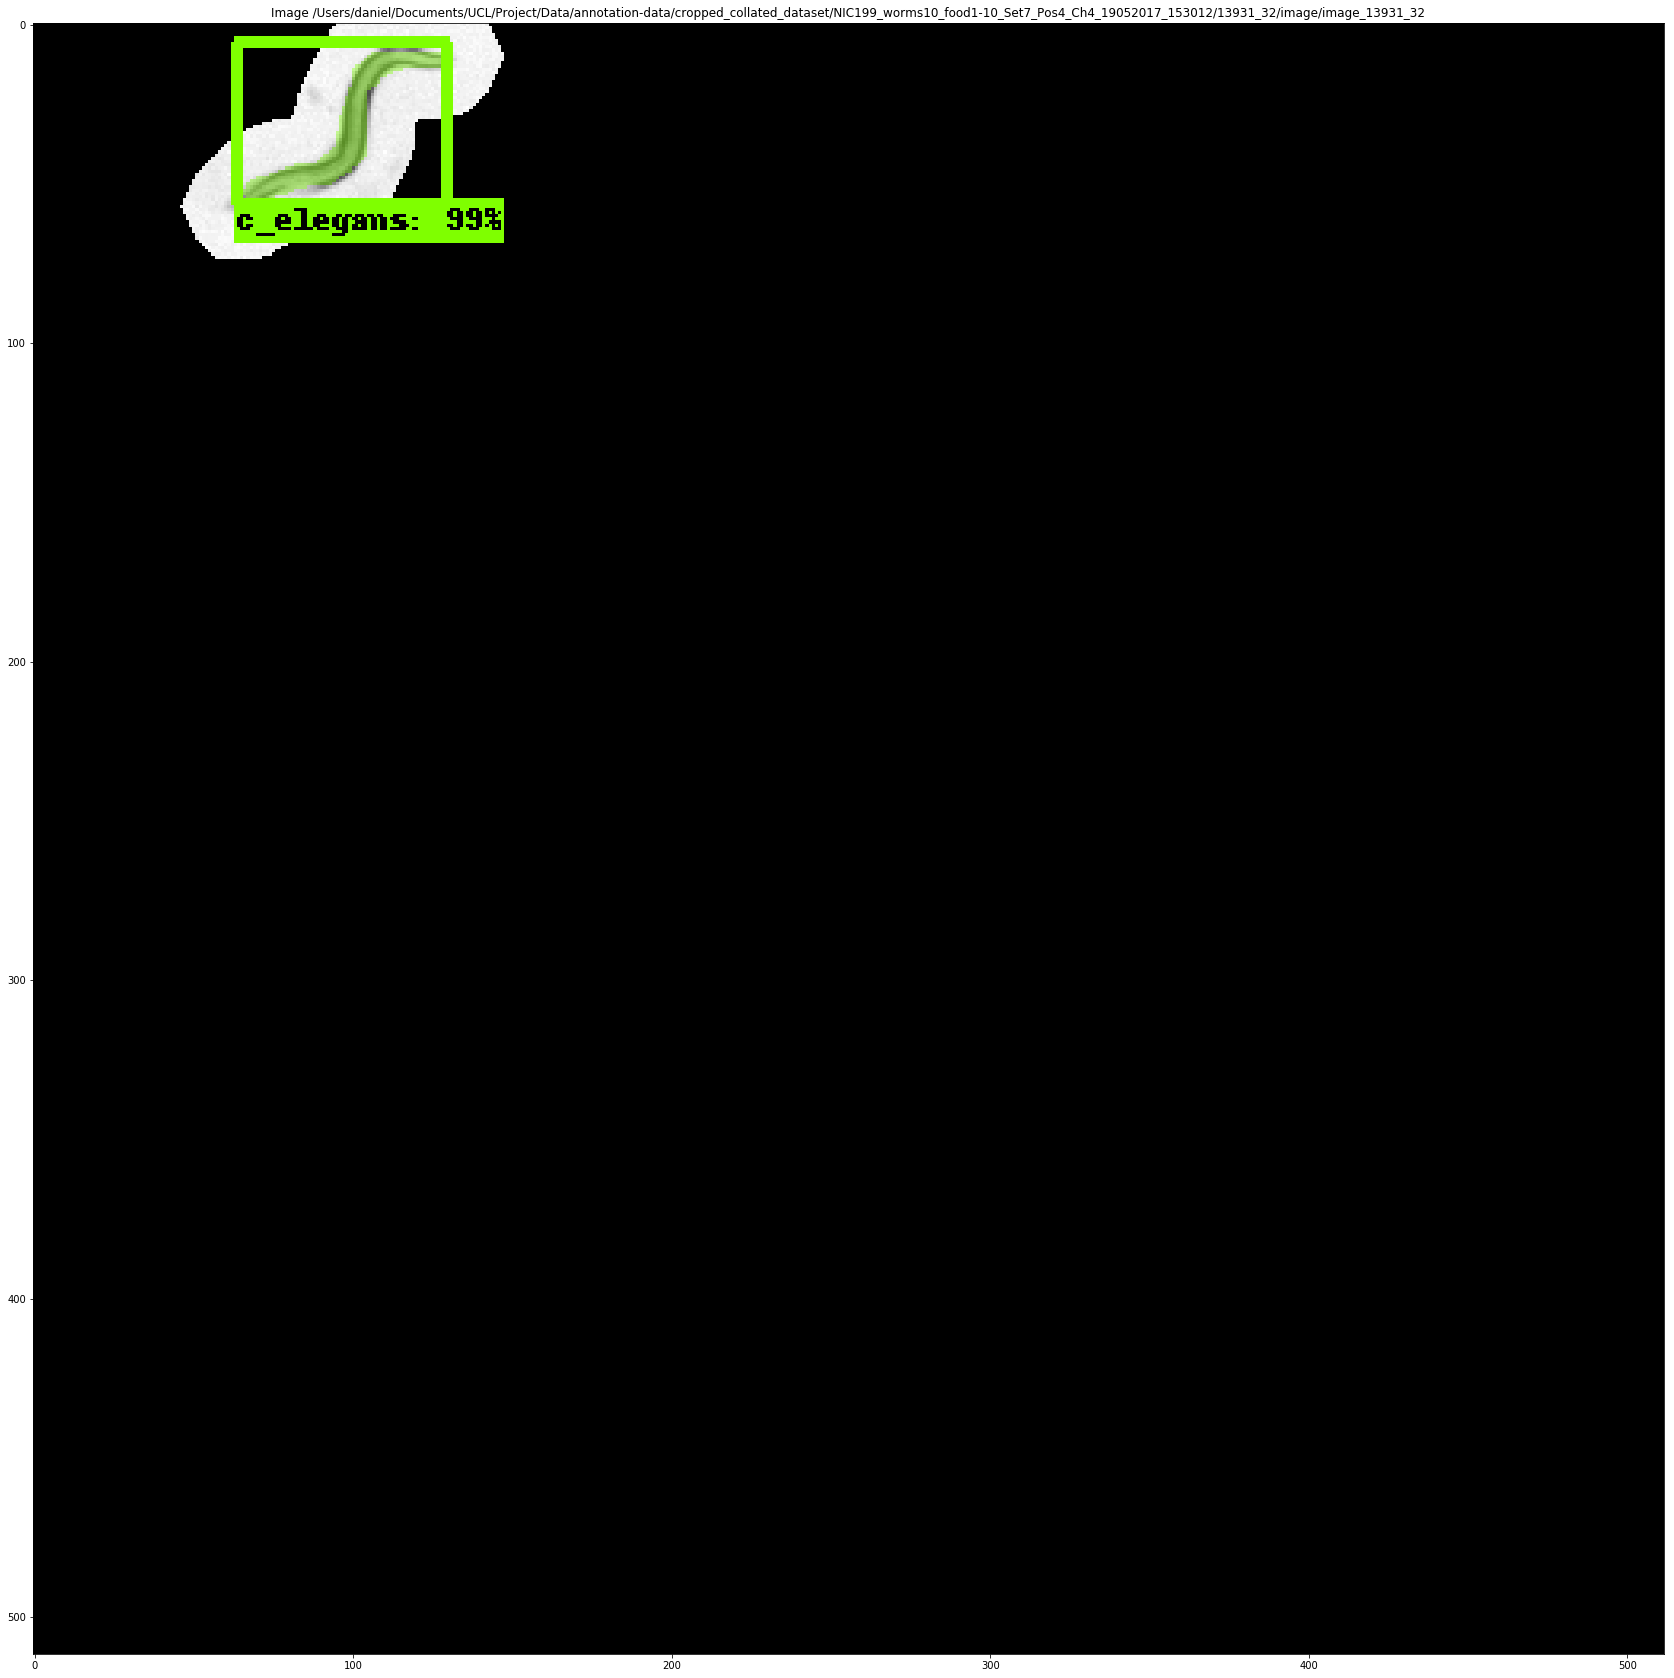

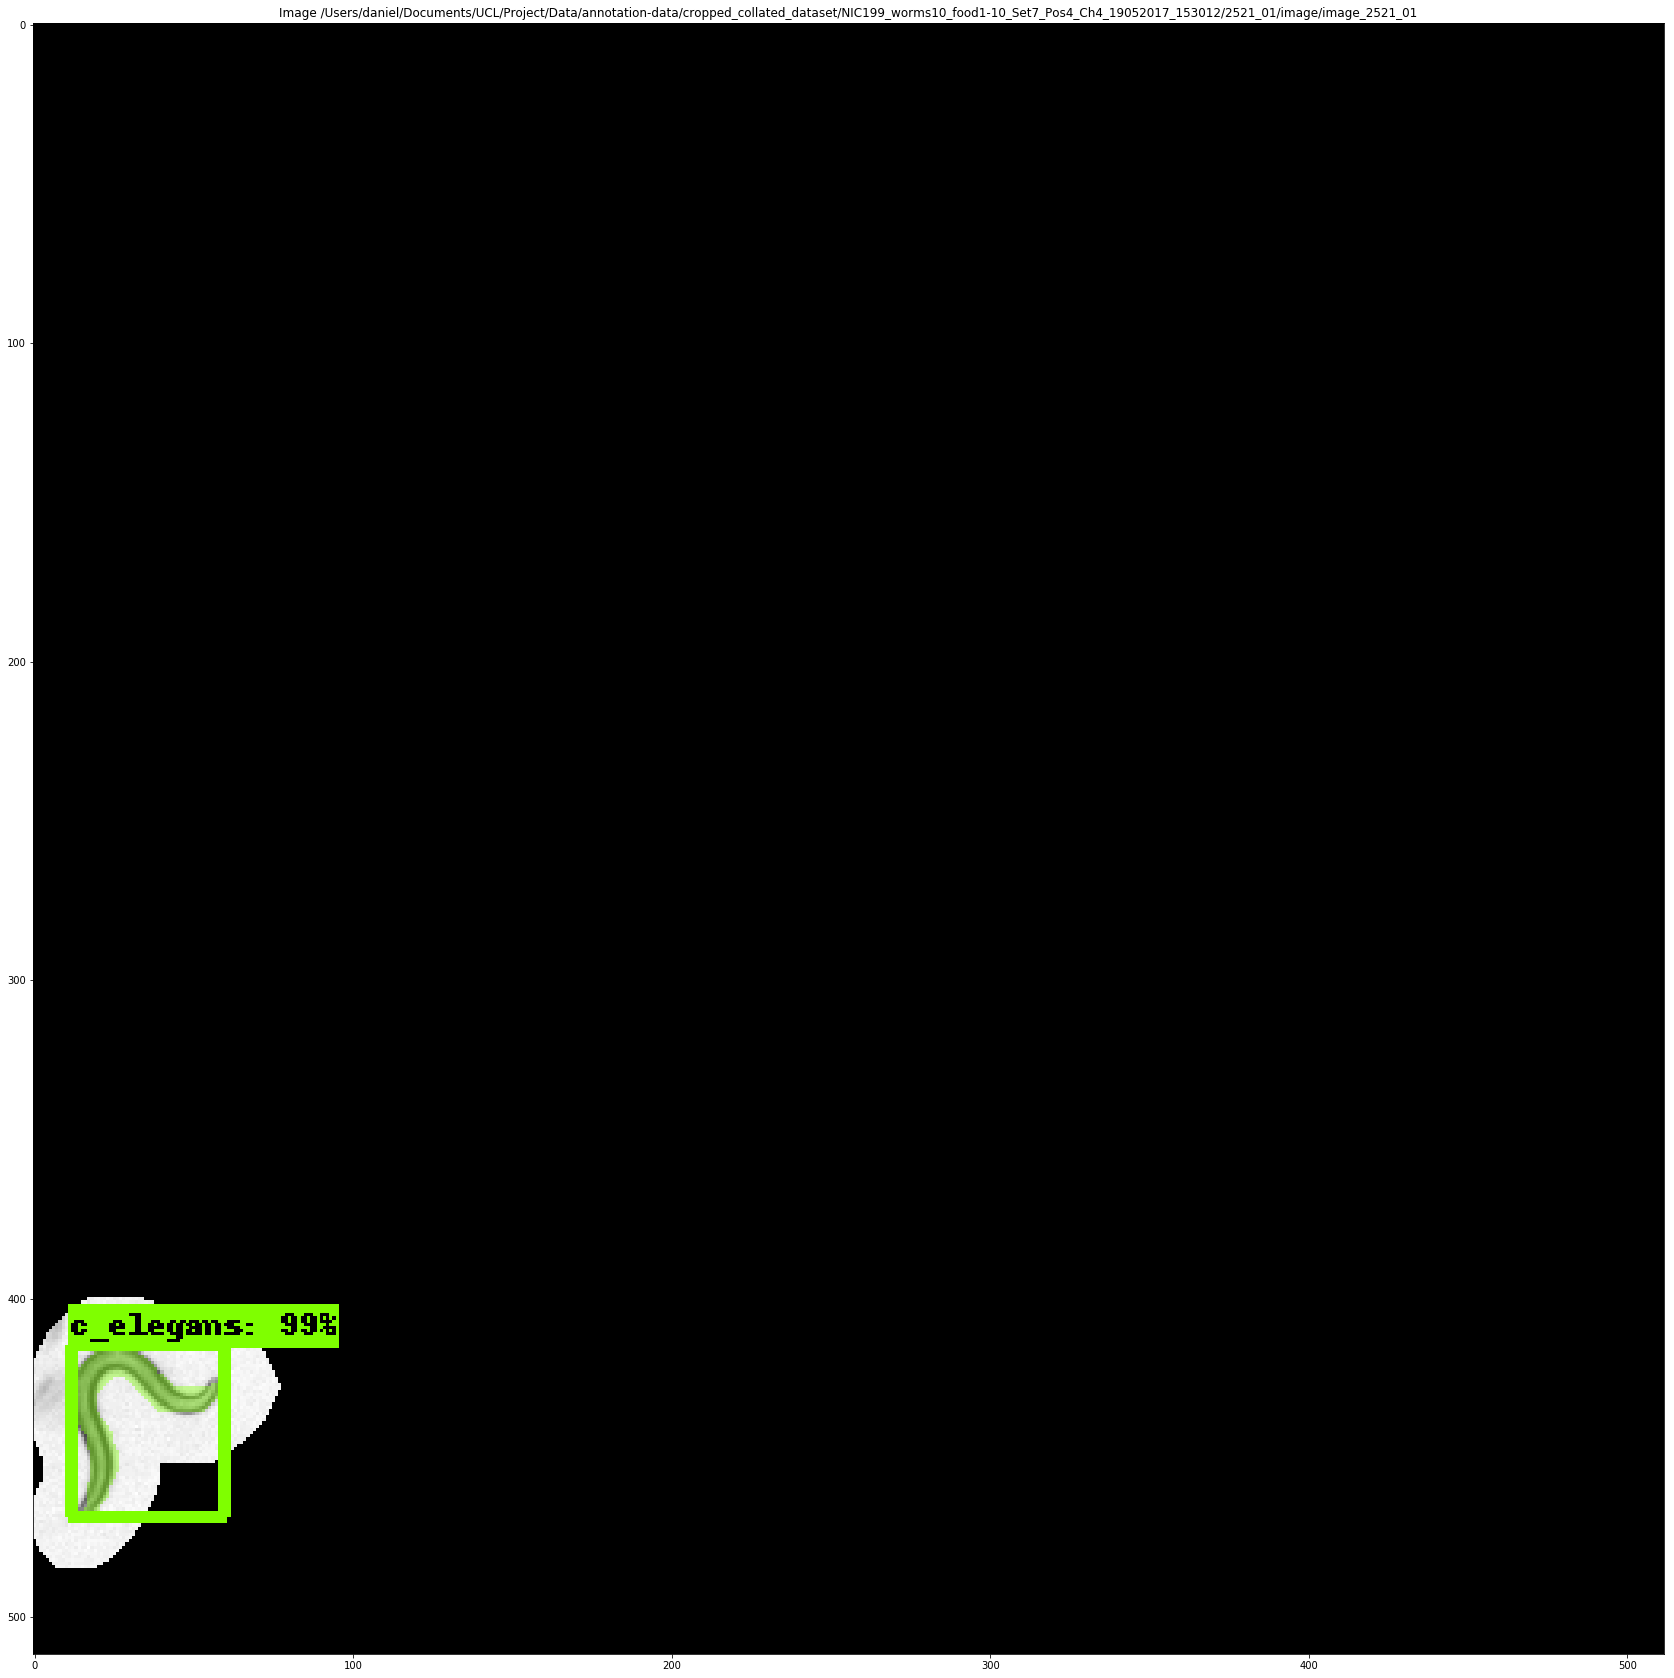

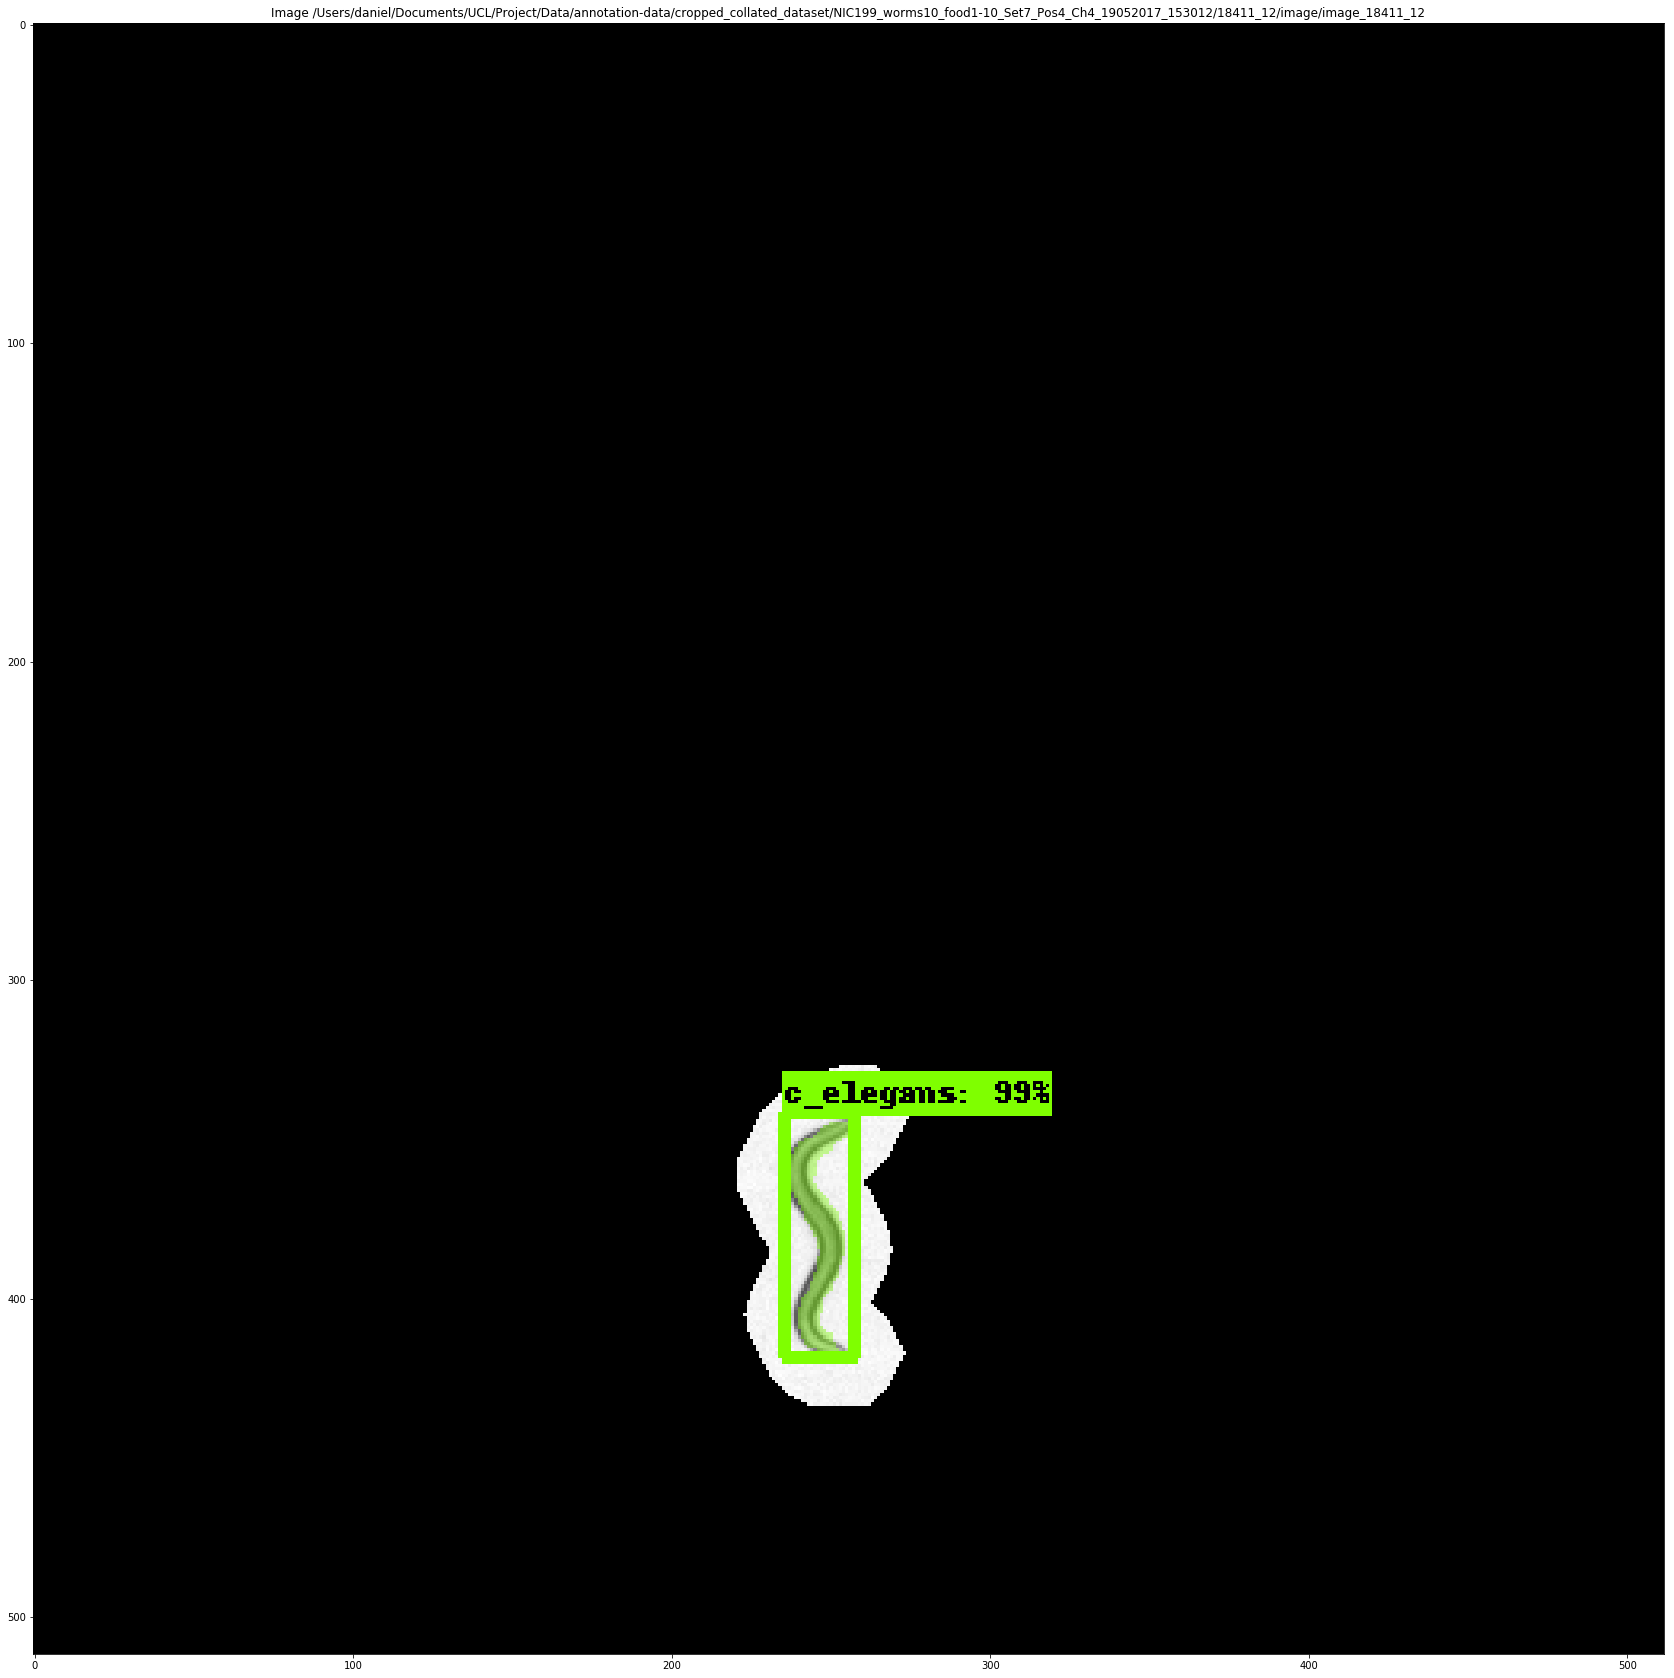

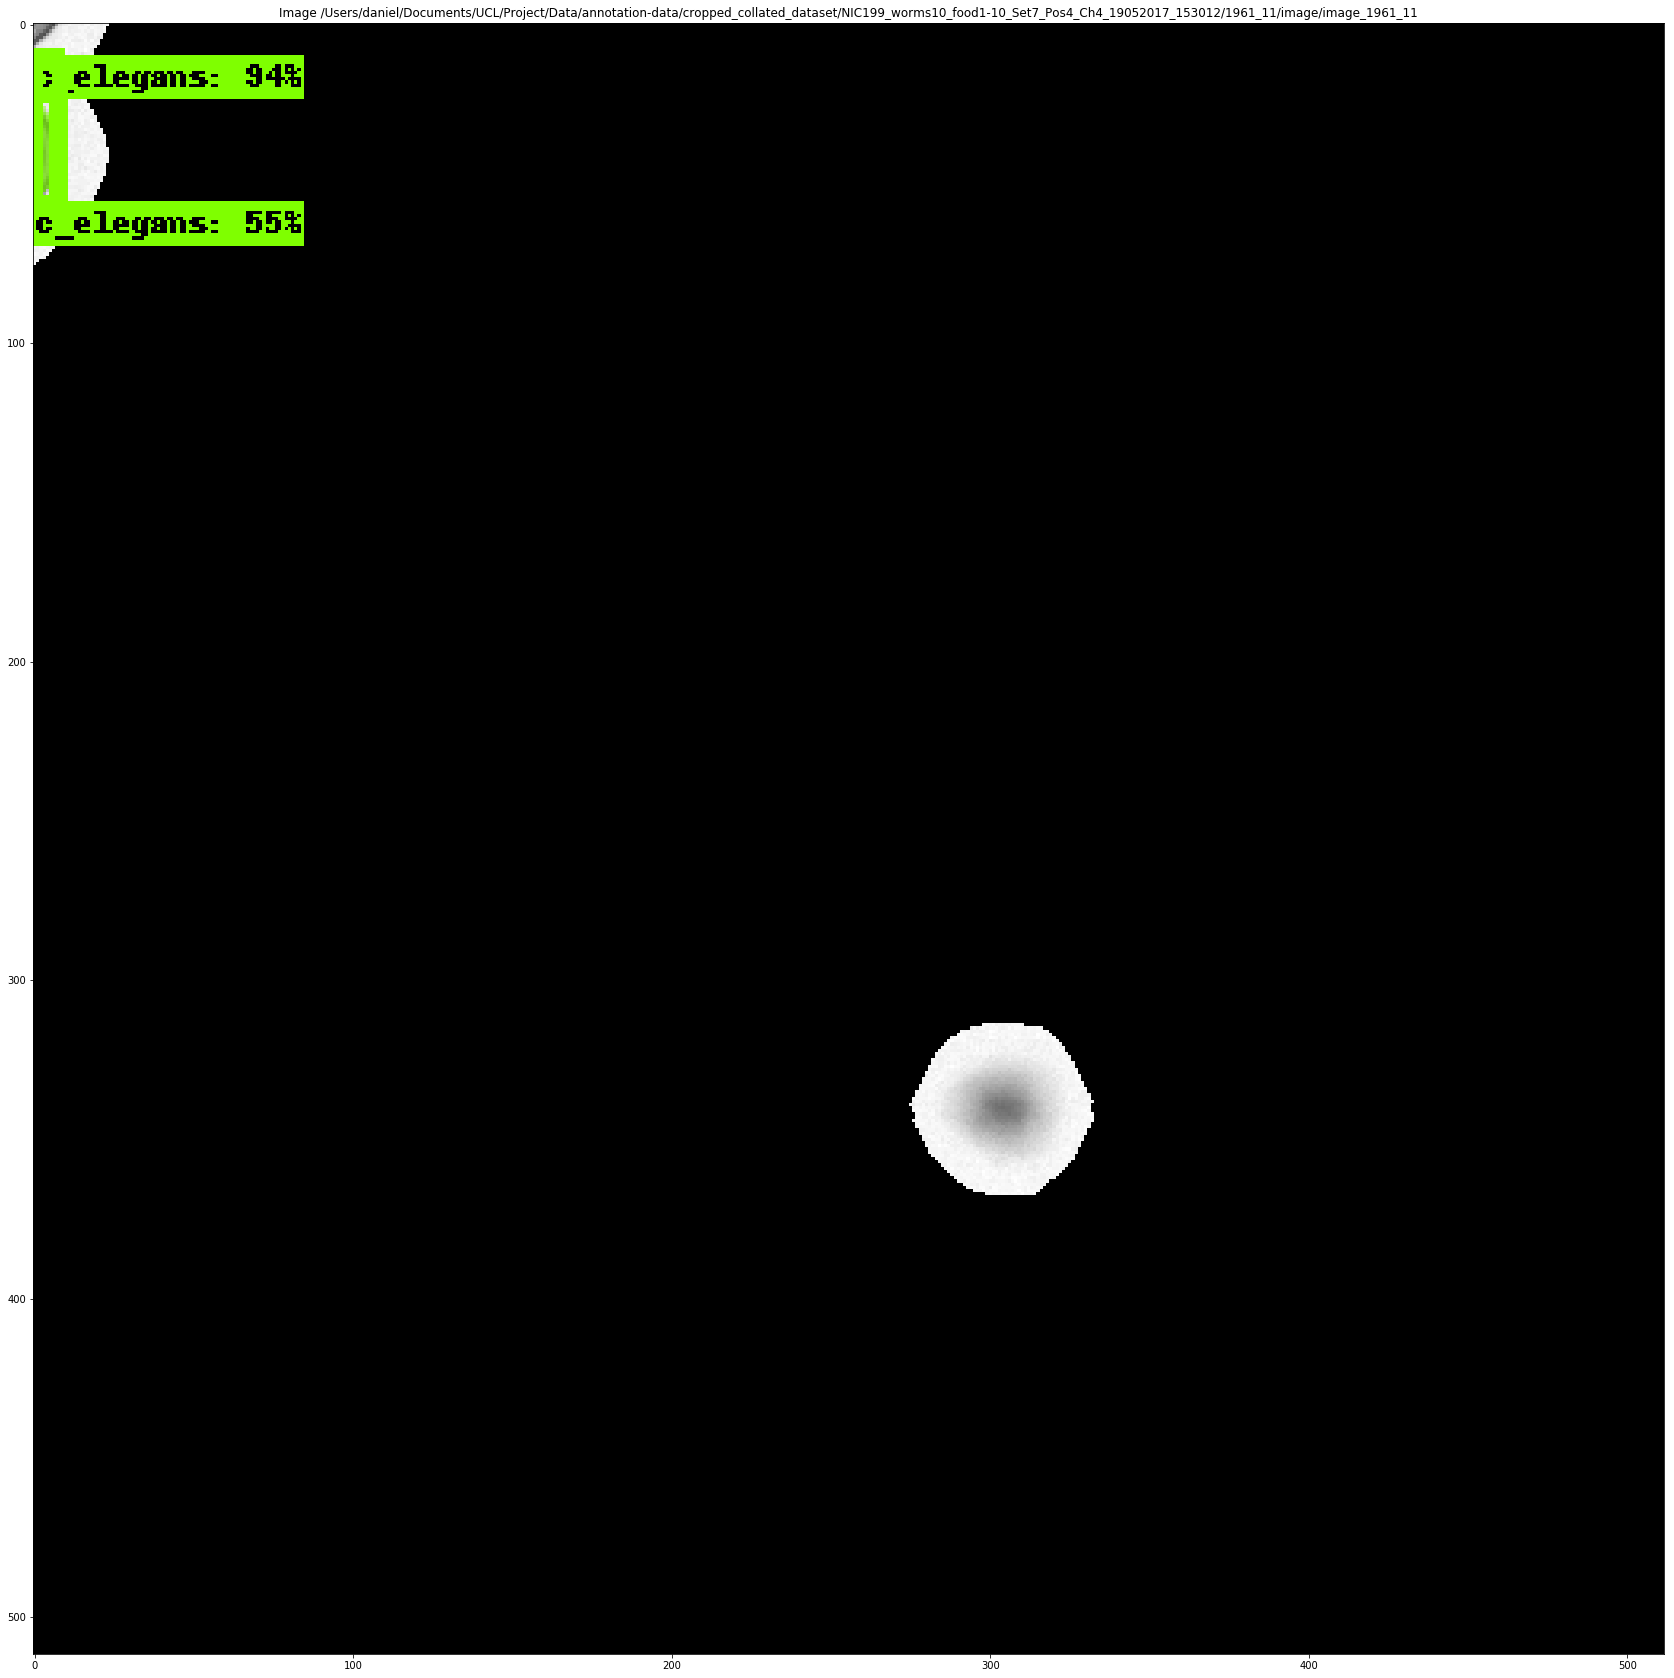

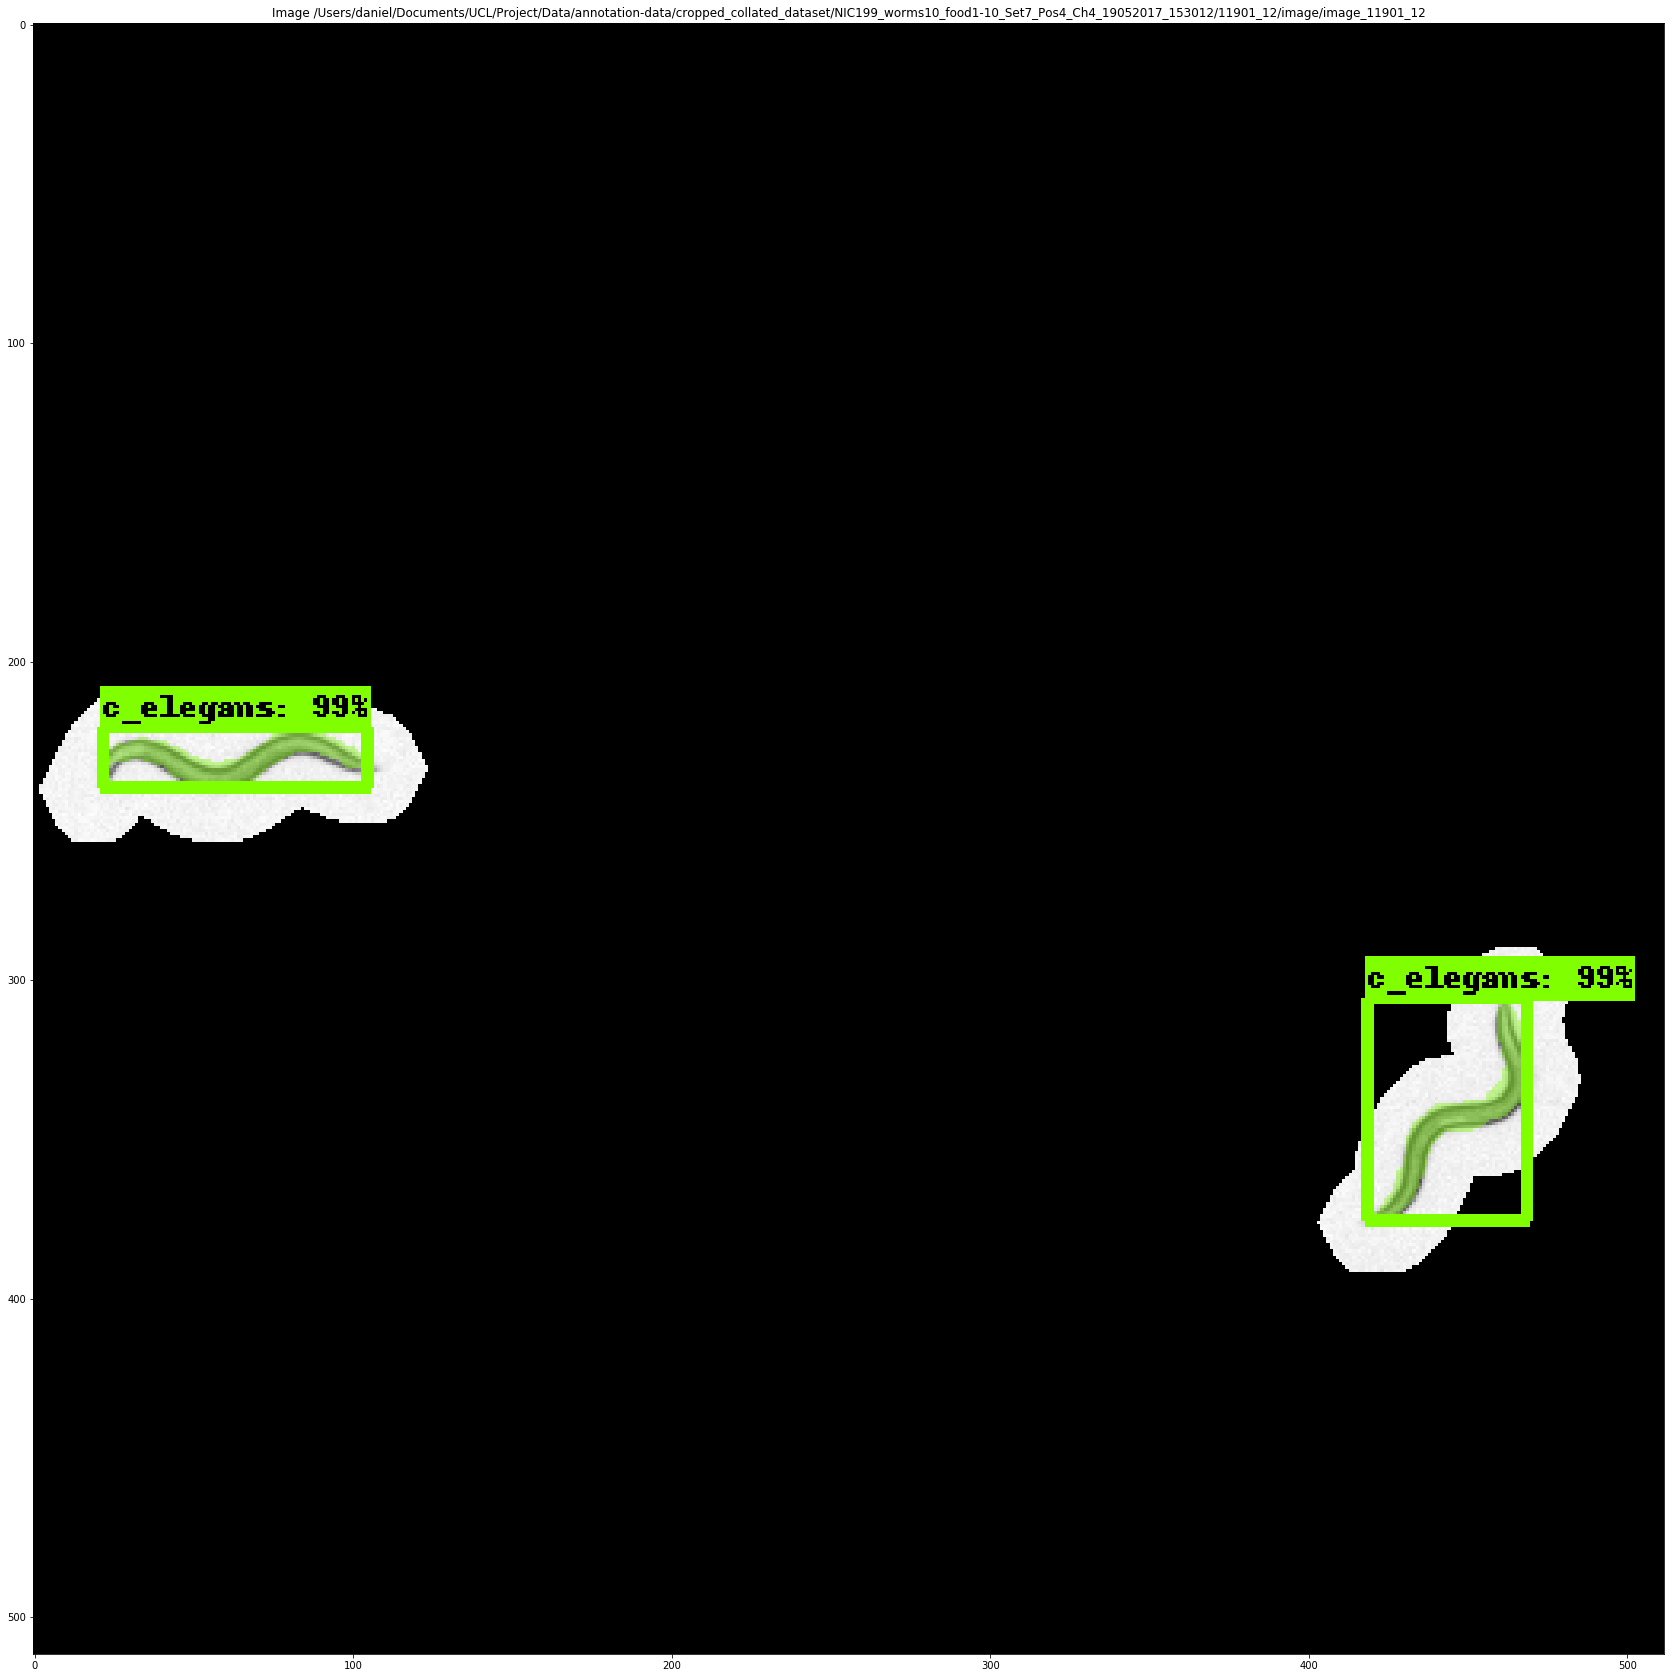

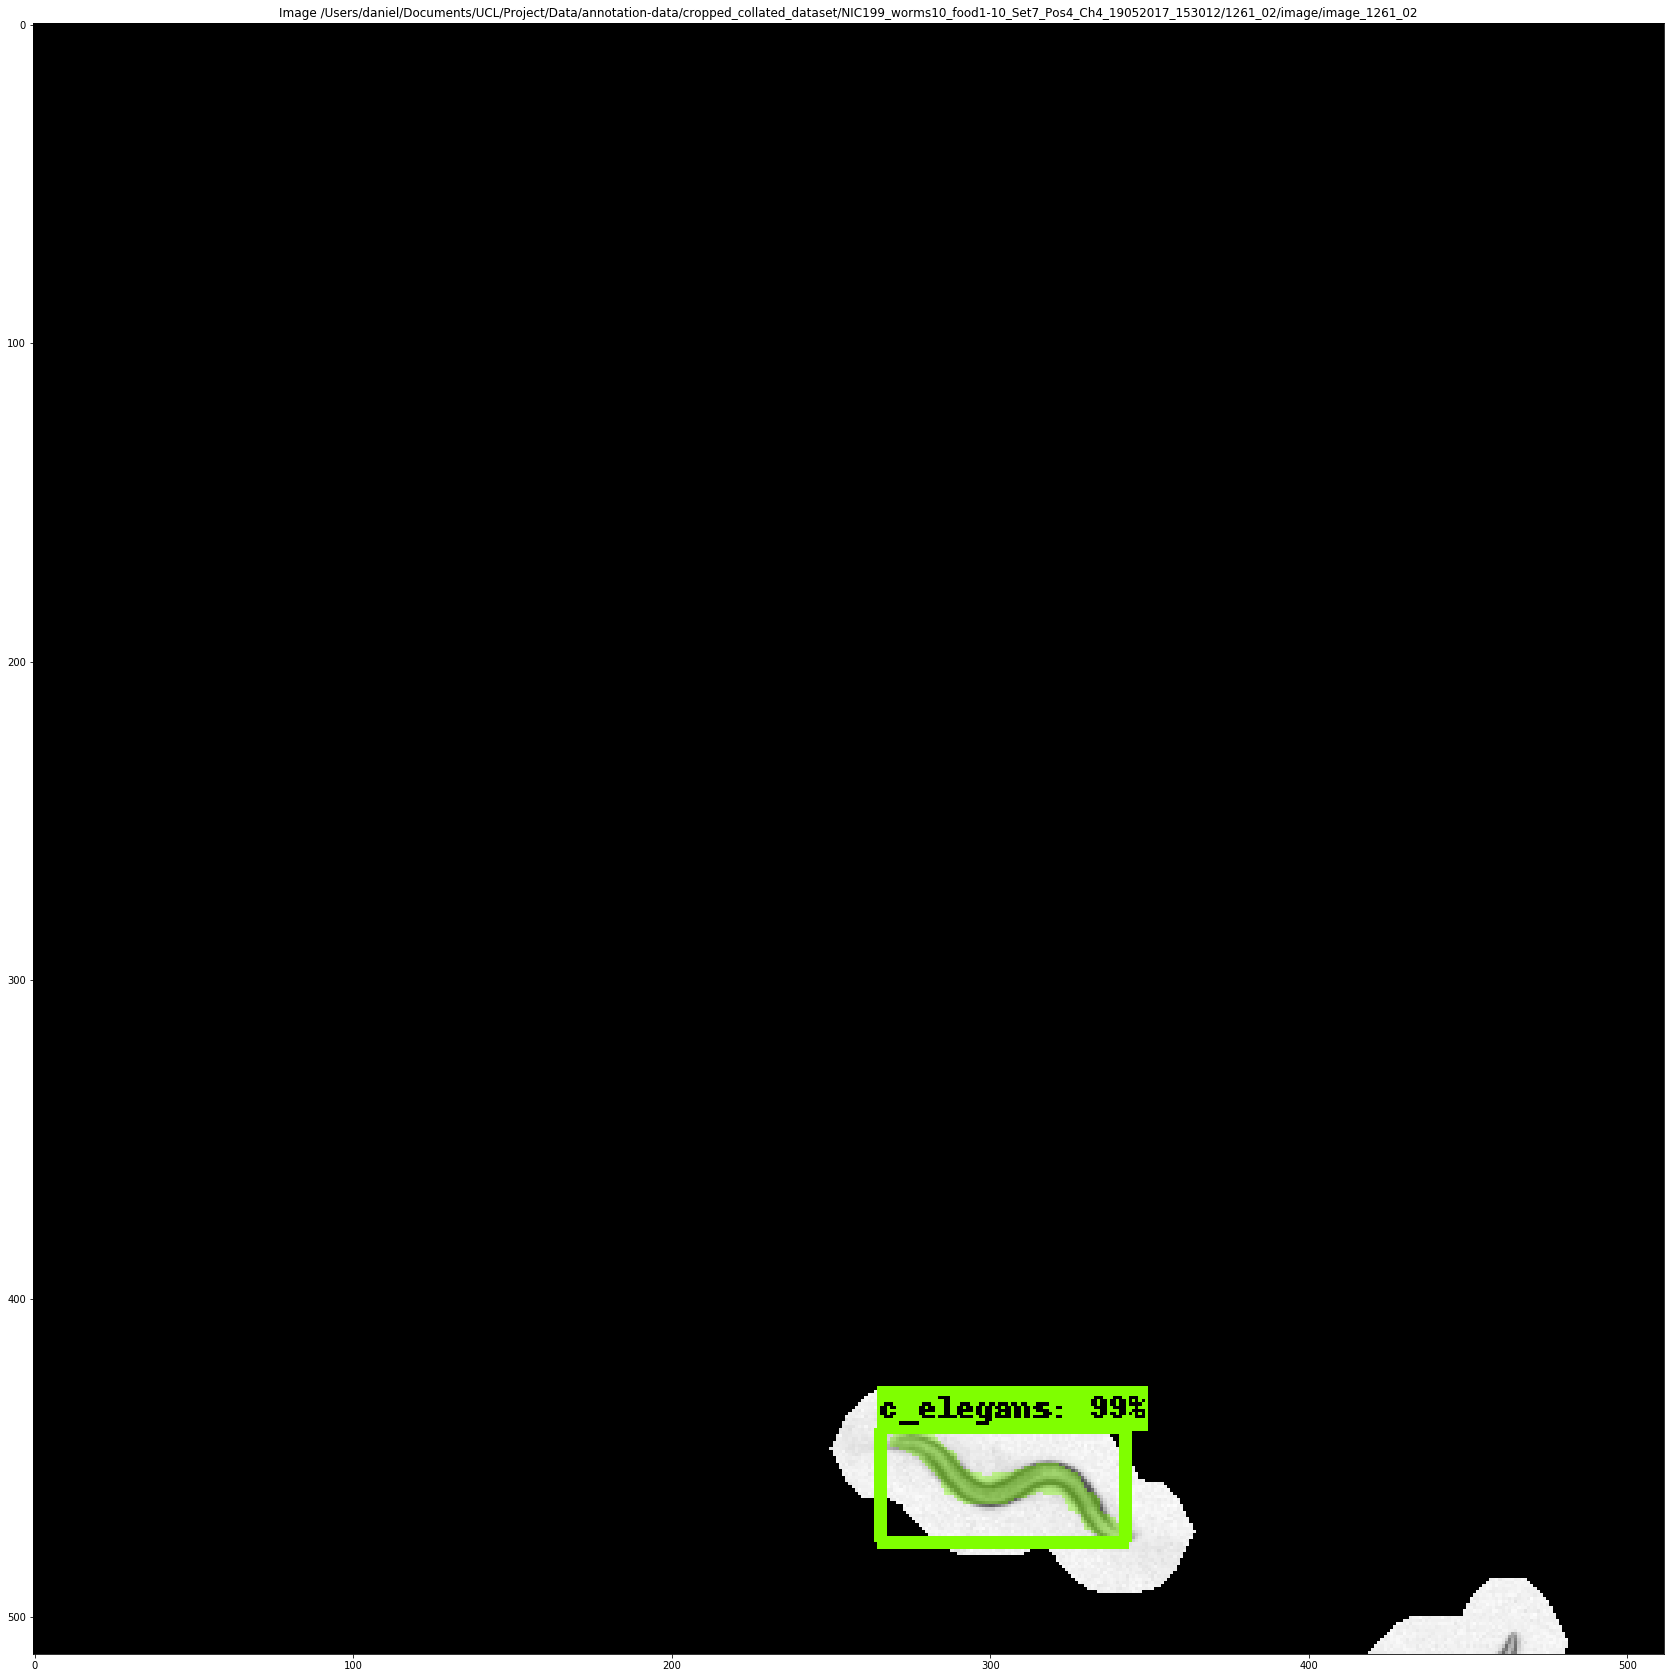

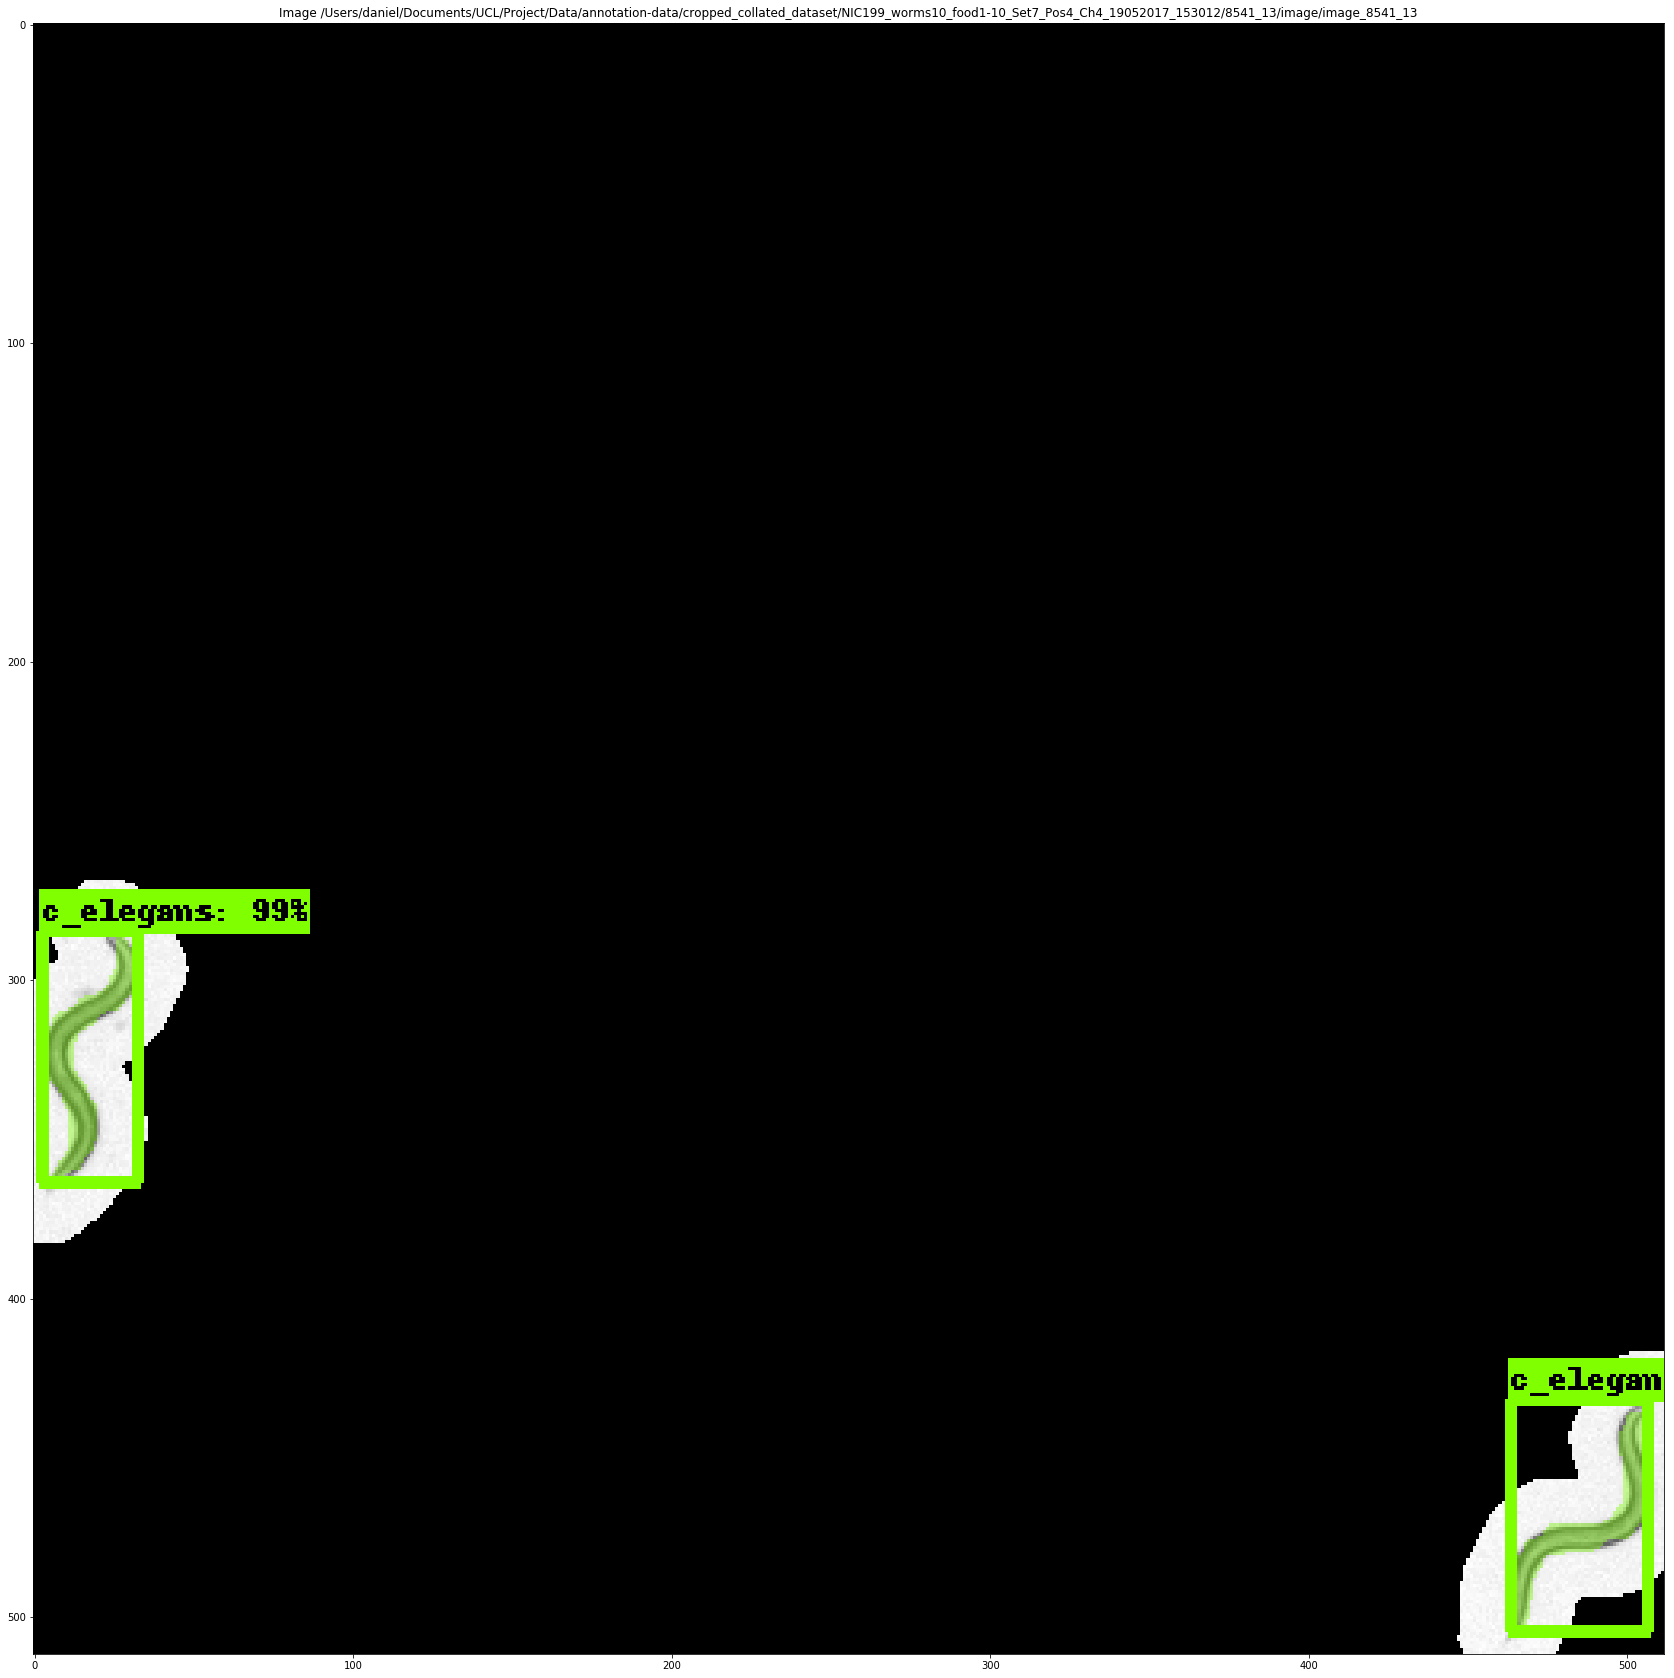

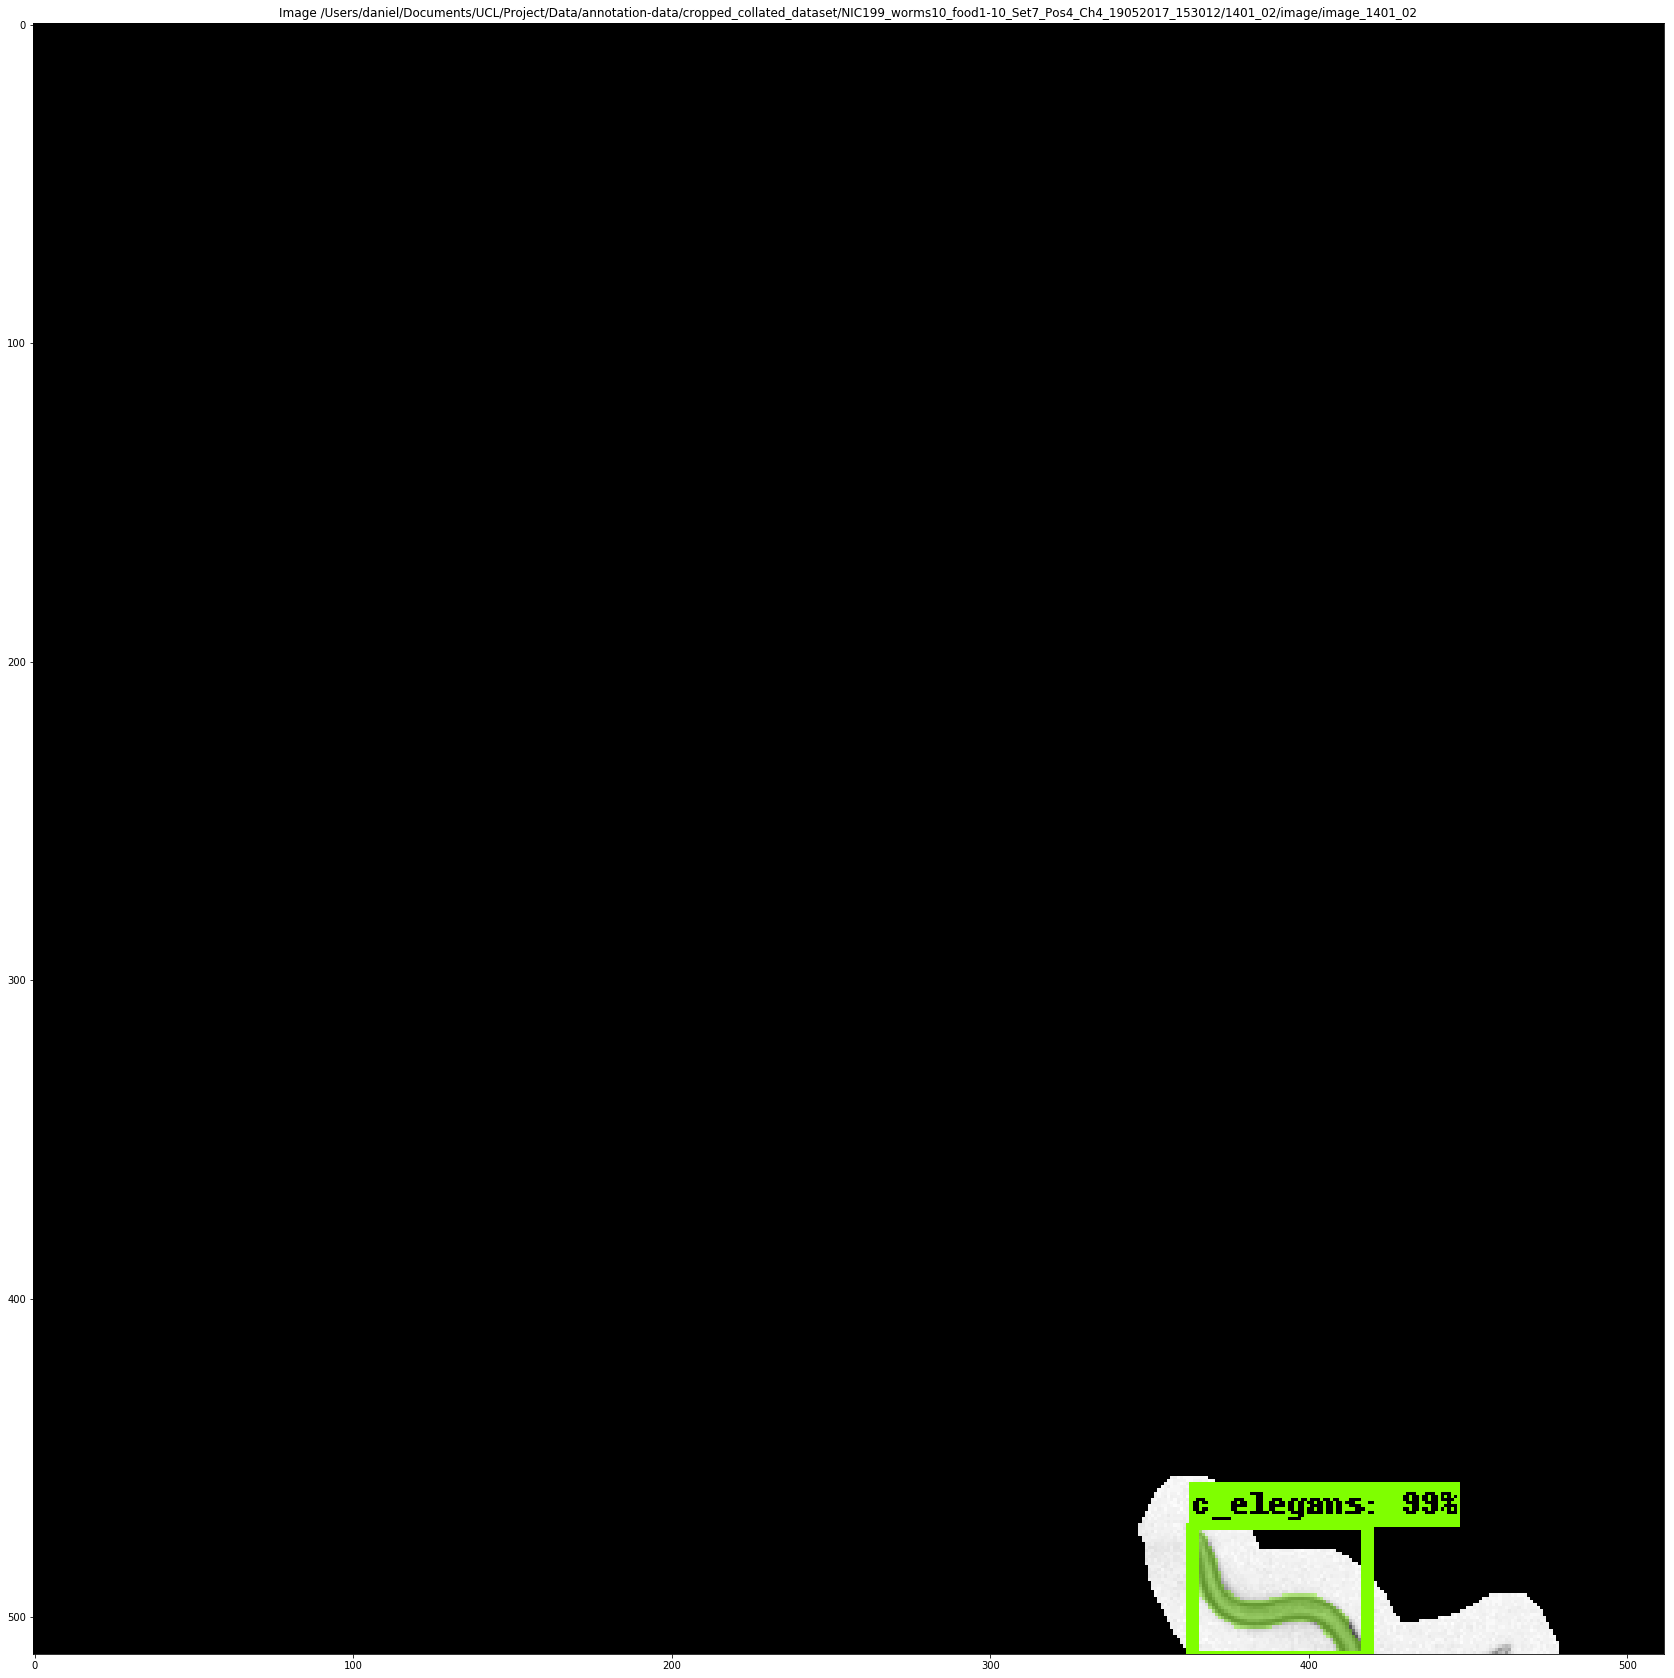

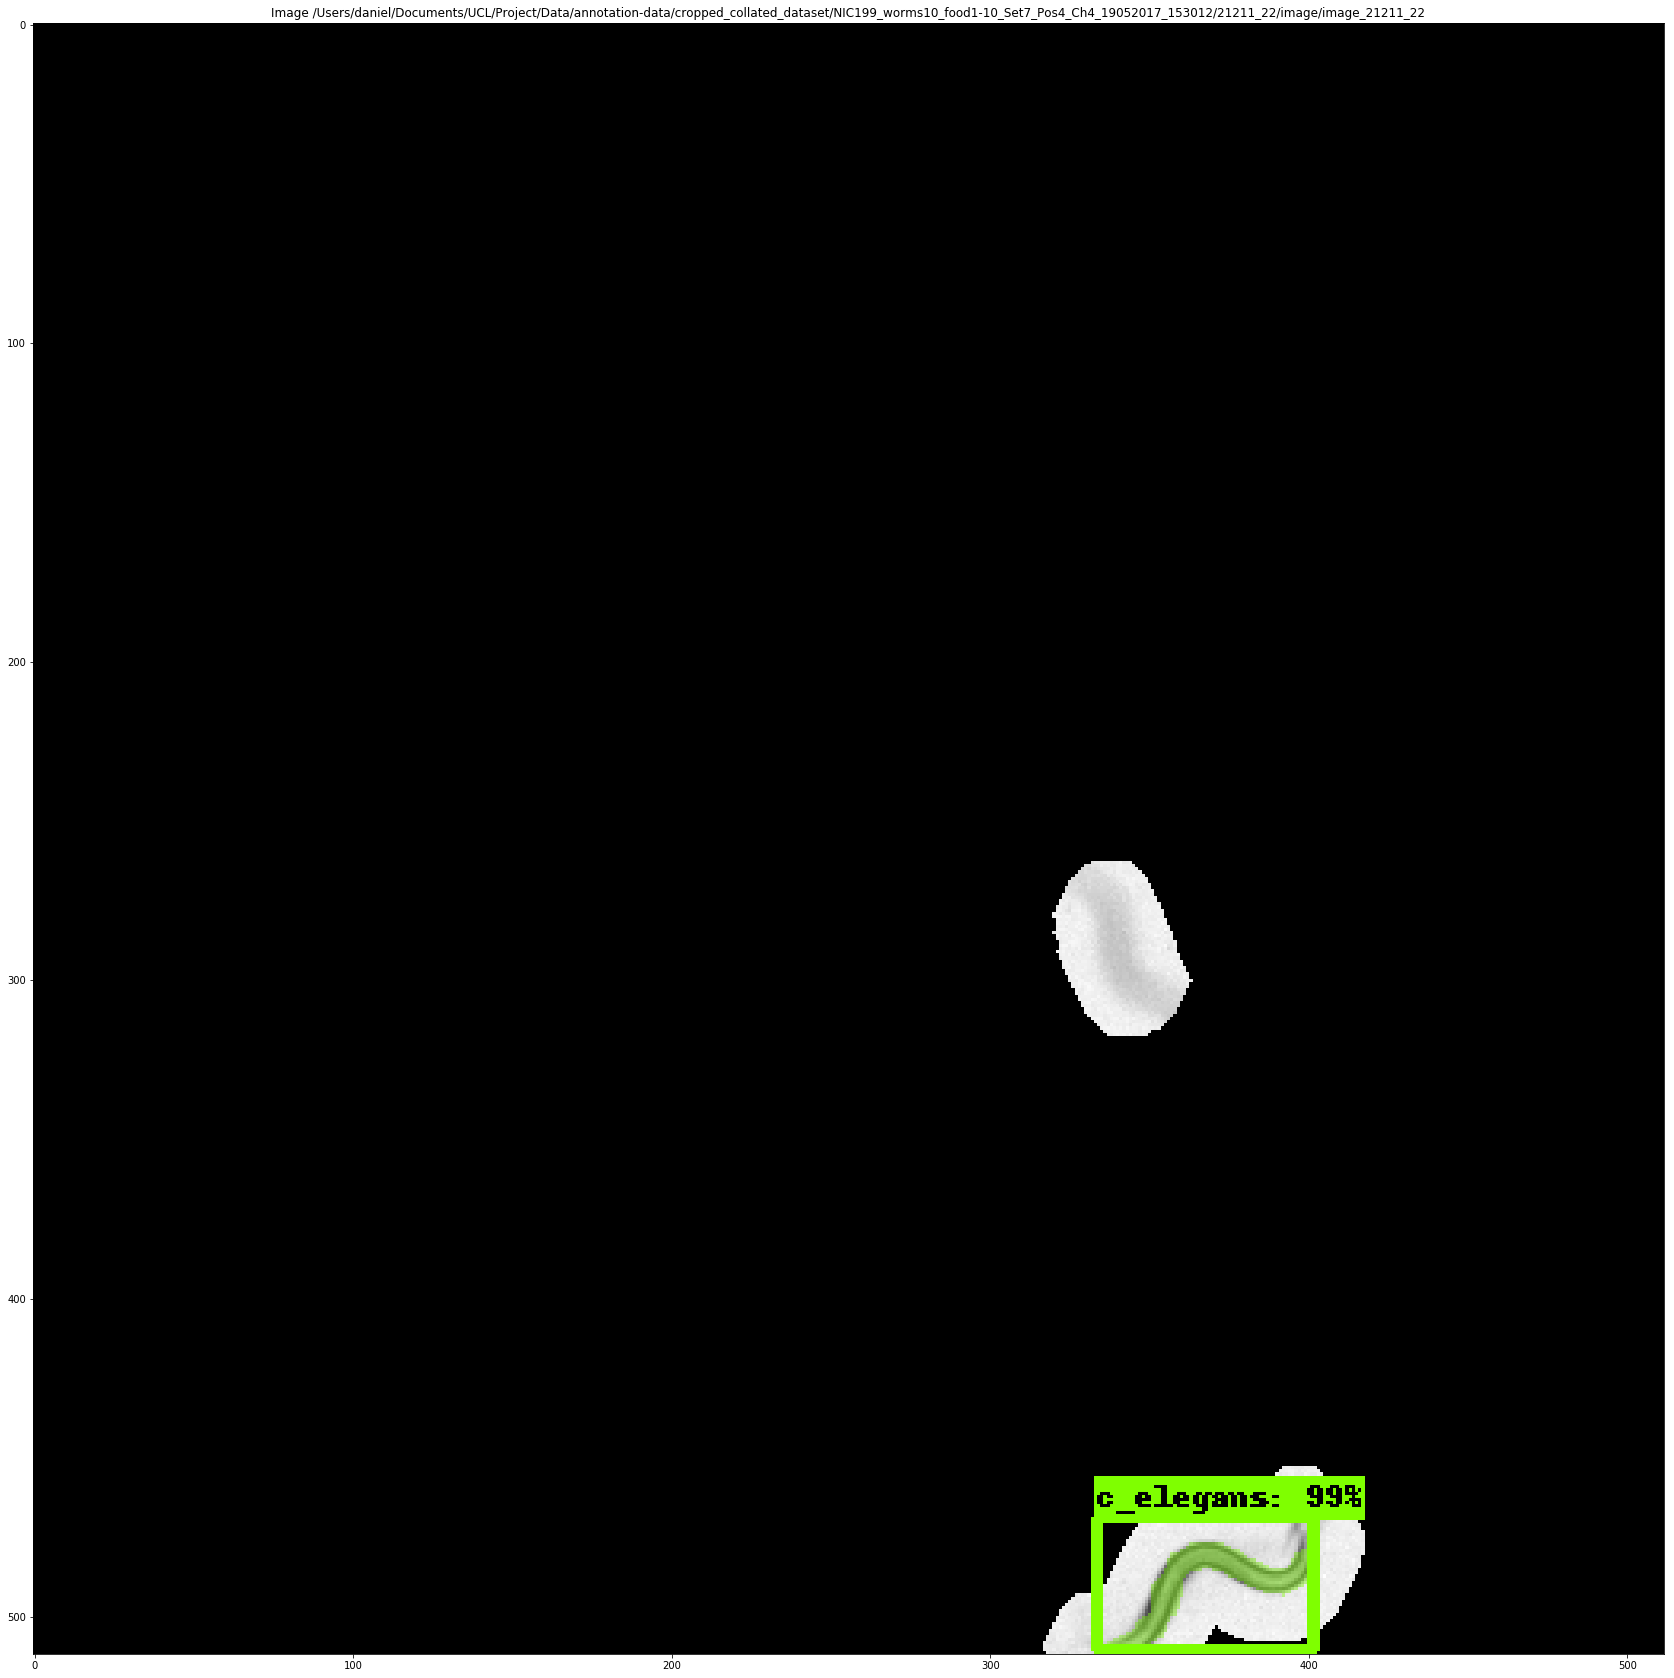

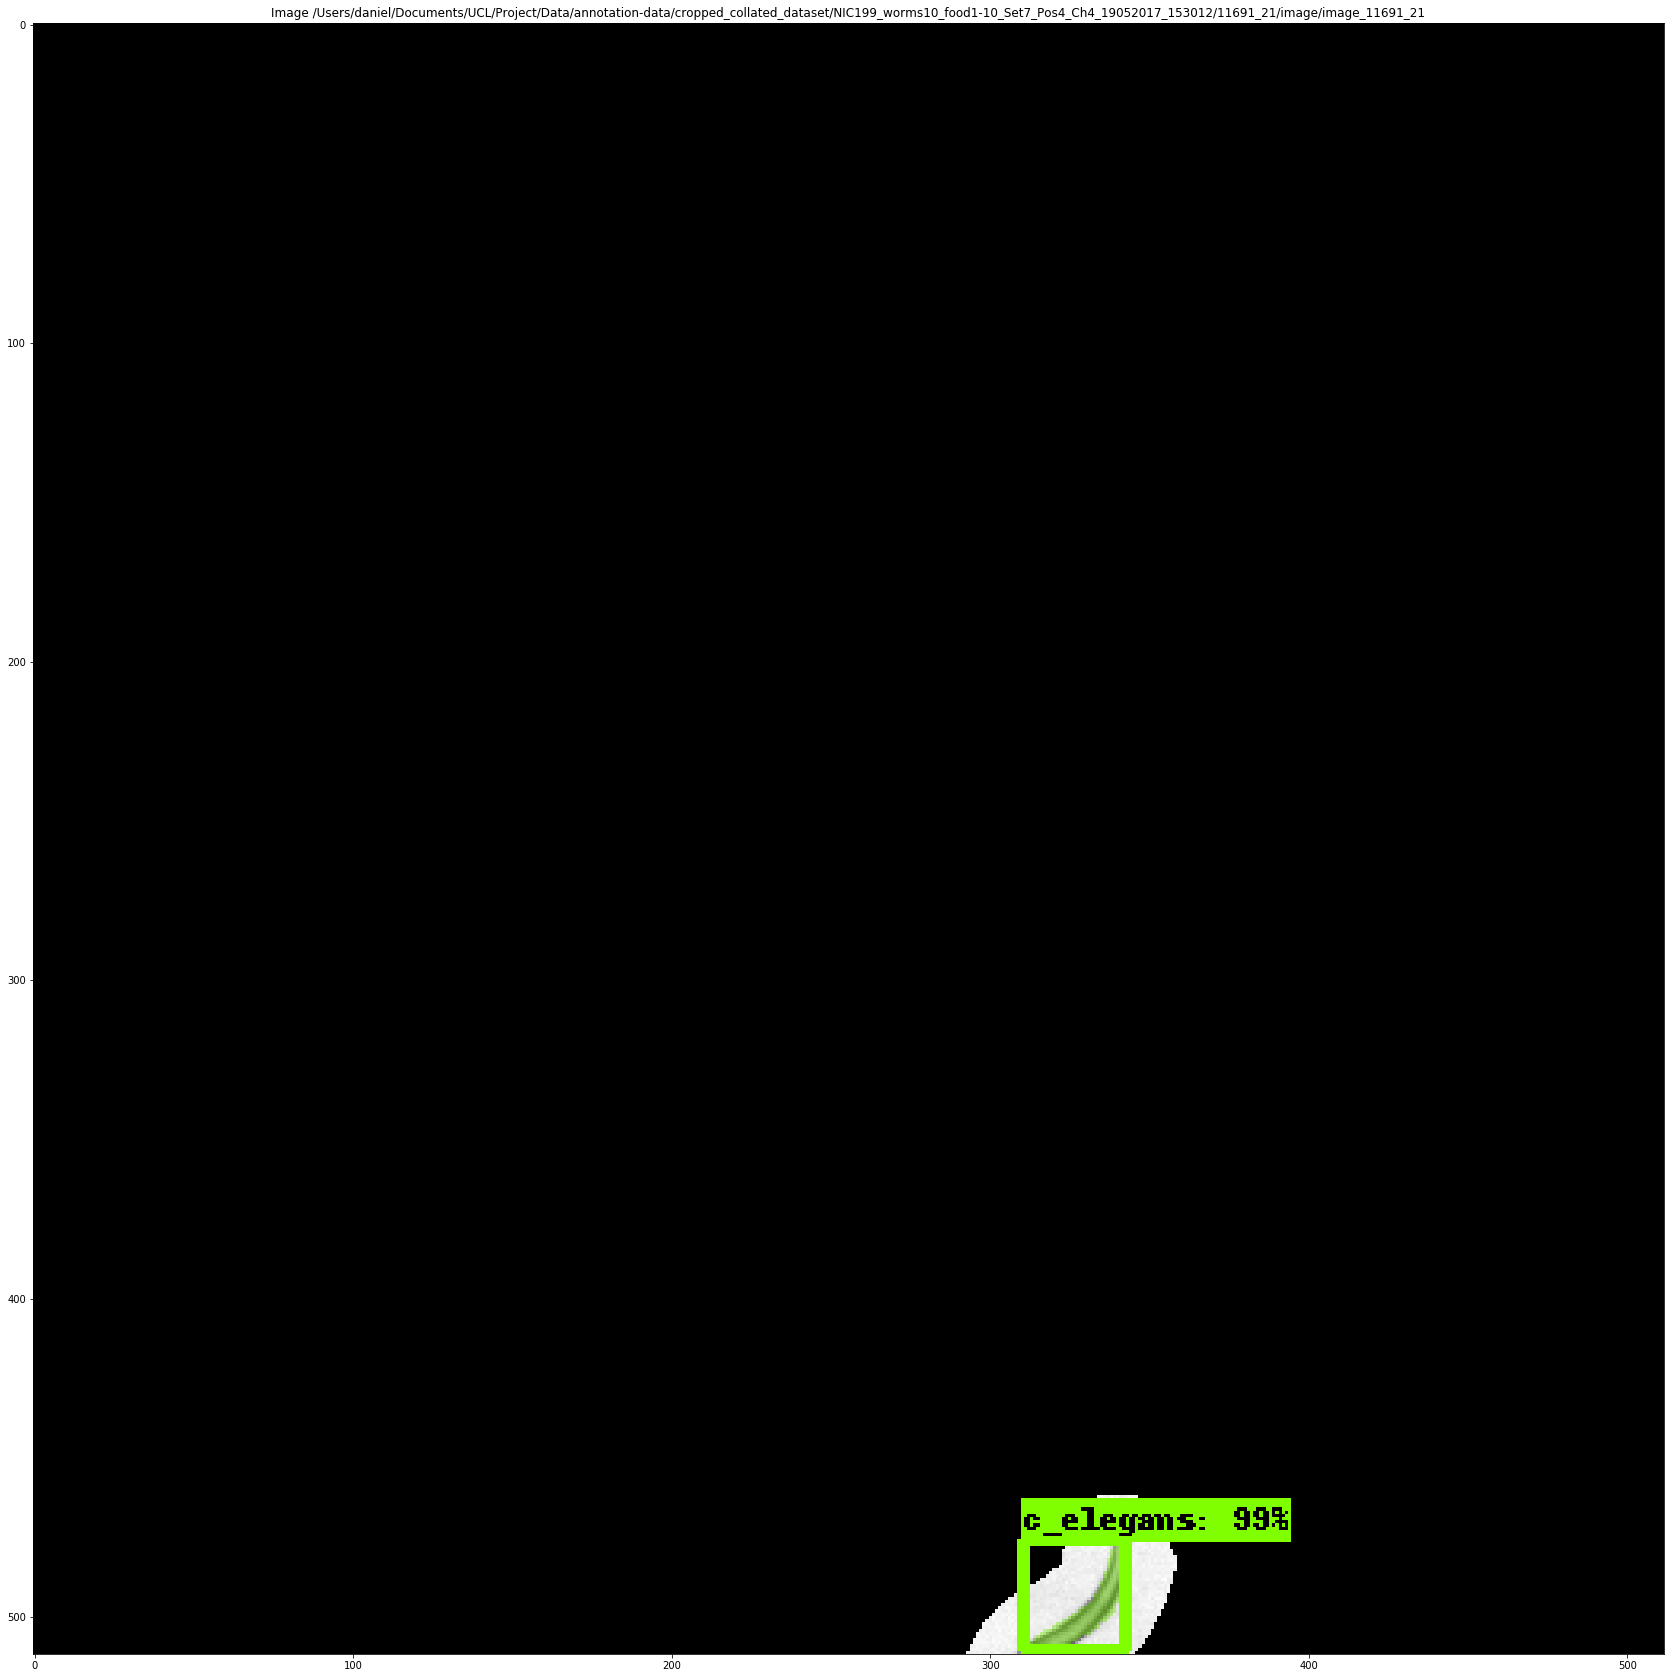

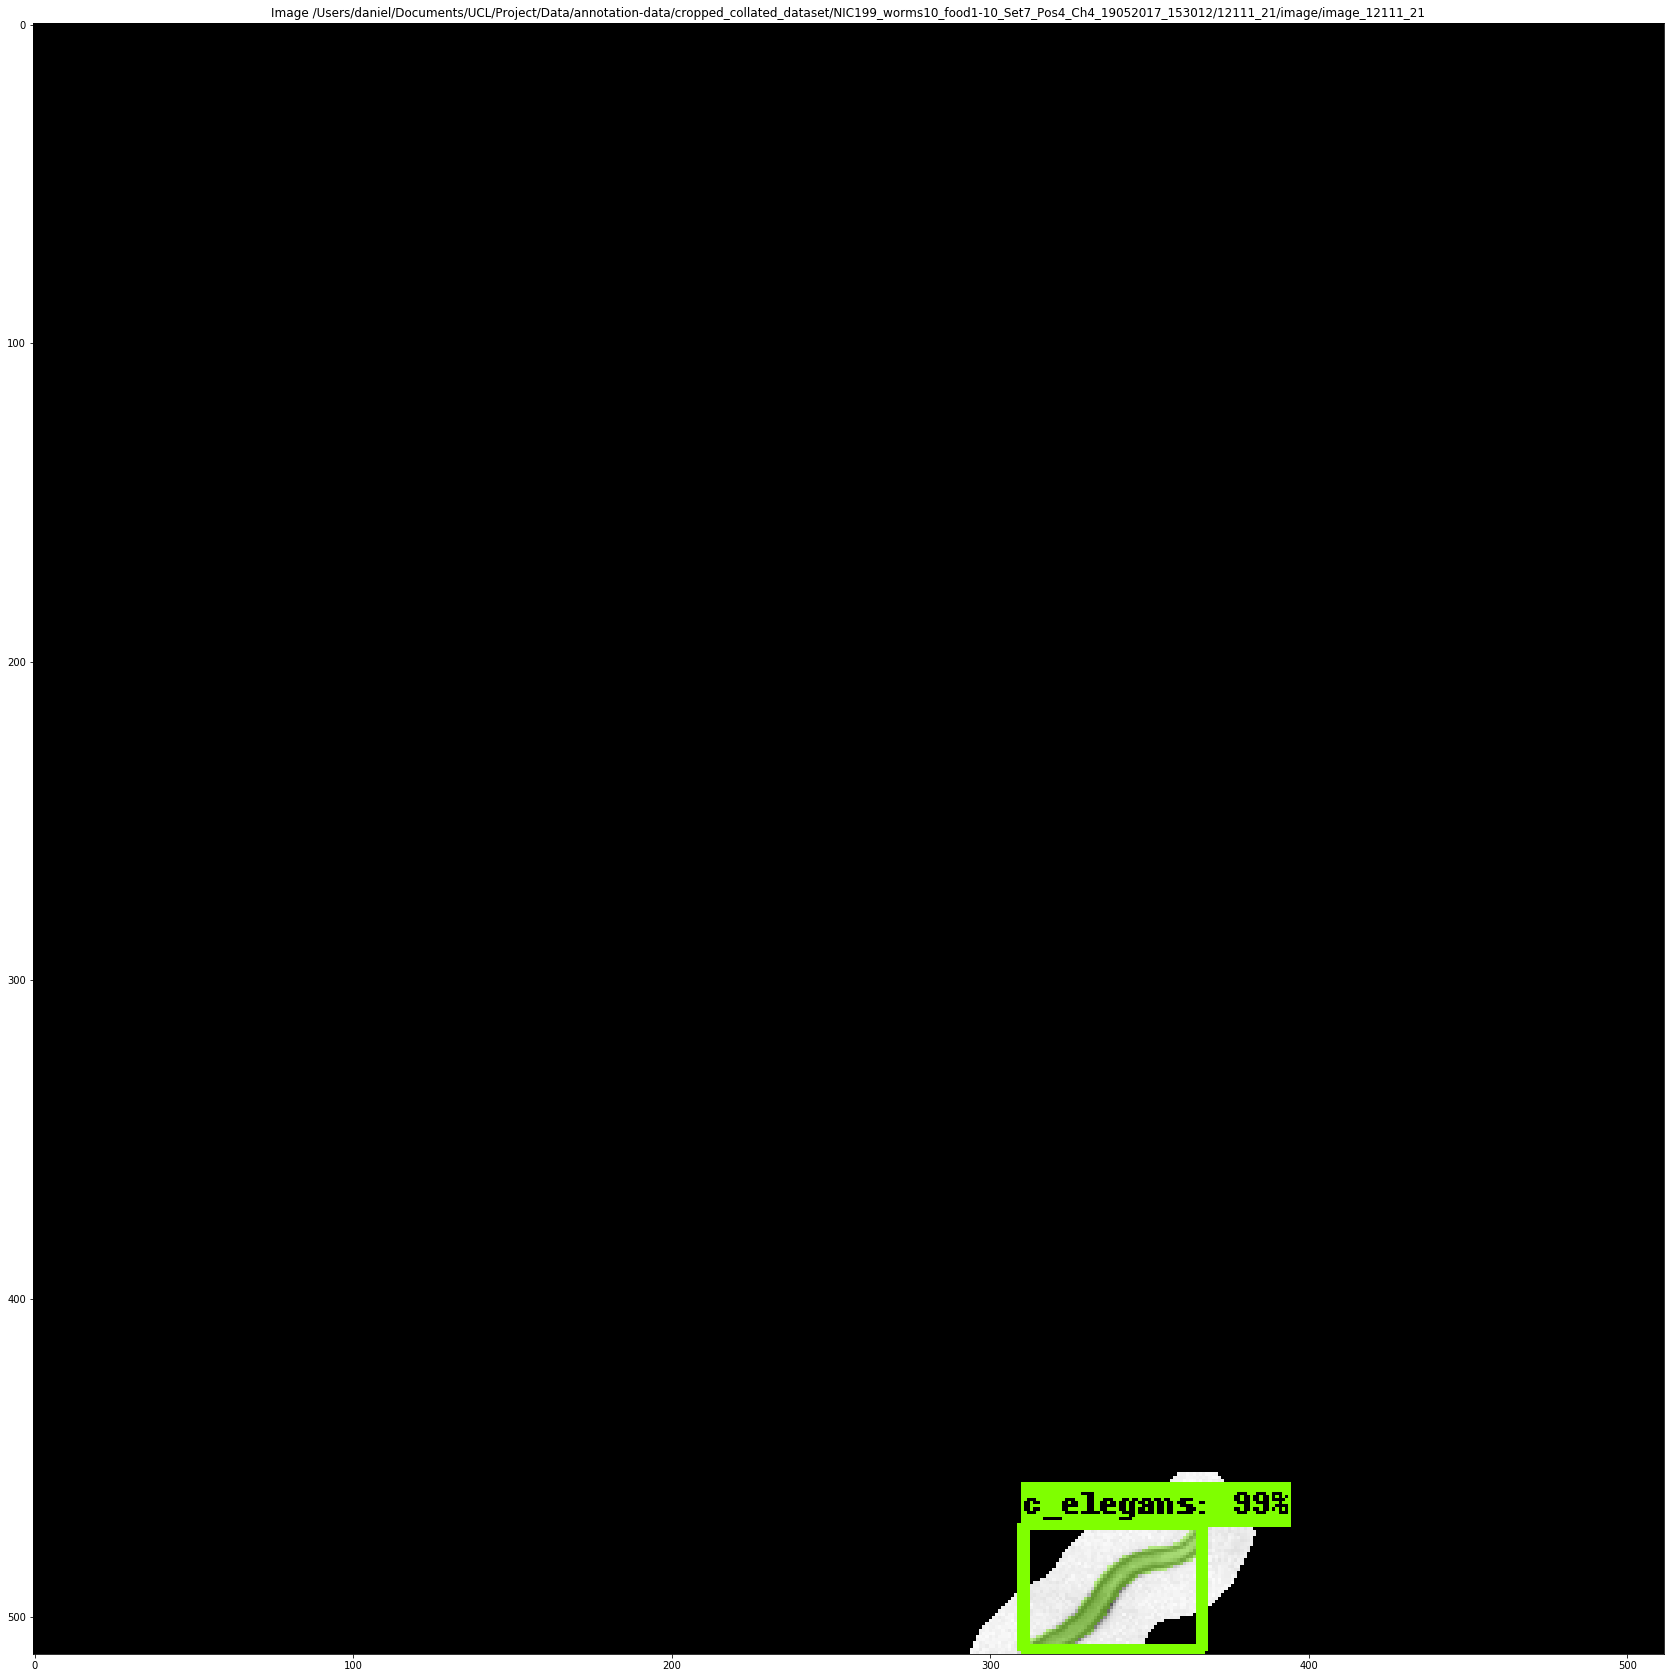

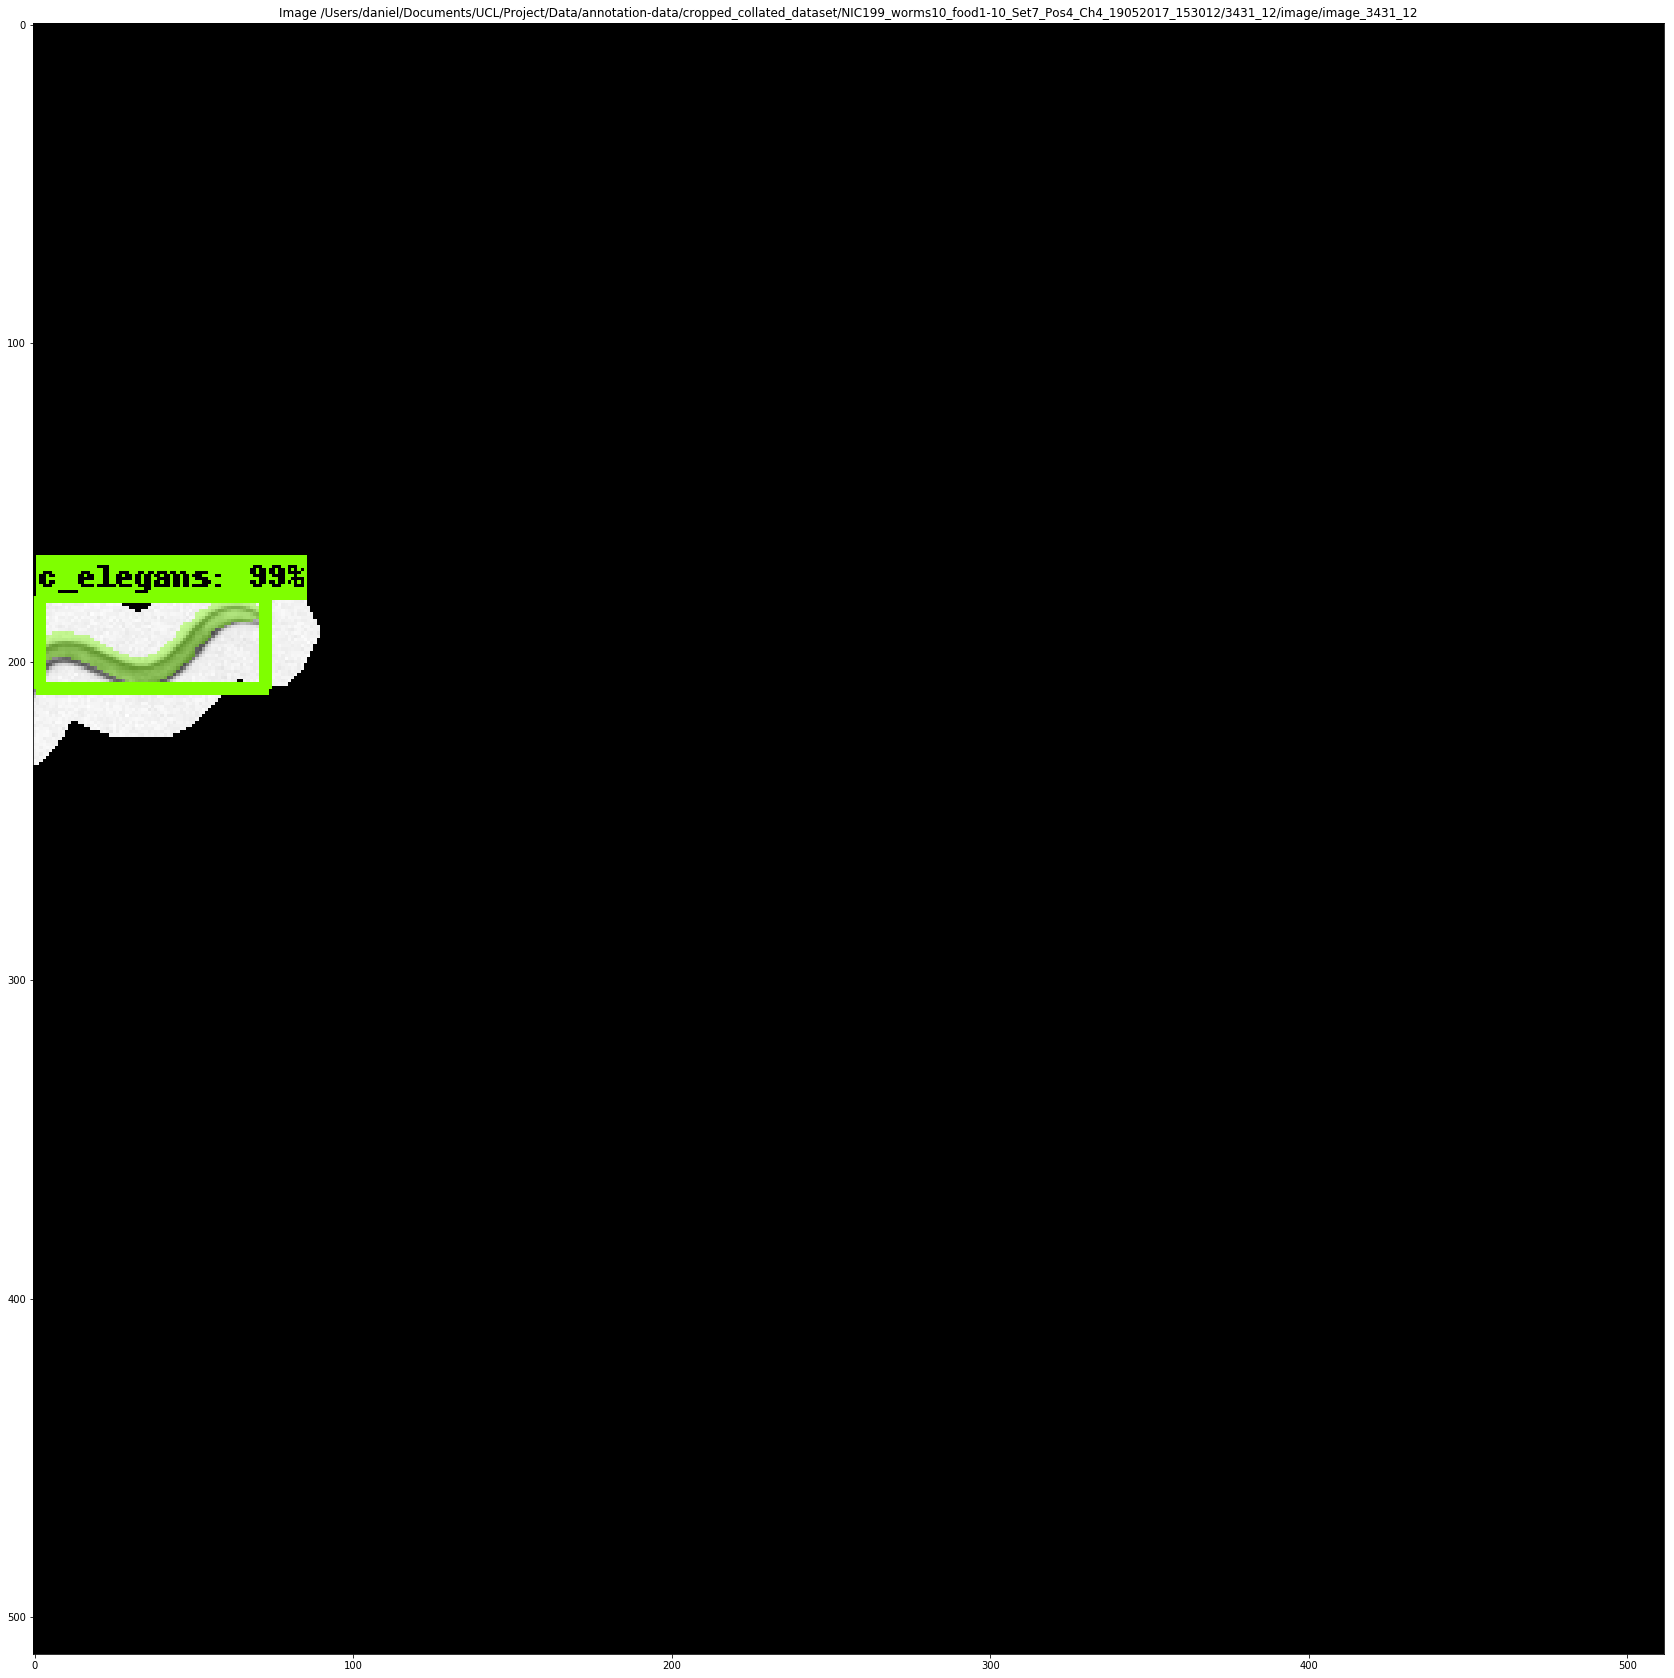

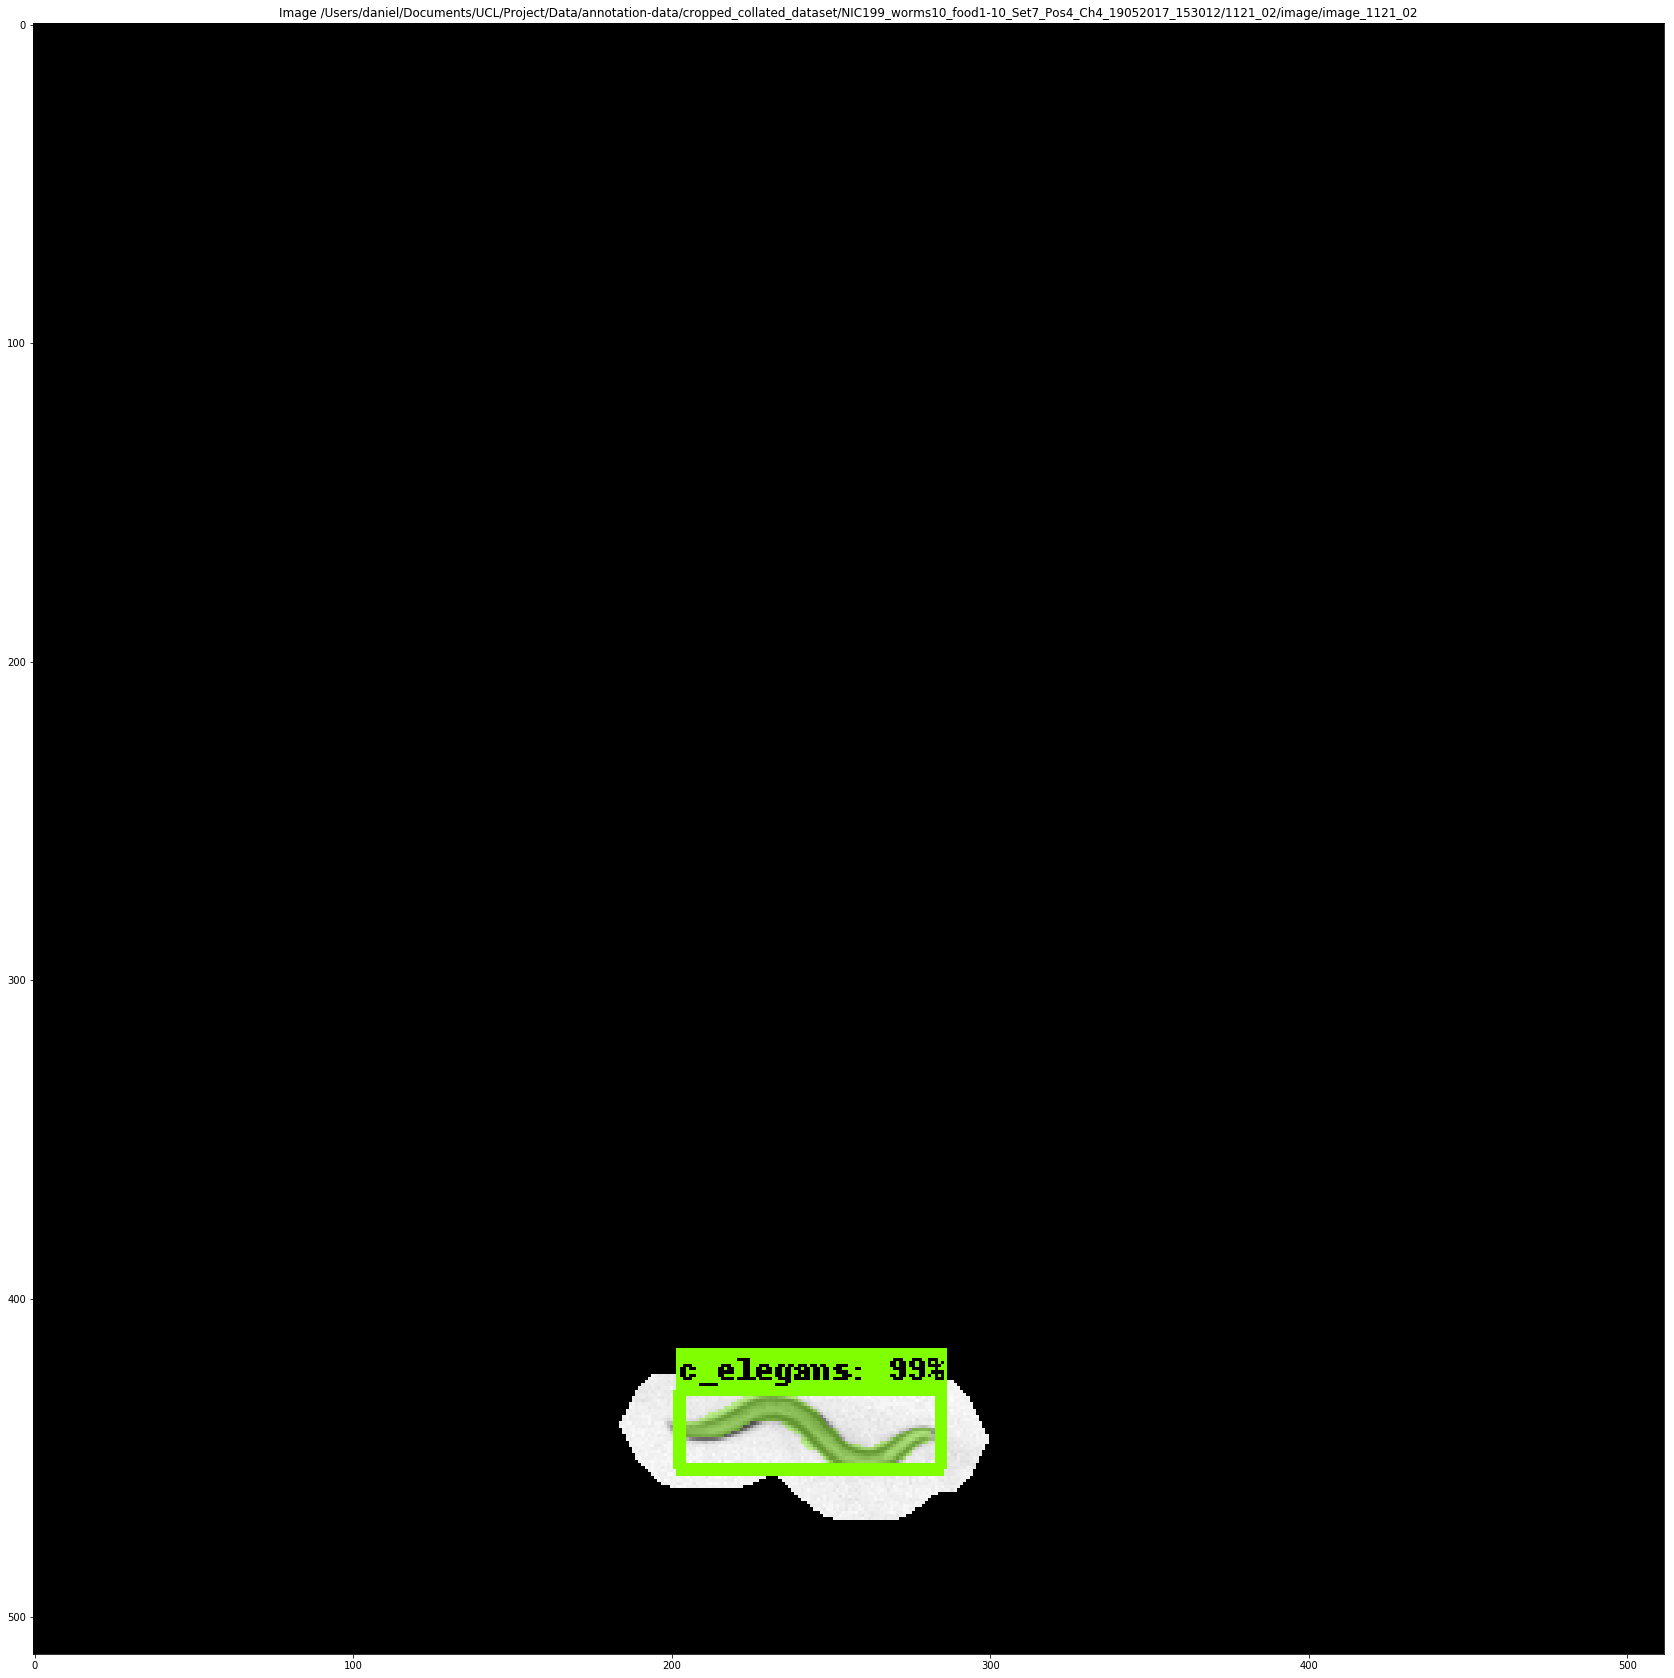

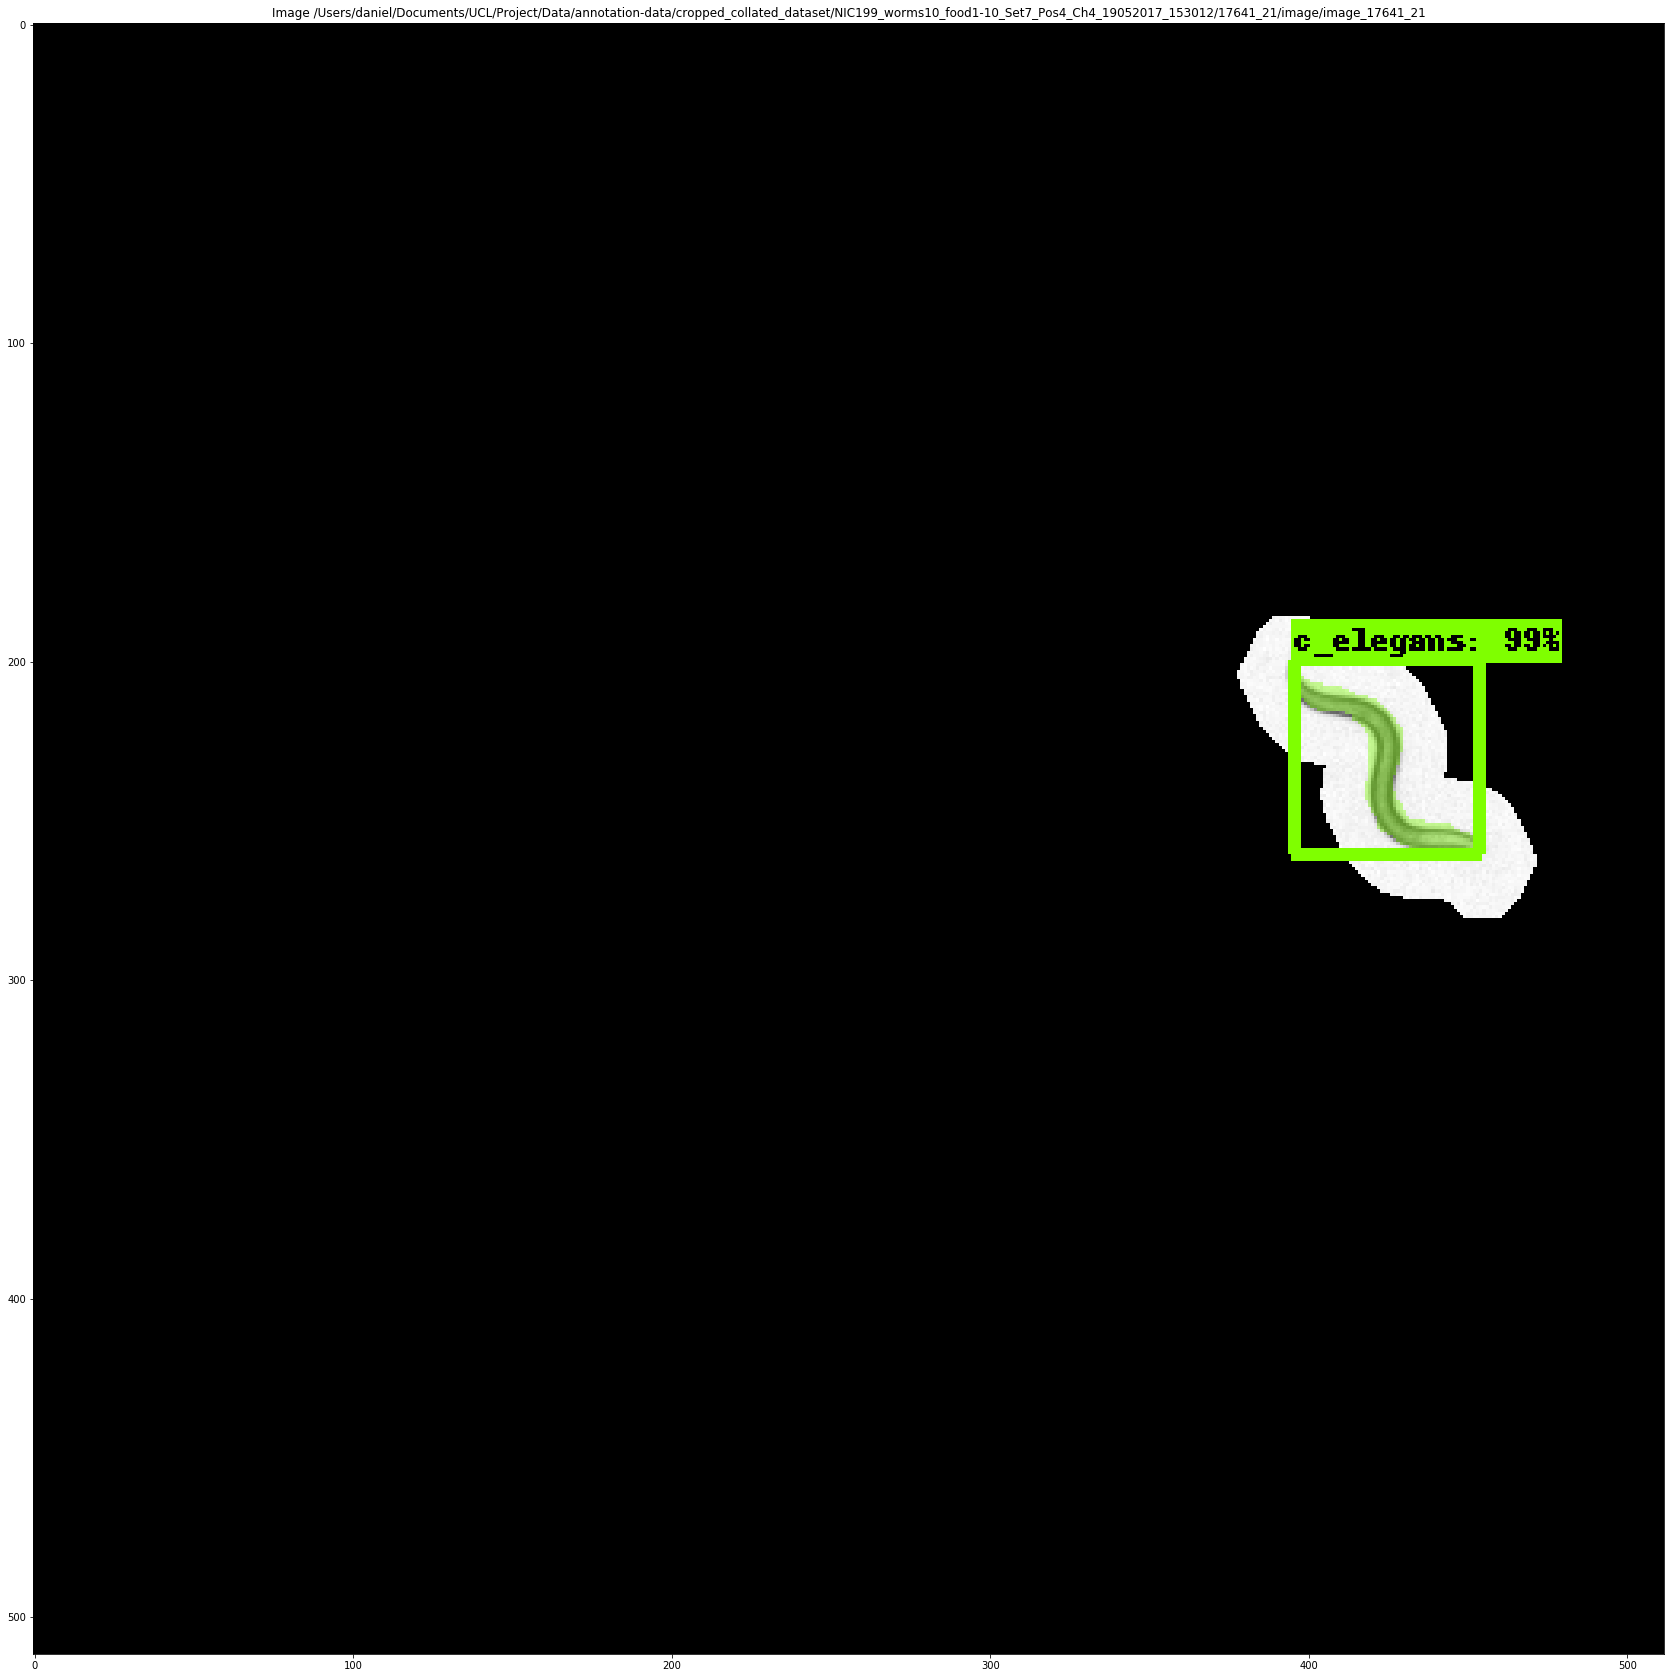

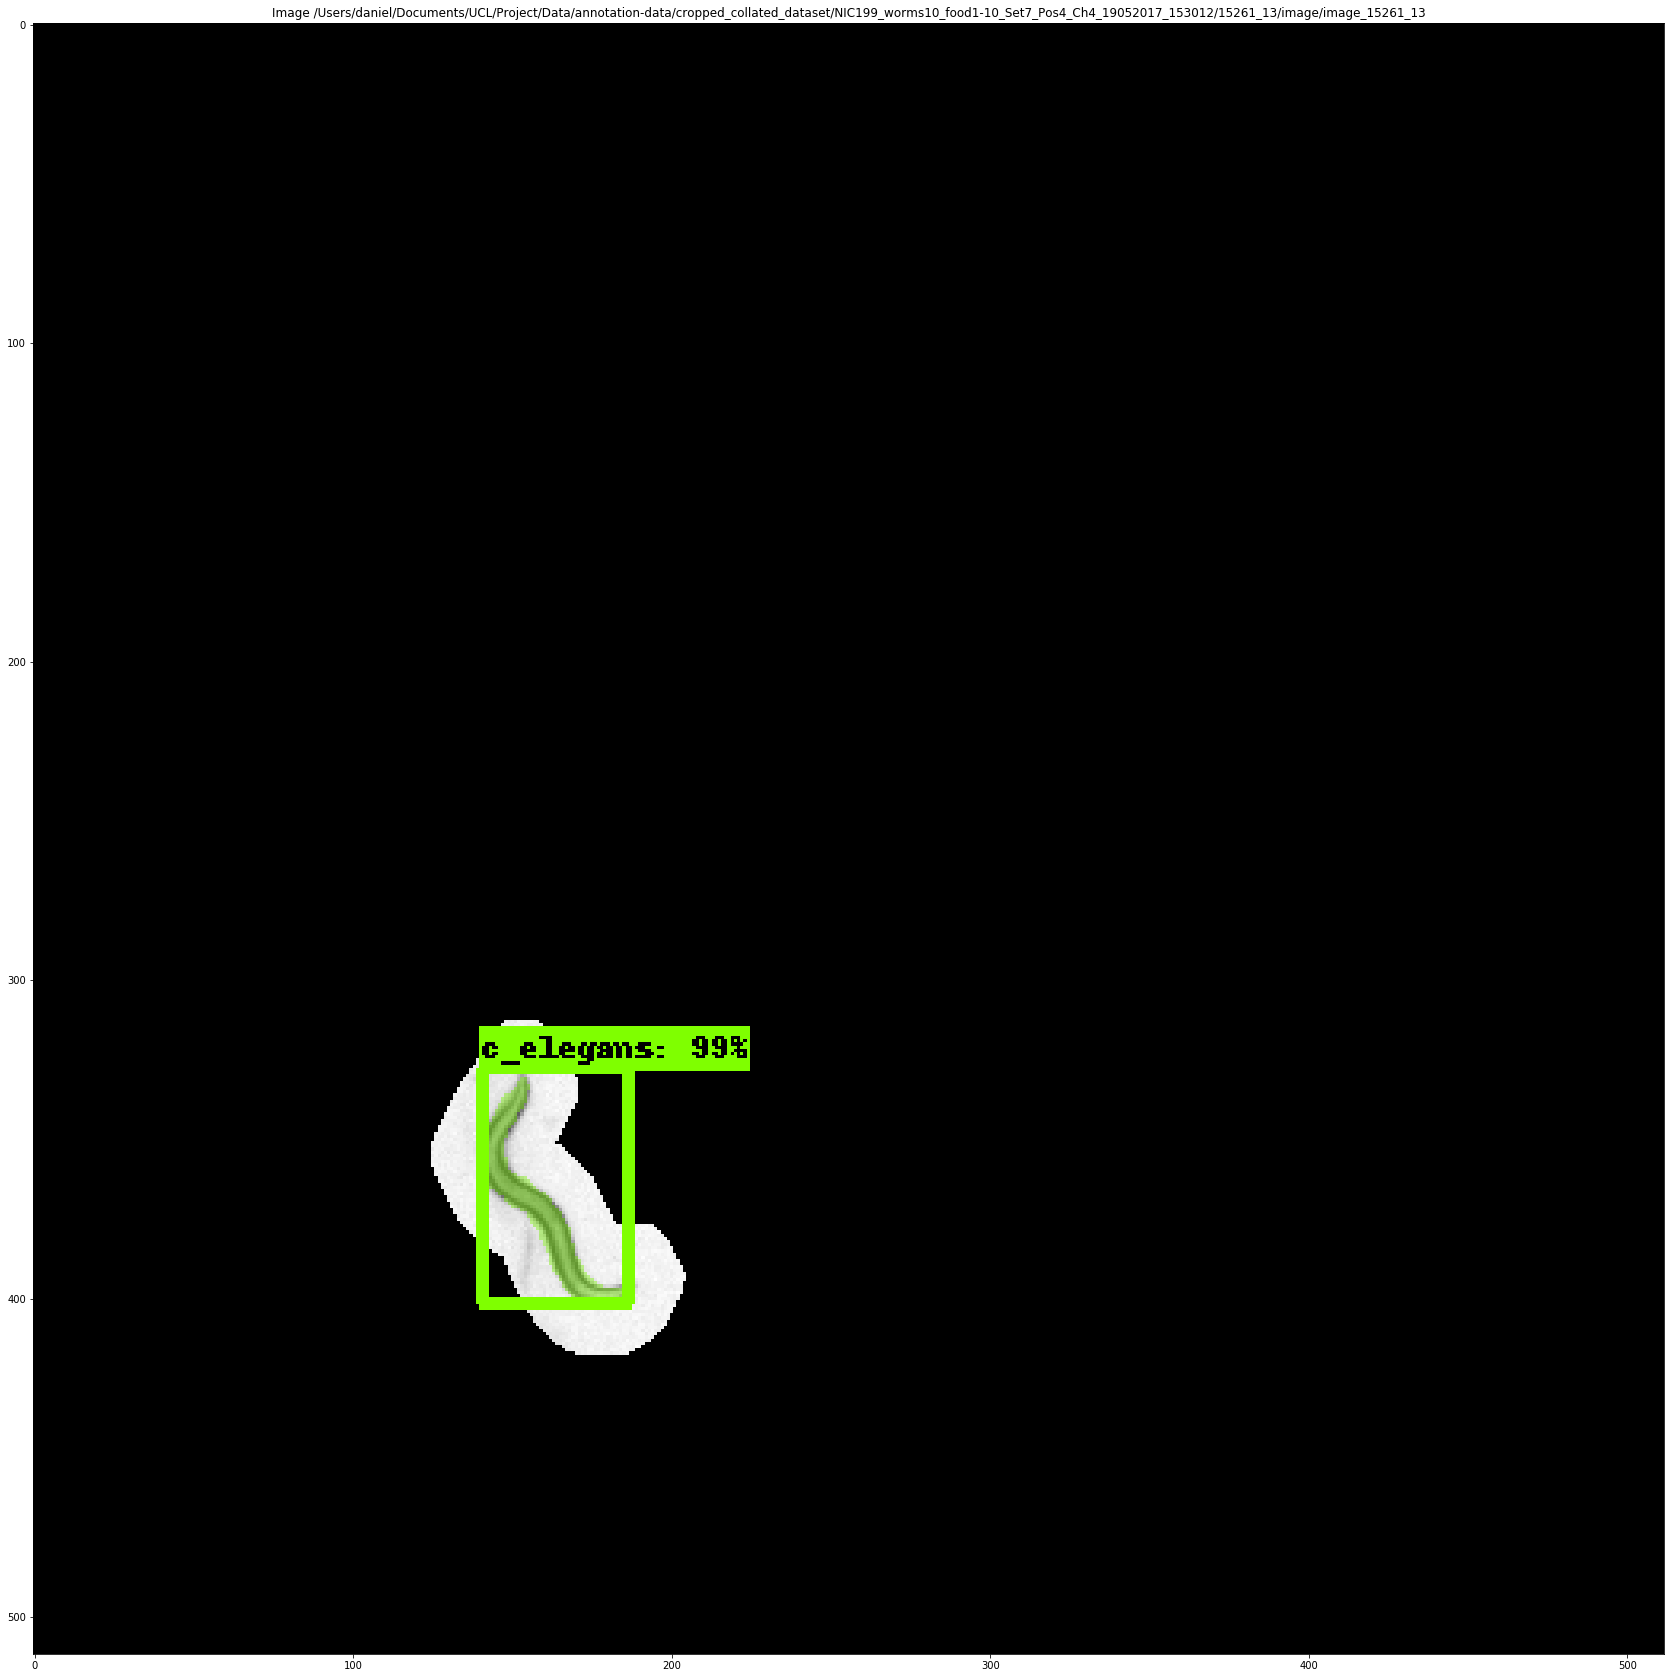

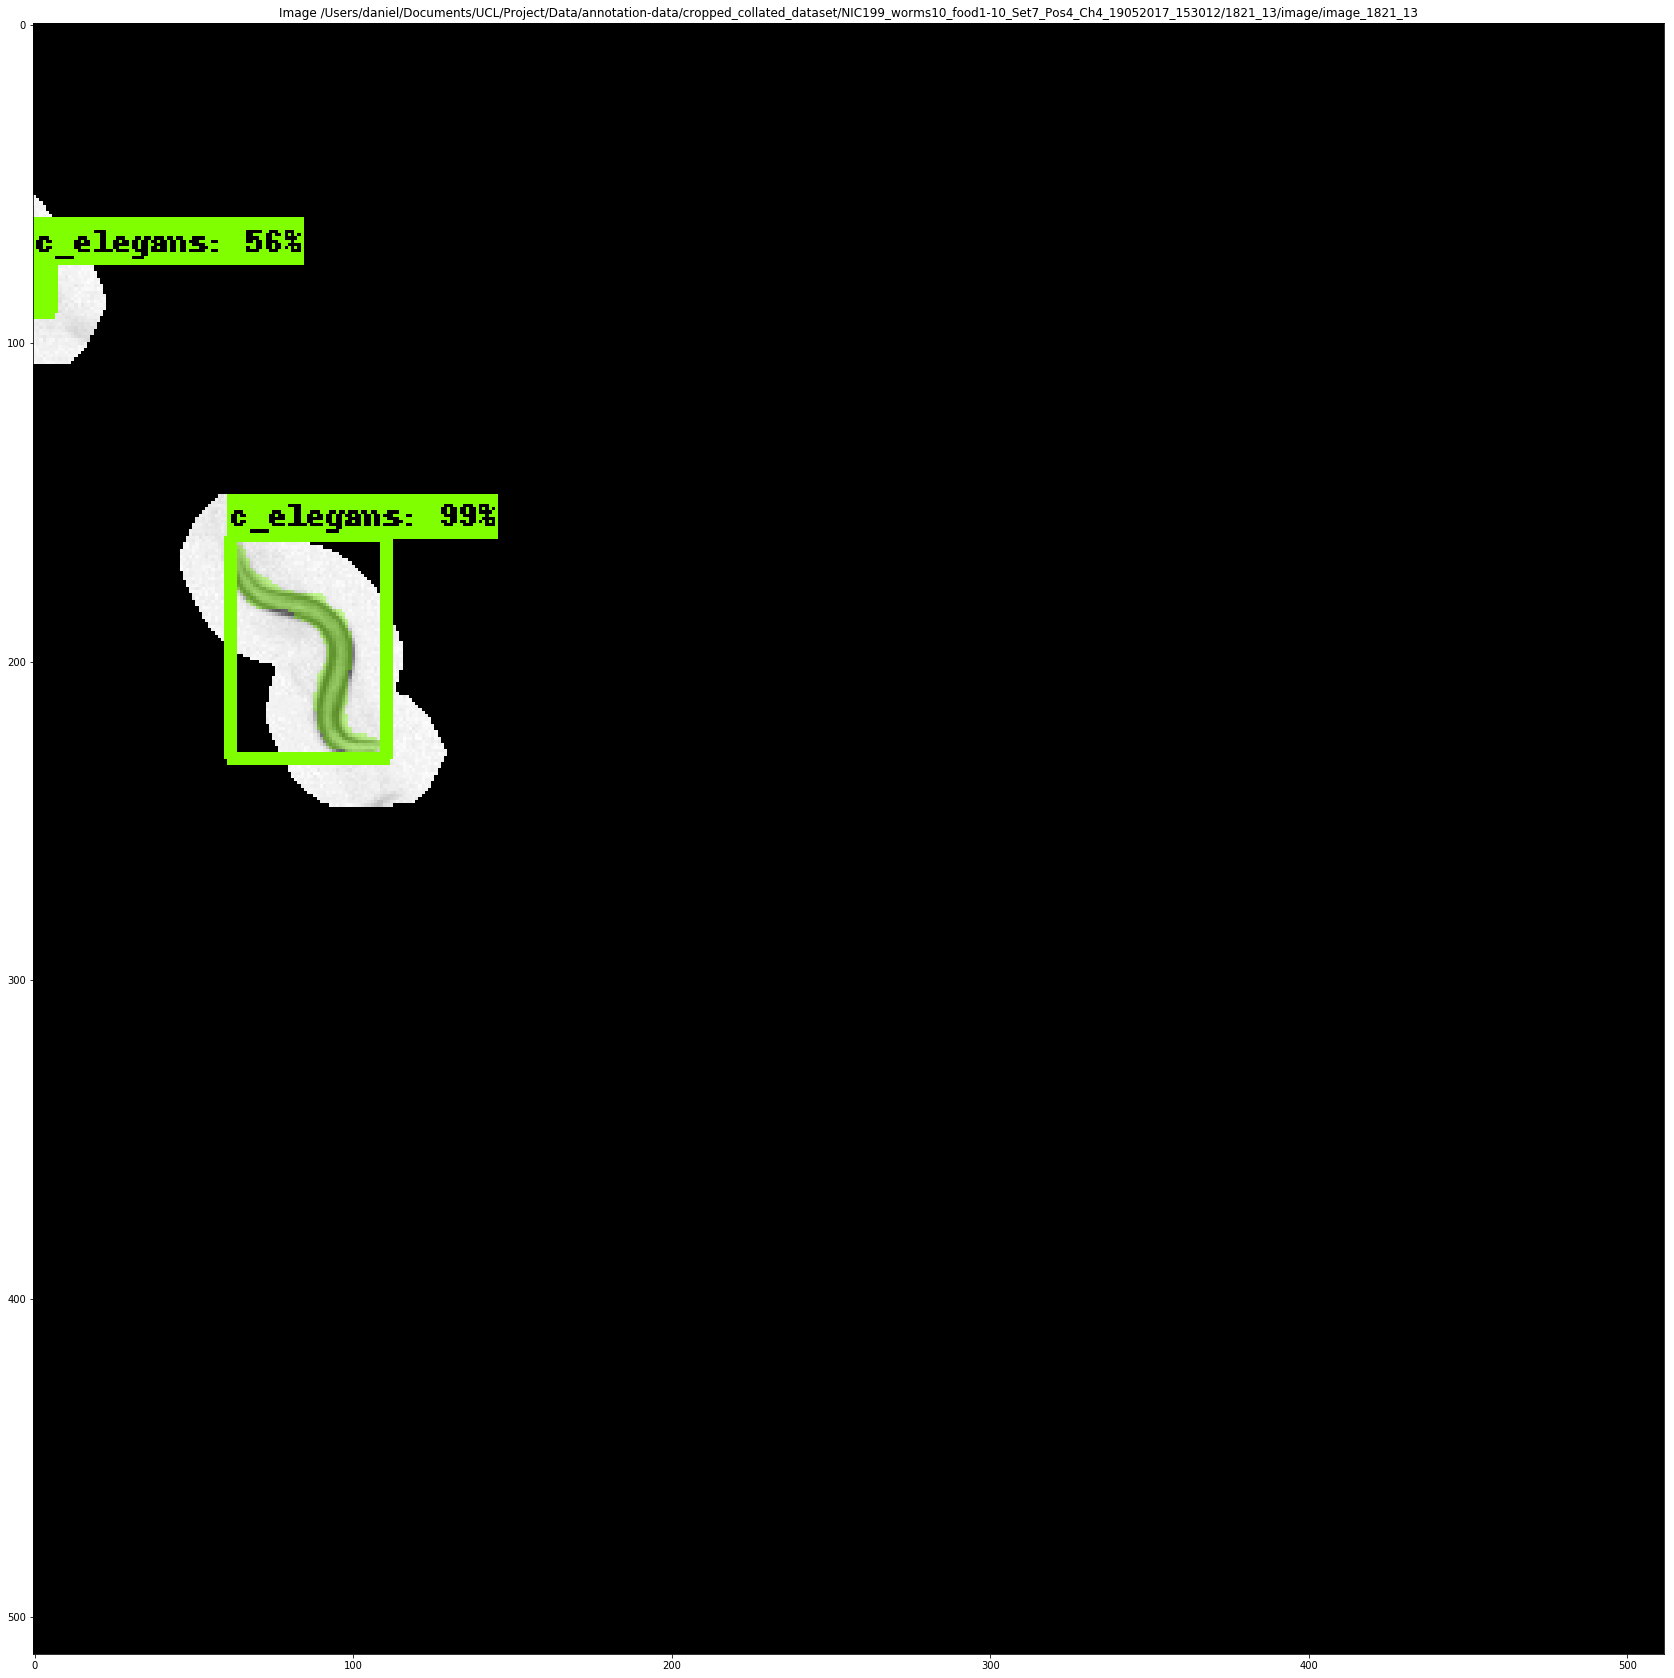

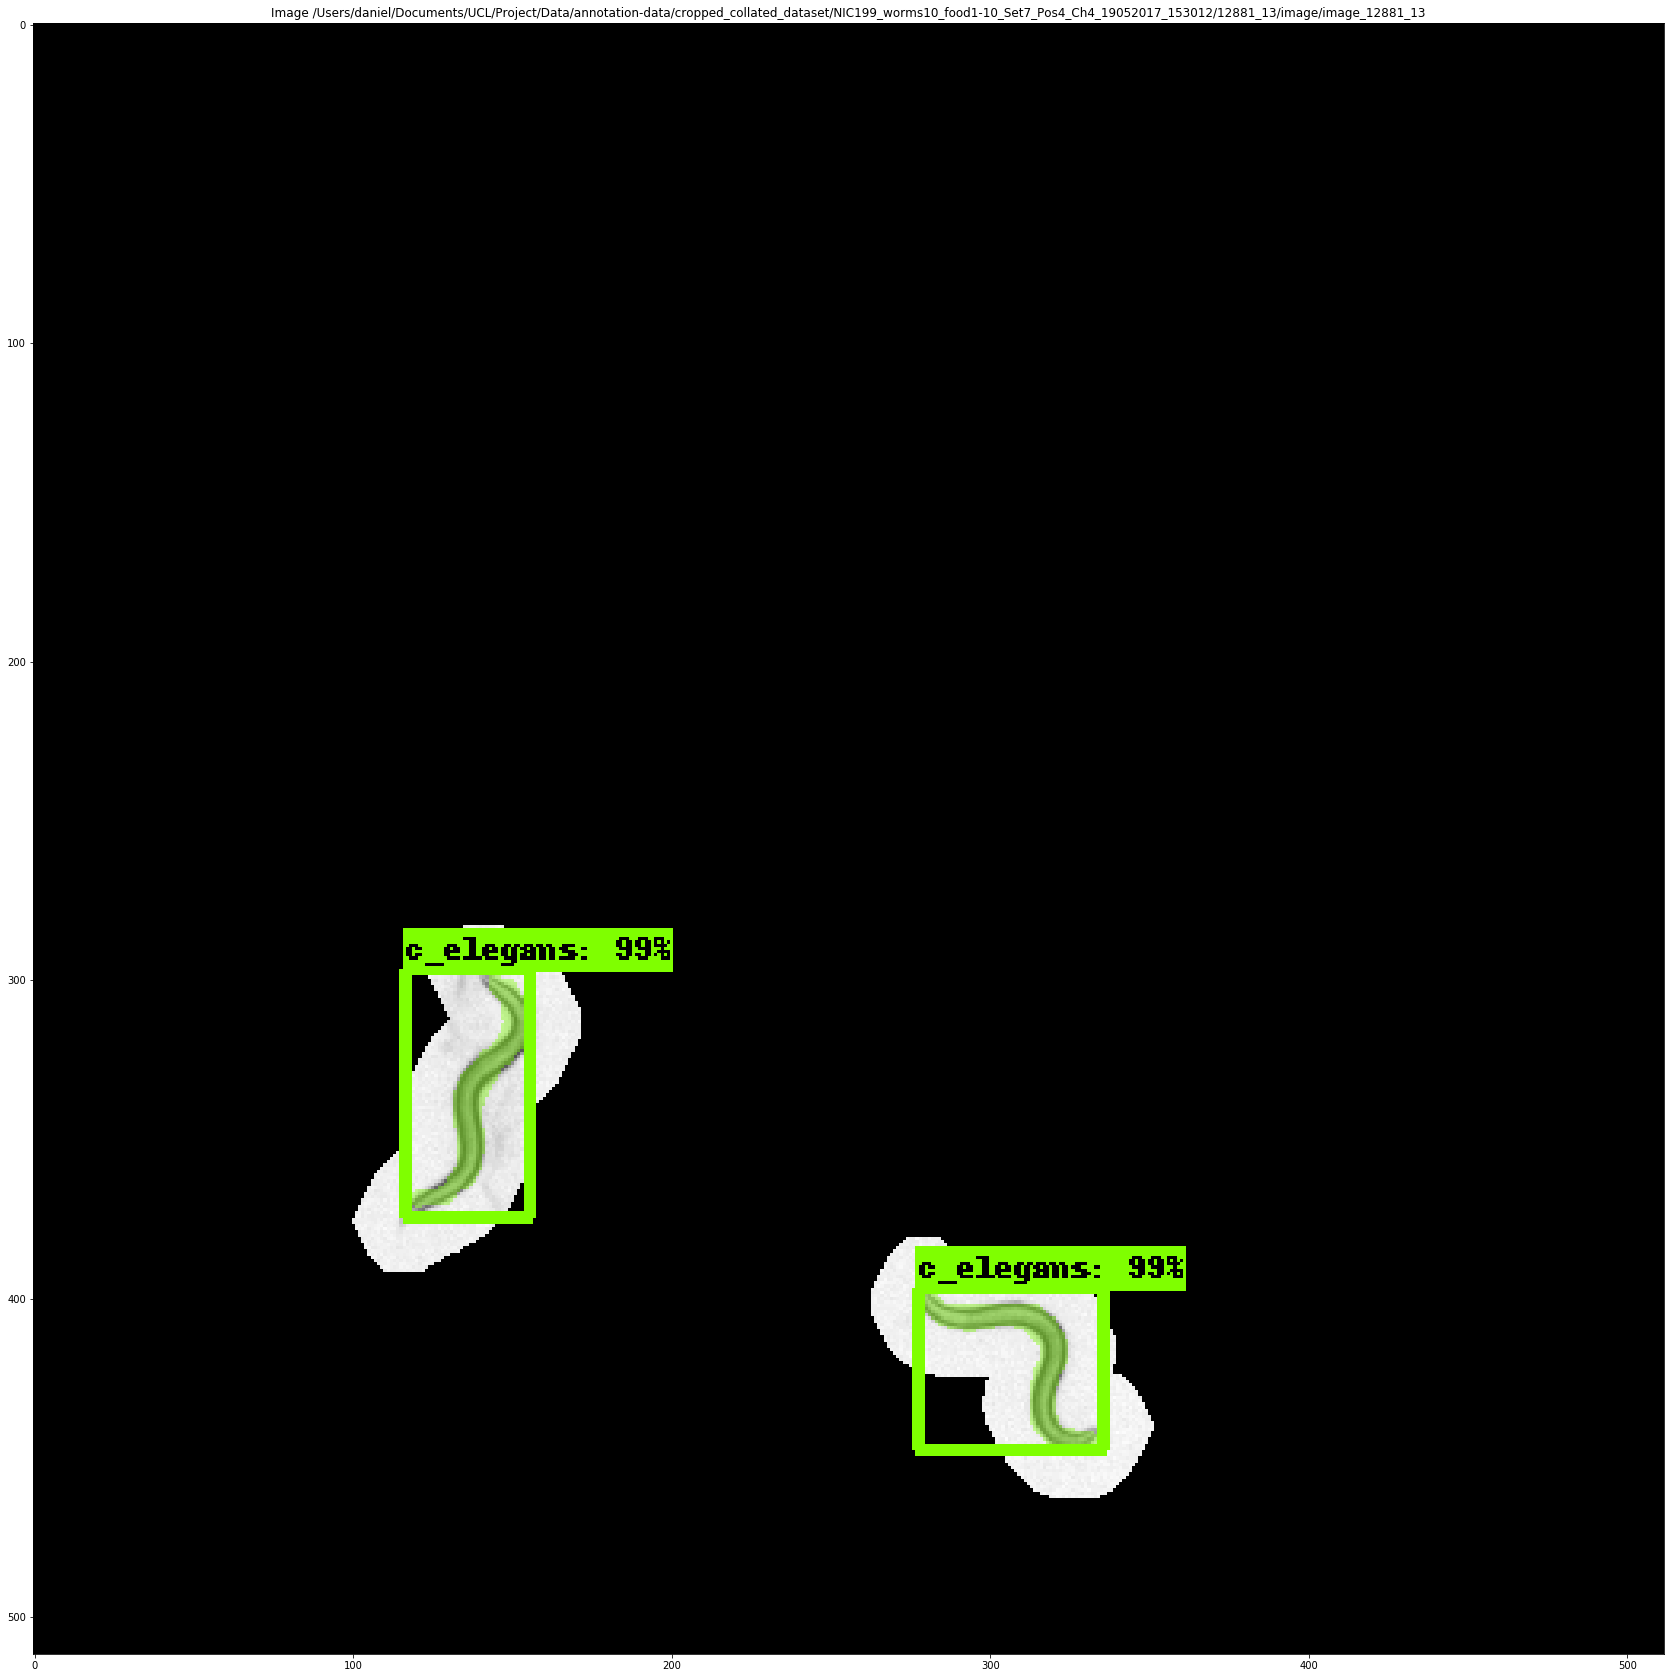

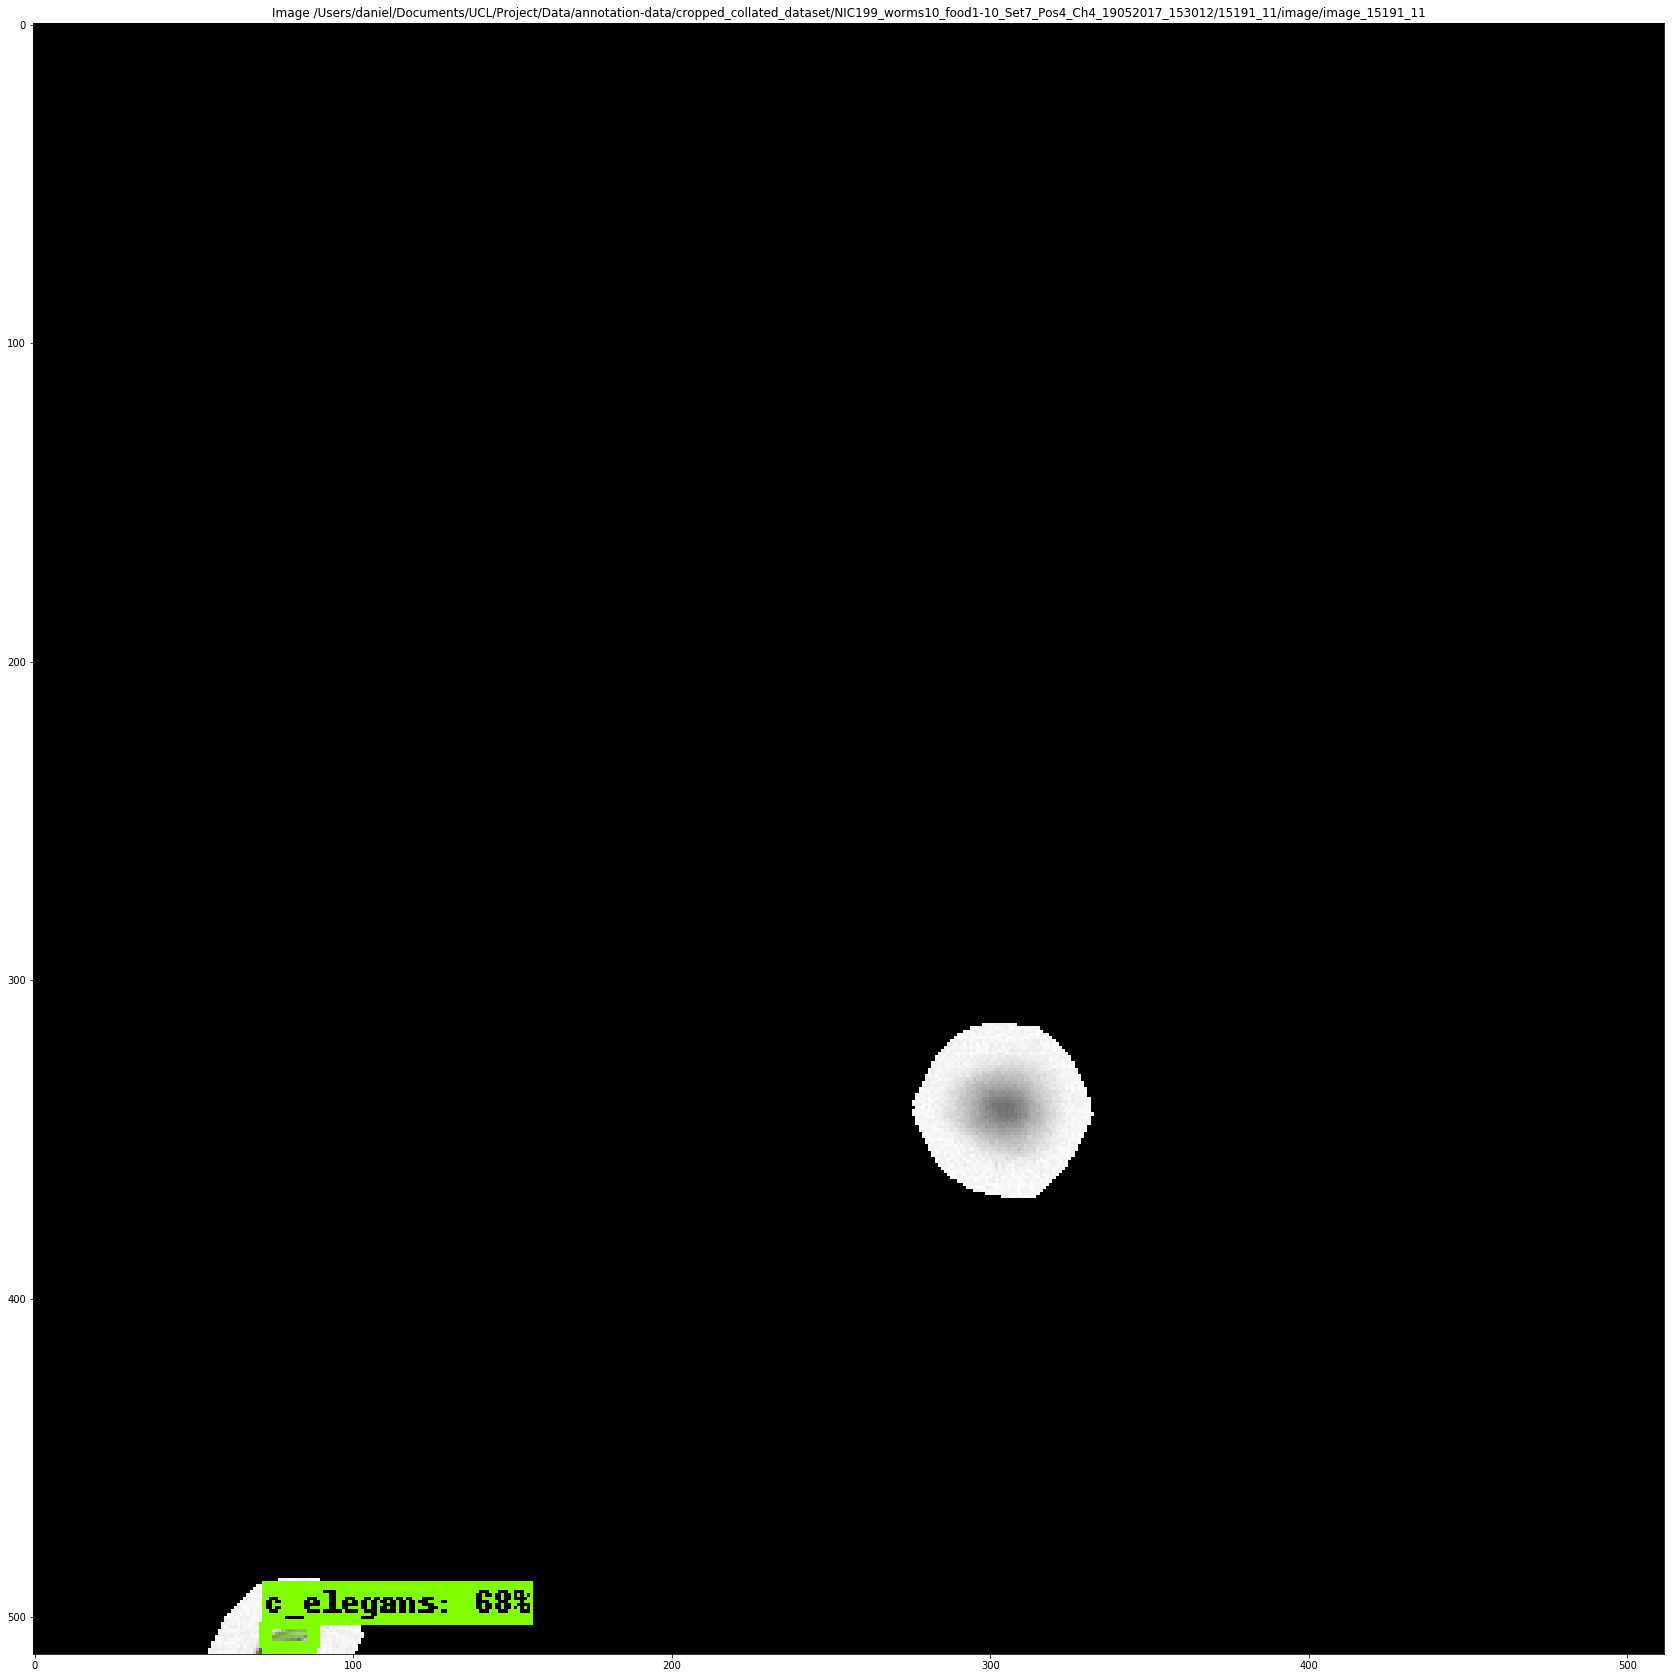

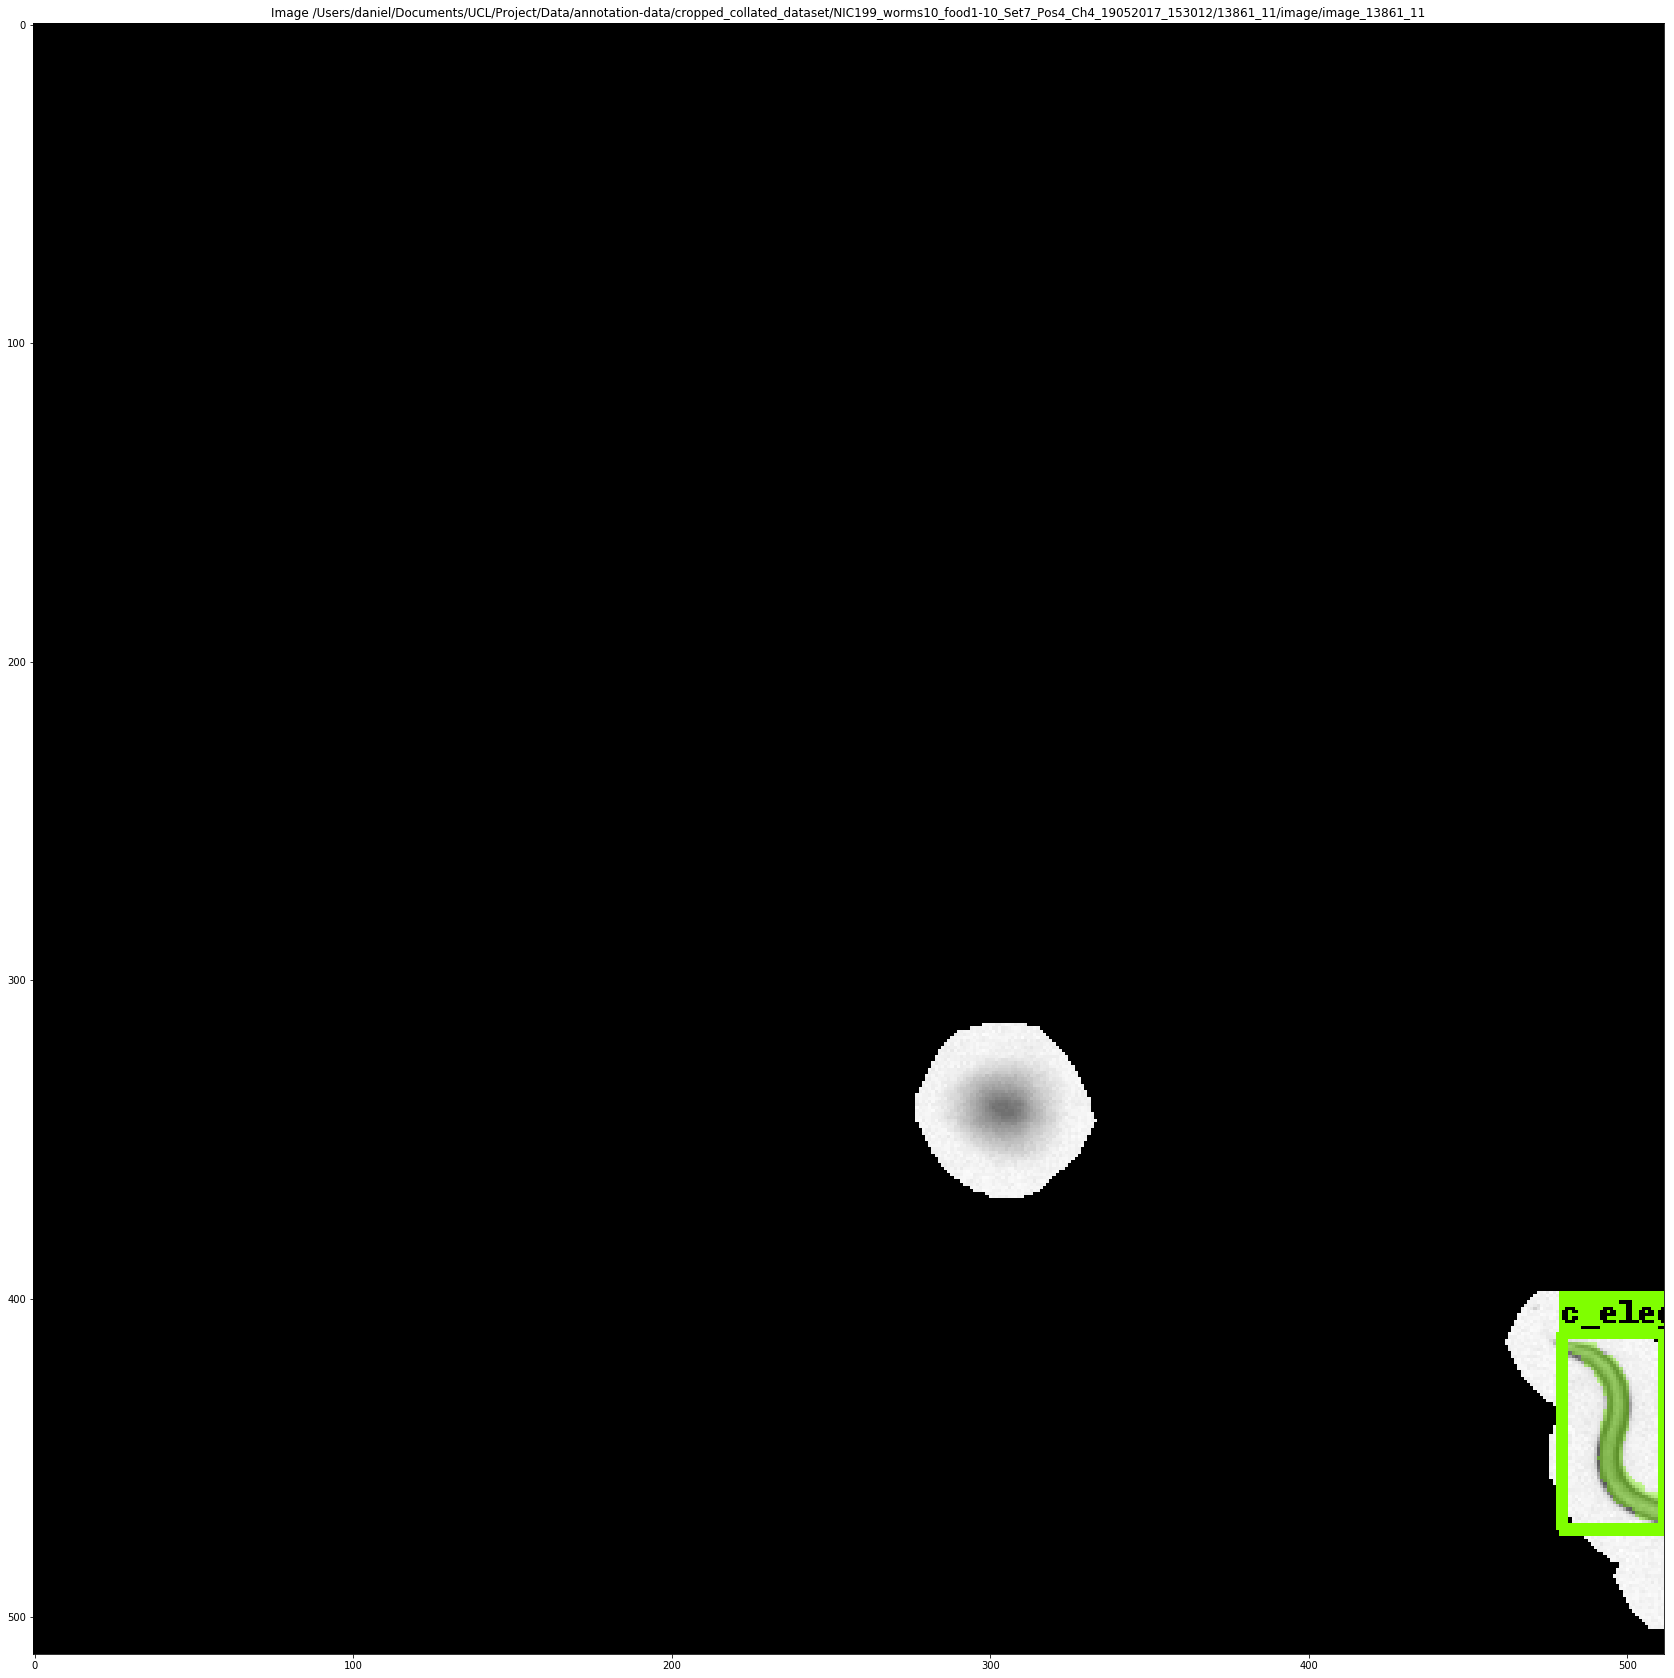

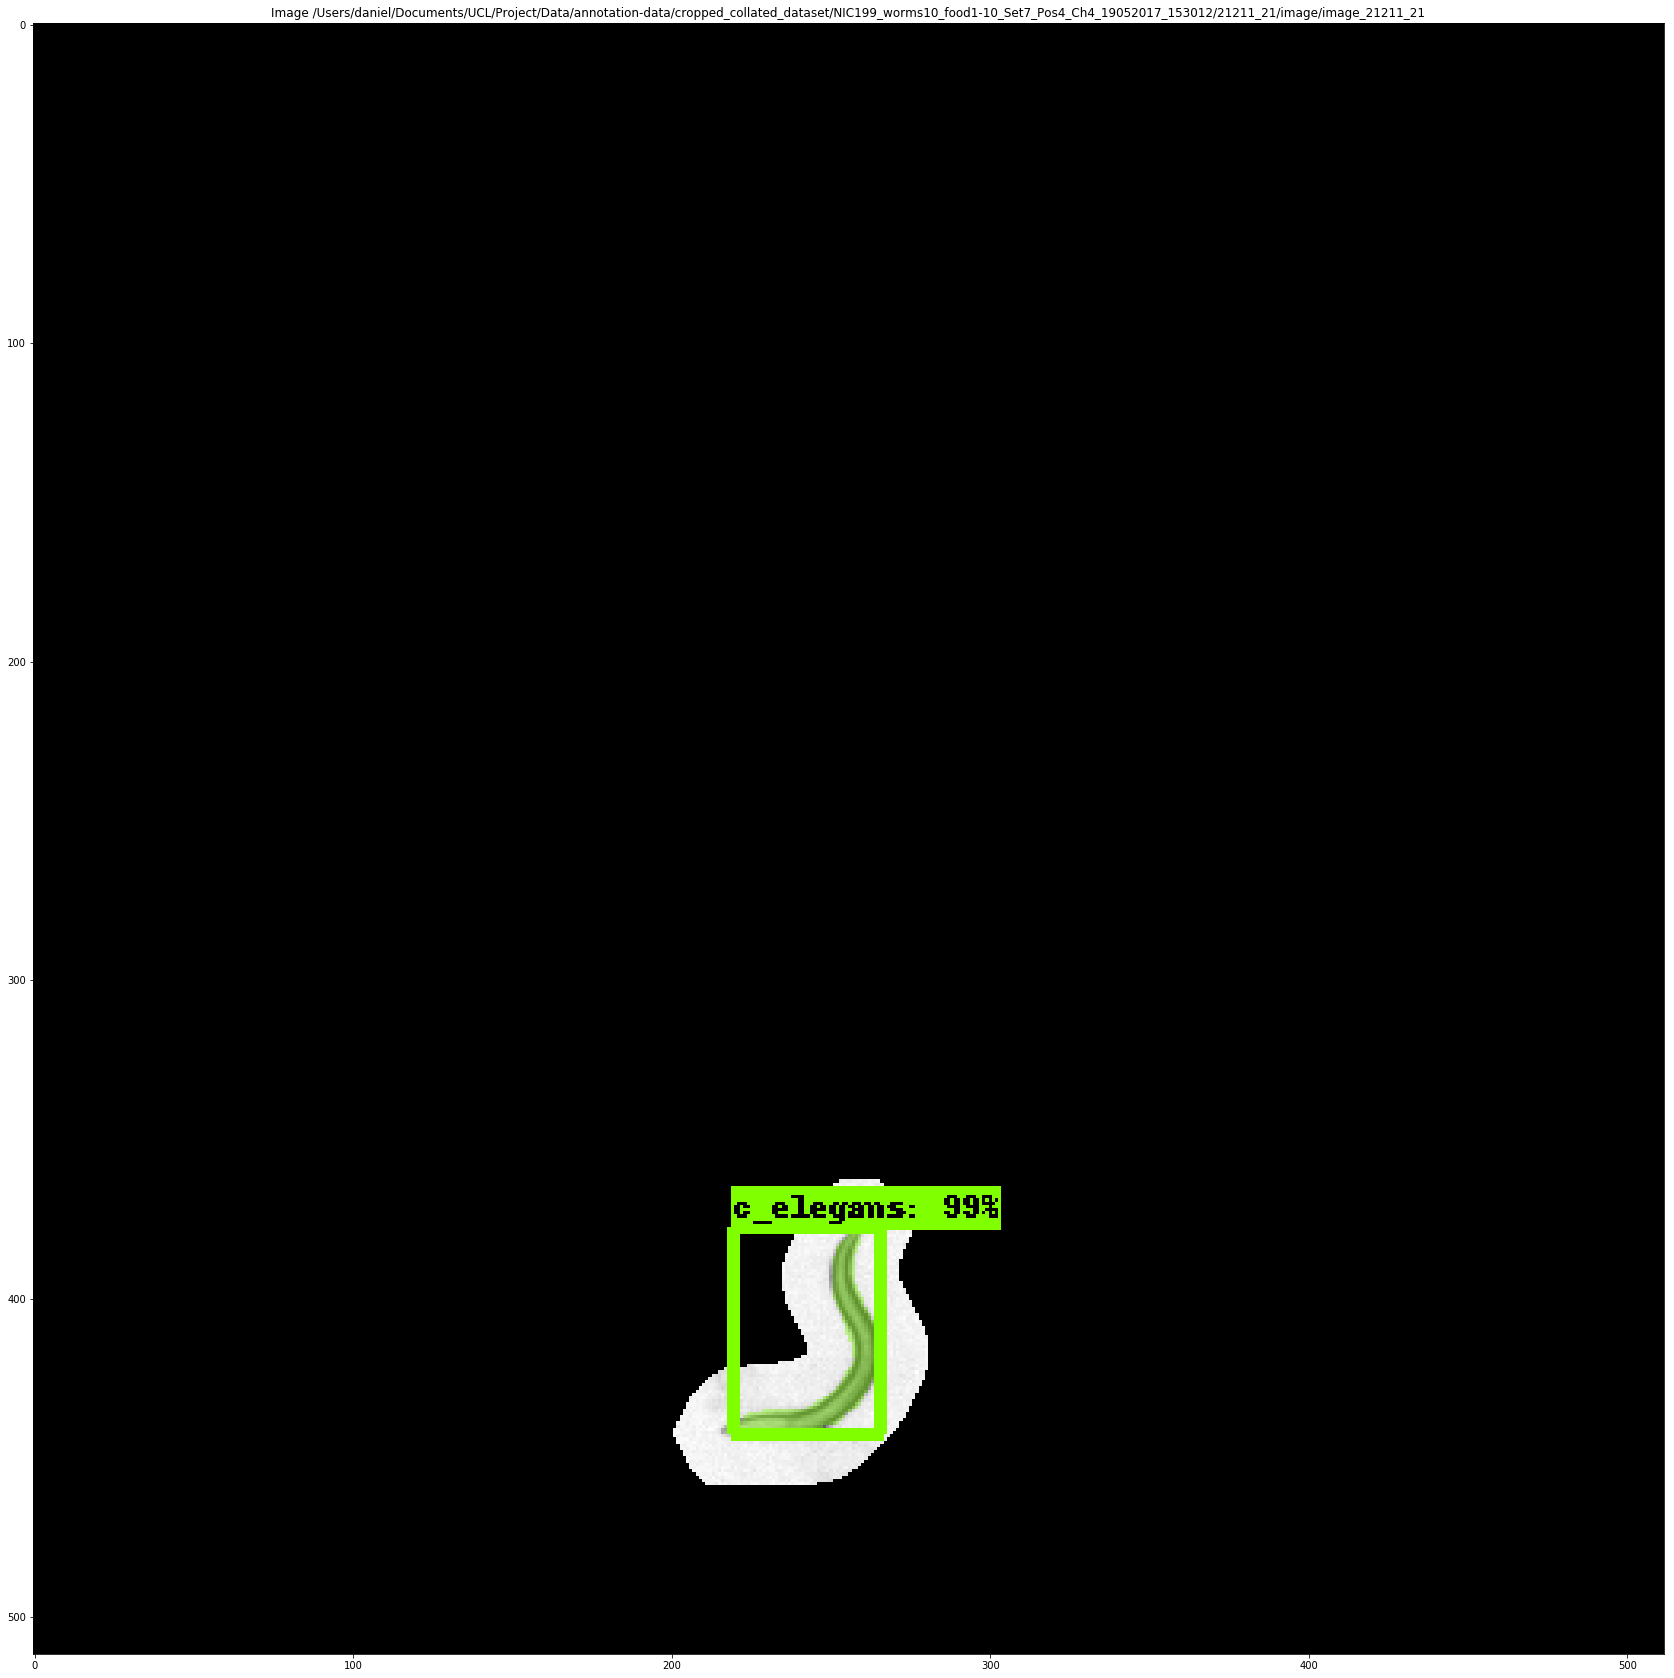

In [13]:
output_dicts_list = []
for image_path in TEST_IMAGE_PATHS:

    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    
    if image_np.shape[0] > 1024:
        tiled_image = split_image(image_np)

        for tile in tiled_image:
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    #         image_np_expanded = np.expand_dims(tile, axis=0)
            # Actual detection.
            output_dict = run_inference_for_single_image(tile, detection_graph)
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                tile,
                output_dict['detection_boxes'],
                output_dict['detection_classes'],
                output_dict['detection_scores'],
                category_index,
                instance_masks=output_dict.get('detection_masks'),
                use_normalized_coordinates=True,
                line_thickness=4)
            
            output_dicts_list.append(output_dict)


        plt.figure(figsize=IMAGE_SIZE)
        plt.title("Image {}".format(image_path[:-4]))

        analysed_image = reassemble_image(tiled_image)
        plt.imshow(analysed_image)
        plt.show()
        plt.close()
        
        
    else:
        # for image_path in TEST_IMAGE_PATHS:
        image = Image.open(image_path)
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.
        output_dict = run_inference_for_single_image(image_np, detection_graph)
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks'),
          use_normalized_coordinates=True,
          line_thickness=4)
        plt.figure(figsize=IMAGE_SIZE)
        plt.title("Image {}".format(image_path[:-4]))
        plt.imshow(image_np)
        plt.show()
        plt.close()
        
        output_dicts_list.append(output_dict)
    

In [14]:
# for image_path in TEST_IMAGE_PATHS:
#   image = Image.open(image_path)
#   # the array based representation of the image will be used later in order to prepare the
#   # result image with boxes and labels on it.
#   image_np = load_image_into_numpy_array(image)
#   # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
#   image_np_expanded = np.expand_dims(image_np, axis=0)
#   # Actual detection.
#   output_dict = run_inference_for_single_image(image_np, detection_graph)
#   # Visualization of the results of a detection.
#   vis_util.visualize_boxes_and_labels_on_image_array(
#       image_np,
#       output_dict['detection_boxes'],
#       output_dict['detection_classes'],
#       output_dict['detection_scores'],
#       category_index,
#       instance_masks=output_dict.get('detection_masks'),
#       use_normalized_coordinates=True,
#       line_thickness=4)
#   plt.figure(figsize=IMAGE_SIZE)
#   plt.title("Image {}".format(image_path[:-4]))
#   plt.imshow(image_np)

# Skeletonisation

Take any worm with a score of >0.5 as a correct example

In [15]:
output_dict = output_dicts_list[8]

In [16]:
# for i in range(output_dict['num_detections']):
#     plt.figure
#     plt.imshow(output_dict['detection_masks'][i])
#     plt.show()
#     plt.close

In [17]:
found_worms = np.where(output_dict['detection_scores'] > 0.5)
output_dict['detection_boxes'] = output_dict['detection_boxes'][found_worms]
output_dict['detection_classes'] = output_dict['detection_classes'][found_worms]
output_dict['detection_scores'] = output_dict['detection_scores'][found_worms]
output_dict['detection_masks'] = output_dict['detection_masks'][found_worms]

In [18]:
found_worms

(array([0, 1]),)

In [19]:
skeletons = []
for worm in output_dict['detection_masks']:
    skeletons.append(skeletonize(worm).astype(np.uint8))
skeletons = np.array(skeletons)

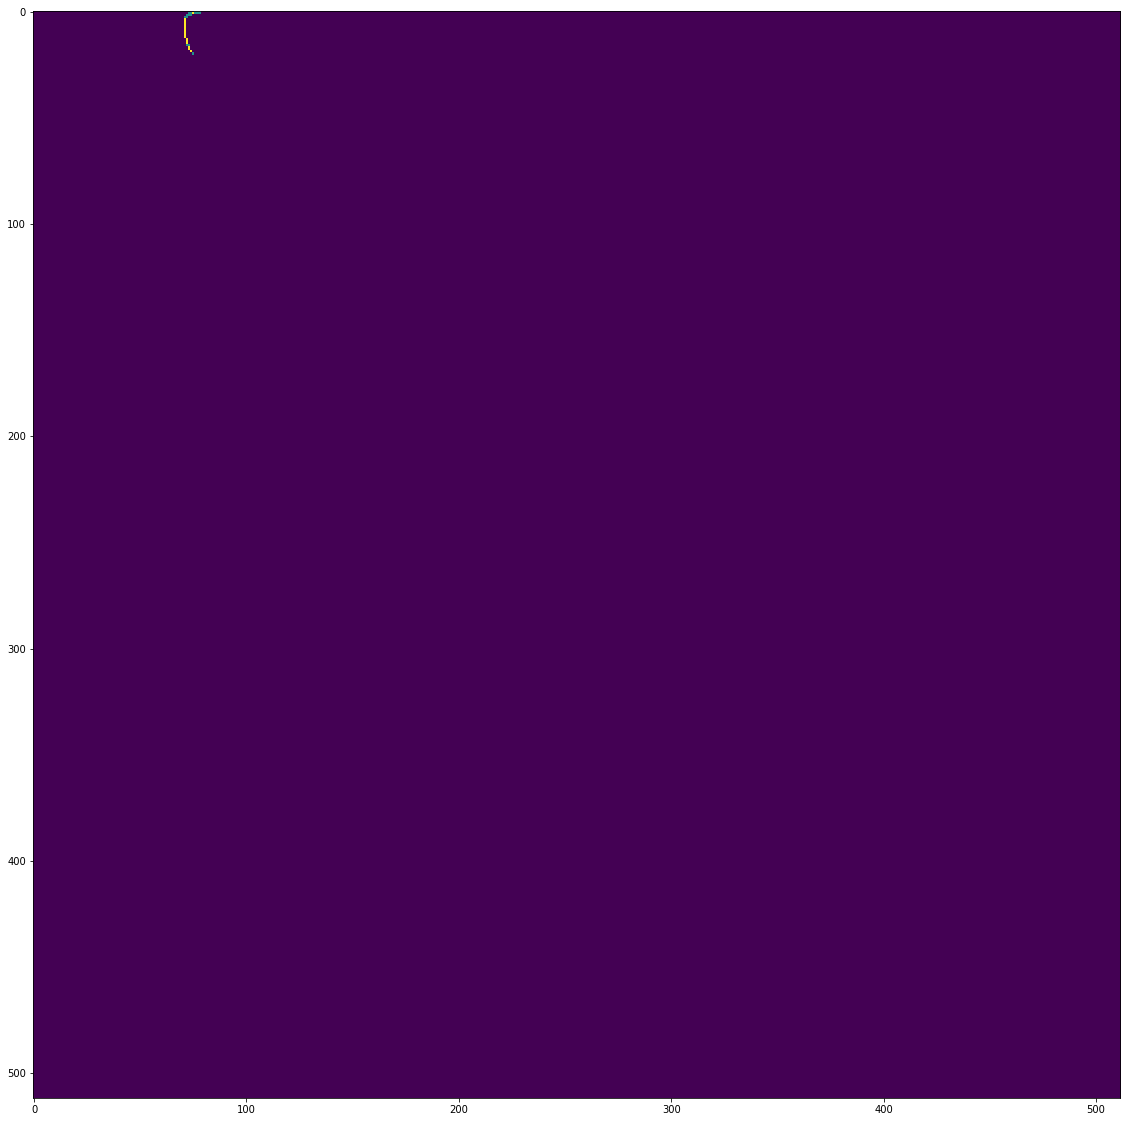

In [20]:
plt.figure(figsize=(20,20))
plt.imshow(np.sum(skeletons, axis=0))